In [1]:
'''
20251113:
    分析不同语种神经元的激活情况
20251120:
    复现baseline--LAPE
    20251124:
        当前只考虑MLP层

'''

'\n20251113:\n    分析不同语种神经元的激活情况\n20251120:\n    复现baseline--LAPE\n    20251124:\n        当前只考虑MLP层\n\n'

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np


def get_quantile(data):
    # 示例数据（替换成你的数据）
    #data = [3.2, 5.1, 7.4, 2.8, 6.0, 4.9, 8.2, 1.5, 9.0]
    
    # 想查看的分位点（百分比形式，例如 0.25 表示 25% 分位）
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    
    # 计算分位数
    results = np.quantile(data, quantiles)
    
    # 打印结果
    for q, r in zip(quantiles, results):
        print(f"{int(q*100)}% 分位数: {r}")


In [4]:
def get_key_quan(data, key):
    all_neuron_data = []
    for inu in data[key]:#data['model.layers.0.mlp.down_proj.weight']:
        #print(inu.shape)
        all_neuron_data.extend(inu.float().numpy().tolist())
    
    get_quantile(all_neuron_data)

In [5]:
def calc_per_neu_mean(data):
    '''
    对每种语言，计算每个神经元的均值/方差

    '''
    result={}

    for ikey in data.keys():

        # mean & var dict
        result[ikey]={}

        
        result[ikey]['mean'] = np.mean(np.array([itmp.float().numpy().tolist() for itmp in data[ikey] ]), axis =1)
        result[ikey]['var'] = np.var(np.array([itmp.float().numpy().tolist() for itmp in data[ikey] ]), axis = 1)
    return result
        

In [6]:
def calc_mean_var_diff(result_other_lang, result_en):
    '''
    计算其他语言和英语神经元 均值和方差的diff

    '''

    all_mean_diff = []
    for ikey in result_other_lang.keys():
        o_lang = np.array(result_other_lang[ikey]['mean'].tolist())
        en_lang = np.array(result_en[ikey]['mean'].tolist())

        mean_diff = o_lang - en_lang

        all_mean_diff.extend(mean_diff.tolist())

    return all_mean_diff
    

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 你的 diff 数据

def drwa_ecdf(data):
    '''
    data = np.array([
        0.00023478745424654335,
        -8.707778761163354e-05,
        -0.0002664269686647458,
        -0.00013238142128102481,
        1.3182201655581594e-05,
        -5.4263437050394714e-05,
        -0.0002950956331915222,
        -0.0004534808249445632
    ])
    '''
    
    # ECDF 计算
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    
    # 画图
    plt.figure(figsize=(6, 4))
    plt.step(x, y, where='post')
    plt.xlabel("diff values")
    plt.ylabel("ECDF")
    plt.title("ECDF of diff distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:

def plot_ecdf_groups(data_groups, labels=None):
    """
    data_groups: list of 1D arrays/lists
    labels: list of names for each group
    """
    plt.figure(figsize=(8, 5))

    if labels is None:
        labels = [f"group_{i}" for i in range(len(data_groups))]

    for data, name in zip(data_groups, labels):
        data = np.array(data)
        x = np.sort(data)
        y = np.arange(1, len(x) + 1) / len(x)
        #plt.step(x, y, where='post', label=name)
        plt.step(x, y, where='post', label=name, alpha=0.6)

    plt.xlabel("Value")
    plt.ylabel("ECDF")
    plt.title("ECDF Comparison Across Groups")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib.pyplot as plt


def draw_box(data):
    # 你的数据（示例）
    '''
    data = [
        0.00023478745424654335,
        -8.707778761163354e-05,
        -0.0002664269686647458,
        -0.00013238142128102481,
        1.3182201655581594e-05,
        -5.4263437050394714e-05,
        -0.0002950956331915222,
        -0.0004534808249445632
    ]
    '''
    
    plt.figure(figsize=(5, 6))
    plt.boxplot(
        data,
        vert=True,
        showfliers=True         # 如要隐藏异常值点可改为 False
    )
    plt.ylabel("diff values")
    plt.title("Boxplot of diff distribution")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    plt.tight_layout()
    plt.show()


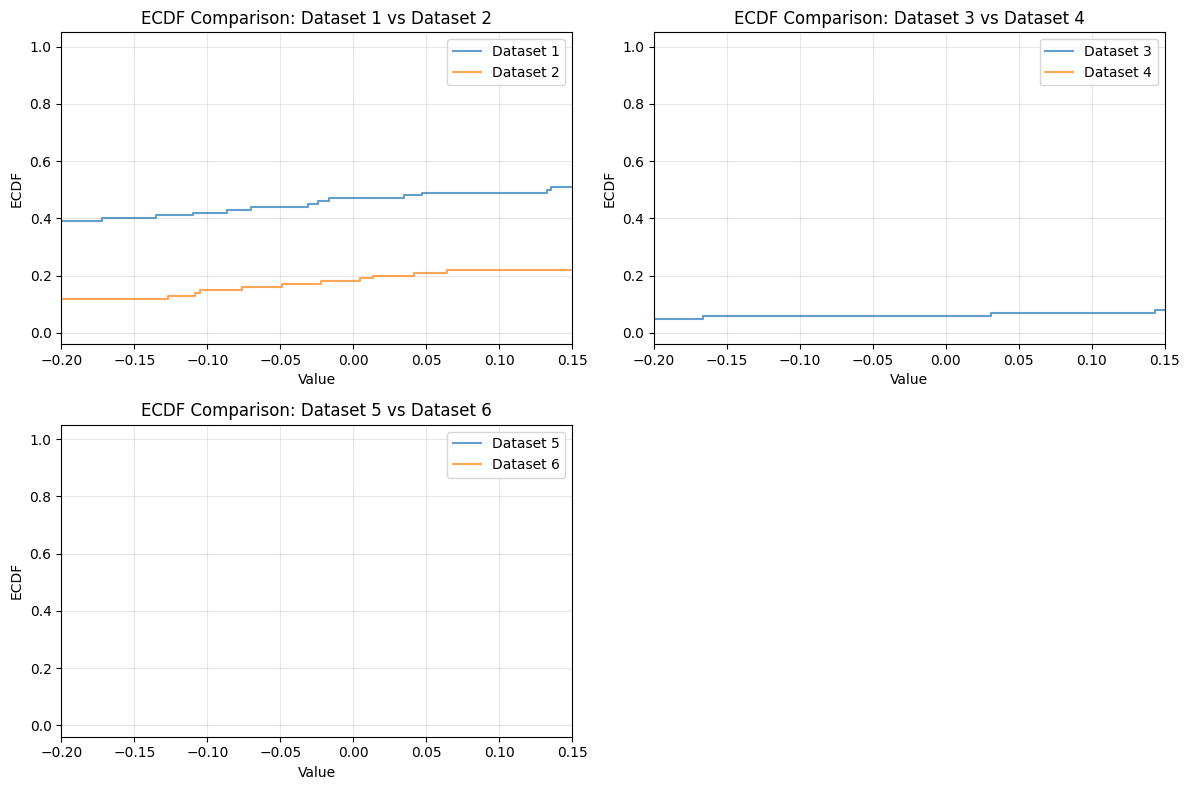

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecdf_pairs(data_groups, labels=None,xdim_min = -0.2, xdim_max= 0.15):
    """
    data_groups: list of 1D arrays/lists (up to 26 groups)
    labels: list of names for each group
    Each subplot shows ECDF of 2 groups for comparison
    """
    if labels is None:
        labels = [f"group_{i+1}" for i in range(len(data_groups))]
    
    # Calculate number of subplots needed (each subplot has 2 groups)
    total_groups = len(data_groups)
    total_subplots = int(np.ceil(total_groups / 2))
    
    # Determine grid layout (try to make it as square as possible)
    cols = int(np.ceil(np.sqrt(total_subplots)))
    rows = int(np.ceil(total_subplots / cols))
    
    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    
    # Handle cases where there's only one subplot
    if total_subplots == 1:
        axes = np.array([axes])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    else:
        axes = axes if total_subplots > 1 else np.array([[axes]])
    
    # Plot ECDF for each pair of groups
    subplot_idx = 0
    for i in range(0, total_groups, 2):
        # Determine current subplot position
        row = subplot_idx // cols
        col = subplot_idx % cols
        
        # Get the current axis
        if rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        # Plot first group
        data1 = np.array(data_groups[i])
        x1 = np.sort(data1)
        y1 = np.arange(1, len(x1) + 1) / len(x1)
        ax.step(x1, y1, where='post', label=labels[i], alpha=0.7, linewidth=1.5)
        
        # Plot second group if it exists
        if i + 1 < total_groups:
            data2 = np.array(data_groups[i + 1])
            x2 = np.sort(data2)
            y2 = np.arange(1, len(x2) + 1) / len(x2)
            ax.step(x2, y2, where='post', label=labels[i + 1], alpha=0.7, linewidth=1.5)
        
        ax.set_xlabel("Value")
        ax.set_ylabel("ECDF")
        ax.set_title(f"ECDF Comparison: {labels[i]} vs {labels[i+1] if i+1 < total_groups else 'N/A'}")
        ax.grid(alpha=0.3)
        ax.legend()

        # Set Y-axis range to -0.2 to 0.15
        ax.set_xlim(xdim_min, xdim_max)
        
        subplot_idx += 1
    
    # Hide unused subplots
    for i in range(subplot_idx, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            axes[0, col].set_visible(False)
        elif cols == 1:
            axes[row, 0].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Example usage with 6 groups (can be extended up to 26)
data_groups = [np.random.normal(loc=i, scale=1.2, size=100) for i in range(6)]
labels = [f'Dataset {i+1}' for i in range(len(data_groups))]

plot_ecdf_pairs(data_groups, labels)

# Example with 26 groups
# data_groups_26 = [np.random.normal(loc=i, scale=1.2, size=100) for i in range(26)]
# labels_26 = [f'Group {chr(65+i)}' for i in range(26)]  # A to Z
# plot_ecdf_pairs(data_groups_26, labels_26)





In [11]:
!pip install scipy

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 13.2 MB/s eta 0:00:0000:0100:01


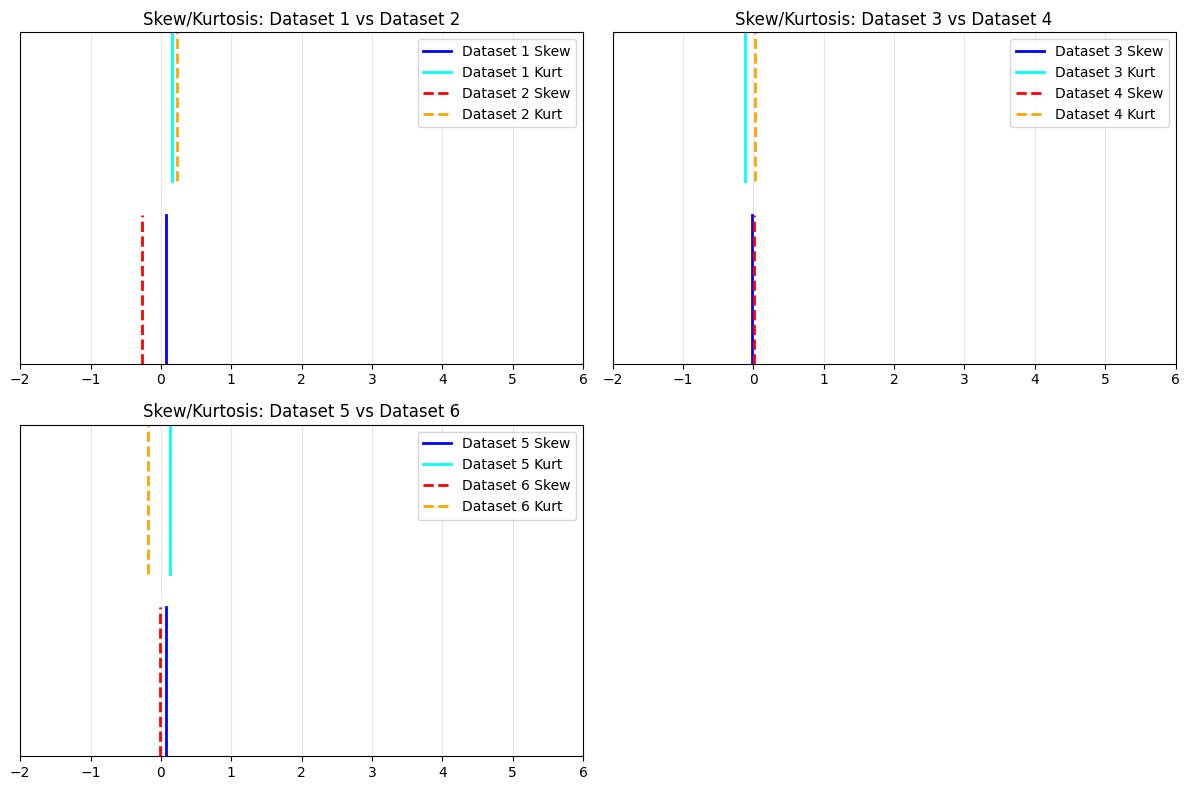

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis

def plot_skew_kurtosis_pairs(data_groups, labels=None, xdim_min=-2, xdim_max=6):
    """
    画多个 group 的偏度和峰度图，每个 subplot 显示两个 group 的 skew/kurtosis
    
    Parameters:
    data_groups: list of 1D arrays
    labels: group names
    """
    if labels is None:
        labels = [f"group_{i+1}" for i in range(len(data_groups))]
    
    total_groups = len(data_groups)
    total_subplots = int(np.ceil(total_groups / 2))
    
    cols = int(np.ceil(np.sqrt(total_subplots)))
    rows = int(np.ceil(total_subplots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))

    if total_subplots == 1:
        axes = np.array([axes])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    subplot_idx = 0
    for i in range(0, total_groups, 2):
        row = subplot_idx // cols
        col = subplot_idx % cols
        ax = axes[row, col]
        
        # first group
        data1 = np.array(data_groups[i])
        s1 = skew(data1)
        k1 = kurtosis(data1)
        
        ax.axvline(s1, ymin=0, ymax=0.45, color="blue", linewidth=2, label=f"{labels[i]} Skew")
        ax.axvline(k1, ymin=0.55, ymax=1.0, color="cyan", linewidth=2, label=f"{labels[i]} Kurt")

        # second group exists?
        if i + 1 < total_groups:
            data2 = np.array(data_groups[i+1])
            s2 = skew(data2)
            k2 = kurtosis(data2)
            
            ax.axvline(s2, ymin=0, ymax=0.45, color="red", linewidth=2, linestyle="--", label=f"{labels[i+1]} Skew")
            ax.axvline(k2, ymin=0.55, ymax=1.0, color="orange", linewidth=2, linestyle="--", label=f"{labels[i+1]} Kurt")

        ax.set_xlim(xdim_min, xdim_max)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        
        ax.set_title(f"Skew/Kurtosis: {labels[i]} vs {labels[i+1] if i+1 < total_groups else 'N/A'}")
        ax.grid(alpha=0.3)
        ax.legend()

        subplot_idx += 1

    # hide unused subplots
    for idx in range(subplot_idx, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()


# Example: 6 groups
data_groups = [np.random.normal(loc=i, scale=1+i*0.2, size=500) for i in range(6)]
labels = [f"Dataset {i+1}" for i in range(6)]

plot_skew_kurtosis_pairs(data_groups, labels)


In [13]:
!pip install -U scikit-learn scipy matplotlib

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 14.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 16.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 97.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.3
    Uninstalling matplotlib-3.10.3:
      Successfully uninstalled matplotlib-3.10.3


In [14]:
import numpy as np
import sklearn
from scipy.stats import pearsonr, spearmanr, ks_2samp
from scipy.stats import wasserstein_distance
from sklearn.feature_selection import mutual_info_regression
import pandas as pd


# ---------- CKA helpers ----------
def gram_linear(x):
    return x @ x.T

def center_gram(g):
    n = g.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ g @ H

def cka_score(x, y):
    # x, y shape: (num_samples,)
    # reshape to (samples, 1 neuron) so CKA can run
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    K = center_gram(gram_linear(x))
    L = center_gram(gram_linear(y))

    hsic = np.sum(K * L)
    norm = np.sqrt(np.sum(K * K) * np.sum(L * L))

    return hsic / norm


# ---------- Top-K overlap ----------
def topk_overlap(x, y, k=50):
    idx_x = np.argsort(x)[-k:]
    idx_y = np.argsort(y)[-k:]
    return len(set(idx_x) & set(idx_y)) / k



# ============================================================
#                    主函数：扩展版
# ============================================================
def compute_column_correlations(matrix1, matrix2, method='pearson', topk=50):
    """
    支持以下 method：
      - pearson
      - spearman
      - cosine
      - mi               (mutual information)
      - cka
      - wasserstein
      - ks               (Kolmogorov-Smirnov)
      - topk             (top-k neuron overlap rate)
    """

    # Convert to numpy arrays if they are DataFrames
    if isinstance(matrix1, pd.DataFrame):
        matrix1 = matrix1.values
    if isinstance(matrix2, pd.DataFrame):
        matrix2 = matrix2.values
    
    assert matrix1.shape[1] == matrix2.shape[1], "Matrices must have the same number of columns"

    n_cols = matrix1.shape[1]
    correlations = np.zeros(n_cols)
    p_values = np.zeros(n_cols)

    print(matrix1.shape, matrix2.shape)

    for i in range(n_cols):
        v1 = matrix1[:, i]
        v2 = matrix2[:, i]

        # 1. Pearson
        if method == 'pearson':
            corr, p = pearsonr(v1, v2)
            correlations[i] = corr
            p_values[i] = p

        # 2. Spearman
        elif method == 'spearman':
            corr, p = spearmanr(v1, v2)
            correlations[i] = corr
            p_values[i] = p

        # 3. Cosine similarity
        elif method == 'cosine':
            correlations[i] = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            p_values[i] = np.nan

        # 4. Mutual information
        elif method == 'mi':
            correlations[i] = mutual_info_regression(v1.reshape(-1, 1), v2)[0]
            p_values[i] = np.nan

        # 5. CKA
        elif method == 'cka':
            correlations[i] = cka_score(v1, v2)
            p_values[i] = np.nan

        # 6. Wasserstein (distribution distance)
        elif method == 'wasserstein':
            correlations[i] = -wasserstein_distance(v1, v2)  
            # 越大越好，所以取负
            p_values[i] = np.nan

        # 7. KS-test
        elif method == 'ks':
            stat, p = ks_2samp(v1, v2)
            correlations[i] = -stat  
            # 越接近 0 越相似，这里取负表示"相似度"
            p_values[i] = p

        # 8. Top-K neuron overlap
        elif method == 'topk':
            correlations[i] = topk_overlap(v1, v2, k=topk)
            p_values[i] = np.nan

        else:
            raise ValueError(f"Unknown method: {method}")

    return correlations, p_values


In [15]:
def calc_per_neu_pvalue(data1, data2, method='pearson'):
    '''
    对每种语言，计算每个神经元的均值/方差

    '''
    result={}

    bar = tqdm(total=len(data1.keys()))

    for ikey in data1.keys():
        if "layers" not in ikey: continue
        # mean & var dict
        result[ikey]={}

        
        result[ikey]['p'] = compute_column_correlations(
            np.array([itmp.float().numpy().tolist() for itmp in data1[ikey] ]),
            np.array([itmp.float().numpy().tolist() for itmp in data2[ikey] ]),
            method= method

        )
                


        bar.update(1)
        
    return result
        

In [16]:
import numpy as np
from scipy.stats import skew, kurtosis

def compute_skew_kurtosis(matrix):
    """
    对每一列计算偏度、峰度
    matrix shape: (num_samples, num_neurons)

    return:
        skewness: shape (num_neurons,)
        kurt:     shape (num_neurons,)
    """
    skewness = skew(matrix, axis=0, bias=False)
    kurt_vals = kurtosis(matrix, axis=0, bias=False)  # Fisher=True 默认，峰度=0为正态分布

    return skewness, kurt_vals

In [17]:
def calc_skew_kurtosis(data1):
    '''
    计算神经元的，偏度和峰度

    '''
    result={}

    bar = tqdm(total=len(data1.keys()))

    for ikey in data1.keys():
        if "layers" not in ikey: continue
        # mean & var dict
        result[ikey]={}

        
        result[ikey]['skewness'],  result[ikey]['kurt_vals'] = compute_skew_kurtosis(
            np.array([itmp.float().numpy().tolist() for itmp in data1[ikey] ]),
        )
                


        bar.update(1)
        
    return result


    

    

# 20251113

In [18]:
import torch

In [19]:
data_path='/root/autodl-fs/output_grad/gemma-3-1b-it/en/lrp.pt'

In [20]:
data = torch.load(data_path, map_location=torch.device('cpu'))



In [21]:
data_vi = torch.load('/root/autodl-fs/output_grad/gemma-3-1b-it/vi/lrp.pt', map_location=torch.device('cpu'))

In [22]:
data_zh = torch.load('/root/autodl-fs/output_grad/gemma-3-1b-it/zh/lrp.pt', map_location=torch.device('cpu'))

In [23]:
data_neu_result = calc_per_neu_mean(data)
data_vi_neu_result = calc_per_neu_mean(data_vi)

In [24]:
mean_diff=calc_mean_var_diff(data_vi_neu_result, data_neu_result)

In [25]:
data_neu_all_mean = []
data_vi_neu_all_mean = []

for ikey in data_neu_result.keys():
    data_neu_all_mean.extend(data_neu_result[ikey]['mean'])
    data_vi_neu_all_mean.extend(data_vi_neu_result[ikey]['mean'])

    

In [26]:
data_neu_all_var = []
data_vi_neu_all_var = []

for ikey in data_neu_result.keys():
    data_neu_all_var.extend(data_neu_result[ikey]['var'])
    data_vi_neu_all_var.extend(data_vi_neu_result[ikey]['var'])

    

In [27]:
'''
均值diff的分布范围

'''

'\n均值diff的分布范围\n\n'

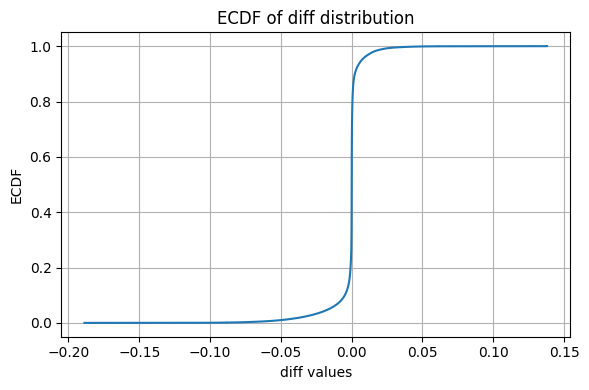

In [28]:
drwa_ecdf(np.array(mean_diff))

In [ ]:
plot_ecdf_groups([
                    #np.array(mean_diff), 
                    #data_neu_result['model.layers.6.mlp.down_proj.weight']['mean'],
                    #data_vi_neu_result['model.layers.6.mlp.down_proj.weight']['mean'],
                    data_neu_all_mean,
                    data_vi_neu_all_mean
                 ], 
                 labels=[
                     #'all_mean_diff', 
                     #'en_s_key_mean',
                     #'vi_s_key_mean', 
                     'en_all_mean', 'vi_all_mean'])

In [ ]:
data_neu_enAvi_result_per_layer = []
data_neu_enAvi_result_per_layer_labels = []

for ilayer in range(26):
    data_neu_enAvi_result_per_layer.append(data_neu_result[f'model.layers.{ilayer}.mlp.down_proj.weight']['mean'])
    data_neu_enAvi_result_per_layer.append(data_vi_neu_result[f'model.layers.{ilayer}.mlp.down_proj.weight']['mean'])

    data_neu_enAvi_result_per_layer_labels.append(f'en_s_key_mean_layer{ilayer}')
    data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_mean_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels)

### 按层其值的范围变化

### 偏度和峰度

In [ ]:
from tqdm import tqdm

In [ ]:
data_neu_result_skew_kur = calc_skew_kurtosis(data)
data_vi_neu_result_skew_kur = calc_skew_kurtosis(data_vi)

In [ ]:
data_neu_result_skew_kur['model.layers.0.self_attn.k_proj.weight']['skewness'].shape

In [ ]:
'''
偏度

'''
data_neu_enAvi_result_per_layer = []
data_neu_enAvi_result_per_layer_labels = []

for ilayer in range(26):

    en_result_tmp = []
    vi_result_tmp = []
    for ikey in data_neu_result.keys():
        if f'layers.{ilayer}' in ikey:
            en_result_tmp.extend(data_neu_result_skew_kur[ikey]['skewness'])
            vi_result_tmp.extend(data_vi_neu_result_skew_kur[ikey]['skewness'])
    
    
    data_neu_enAvi_result_per_layer.append(en_result_tmp)
    data_neu_enAvi_result_per_layer.append(vi_result_tmp)

    data_neu_enAvi_result_per_layer_labels.append(f'en_s_key_skew_kur_layer{ilayer}')
    data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_skew_kur_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max=10, xdim_min=-10)

In [ ]:
'''
峰度

'''
data_neu_enAvi_result_per_layer = []
data_neu_enAvi_result_per_layer_labels = []

for ilayer in range(26):

    en_result_tmp = []
    vi_result_tmp = []
    for ikey in data_neu_result.keys():
        if f'layers.{ilayer}' in ikey:
            en_result_tmp.extend(data_neu_result_skew_kur[ikey]['kurt_vals'])
            vi_result_tmp.extend(data_vi_neu_result_skew_kur[ikey]['kurt_vals'])
    
    
    data_neu_enAvi_result_per_layer.append(en_result_tmp)
    data_neu_enAvi_result_per_layer.append(vi_result_tmp)

    data_neu_enAvi_result_per_layer_labels.append(f'en_s_key_skew_kur_layer{ilayer}')
    data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_skew_kur_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max=100, xdim_min=-10)

### en和vi的神经元的偏度和峰度差值的gap

In [ ]:
max(data_neu_result_skew_kur['model.layers.0.self_attn.q_proj.weight']['skewness'])

In [ ]:
max(data_neu_result_skew_kur['model.layers.0.self_attn.q_proj.weight']['kurt_vals'])

In [ ]:
max(data_vi_neu_result_skew_kur['model.layers.0.self_attn.q_proj.weight']['kurt_vals'])

In [ ]:
max(data_vi_neu_result_skew_kur['model.layers.0.self_attn.q_proj.weight']['skewness'])

In [ ]:
'''
峰度--gap

'''
data_neu_enAvi_result_per_layer = []
data_neu_enAvi_result_per_layer_labels = []

for ilayer in range(26):

    en_result_tmp = []
    vi_result_tmp = []
    for ikey in data_neu_result.keys():
        if f'layers.{ilayer}' in ikey:
            en_result_tmp.extend(data_neu_result_skew_kur[ikey]['kurt_vals']- data_vi_neu_result_skew_kur[ikey]['kurt_vals'] )
            #vi_result_tmp.extend(data_vi_neu_result_skew_kur[ikey]['kurt_vals'])
    
    
    data_neu_enAvi_result_per_layer.append(en_result_tmp)
    data_neu_enAvi_result_per_layer.append(en_result_tmp)
    #data_neu_enAvi_result_per_layer.append(vi_result_tmp)

    data_neu_enAvi_result_per_layer_labels.append(f'enAvi_s_key__kur_gap_layer{ilayer}')
    data_neu_enAvi_result_per_layer_labels.append(f'enAvi_s_key__kur_gap_layer{ilayer}')
    #data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_skew_kur_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max=100, xdim_min=-10)

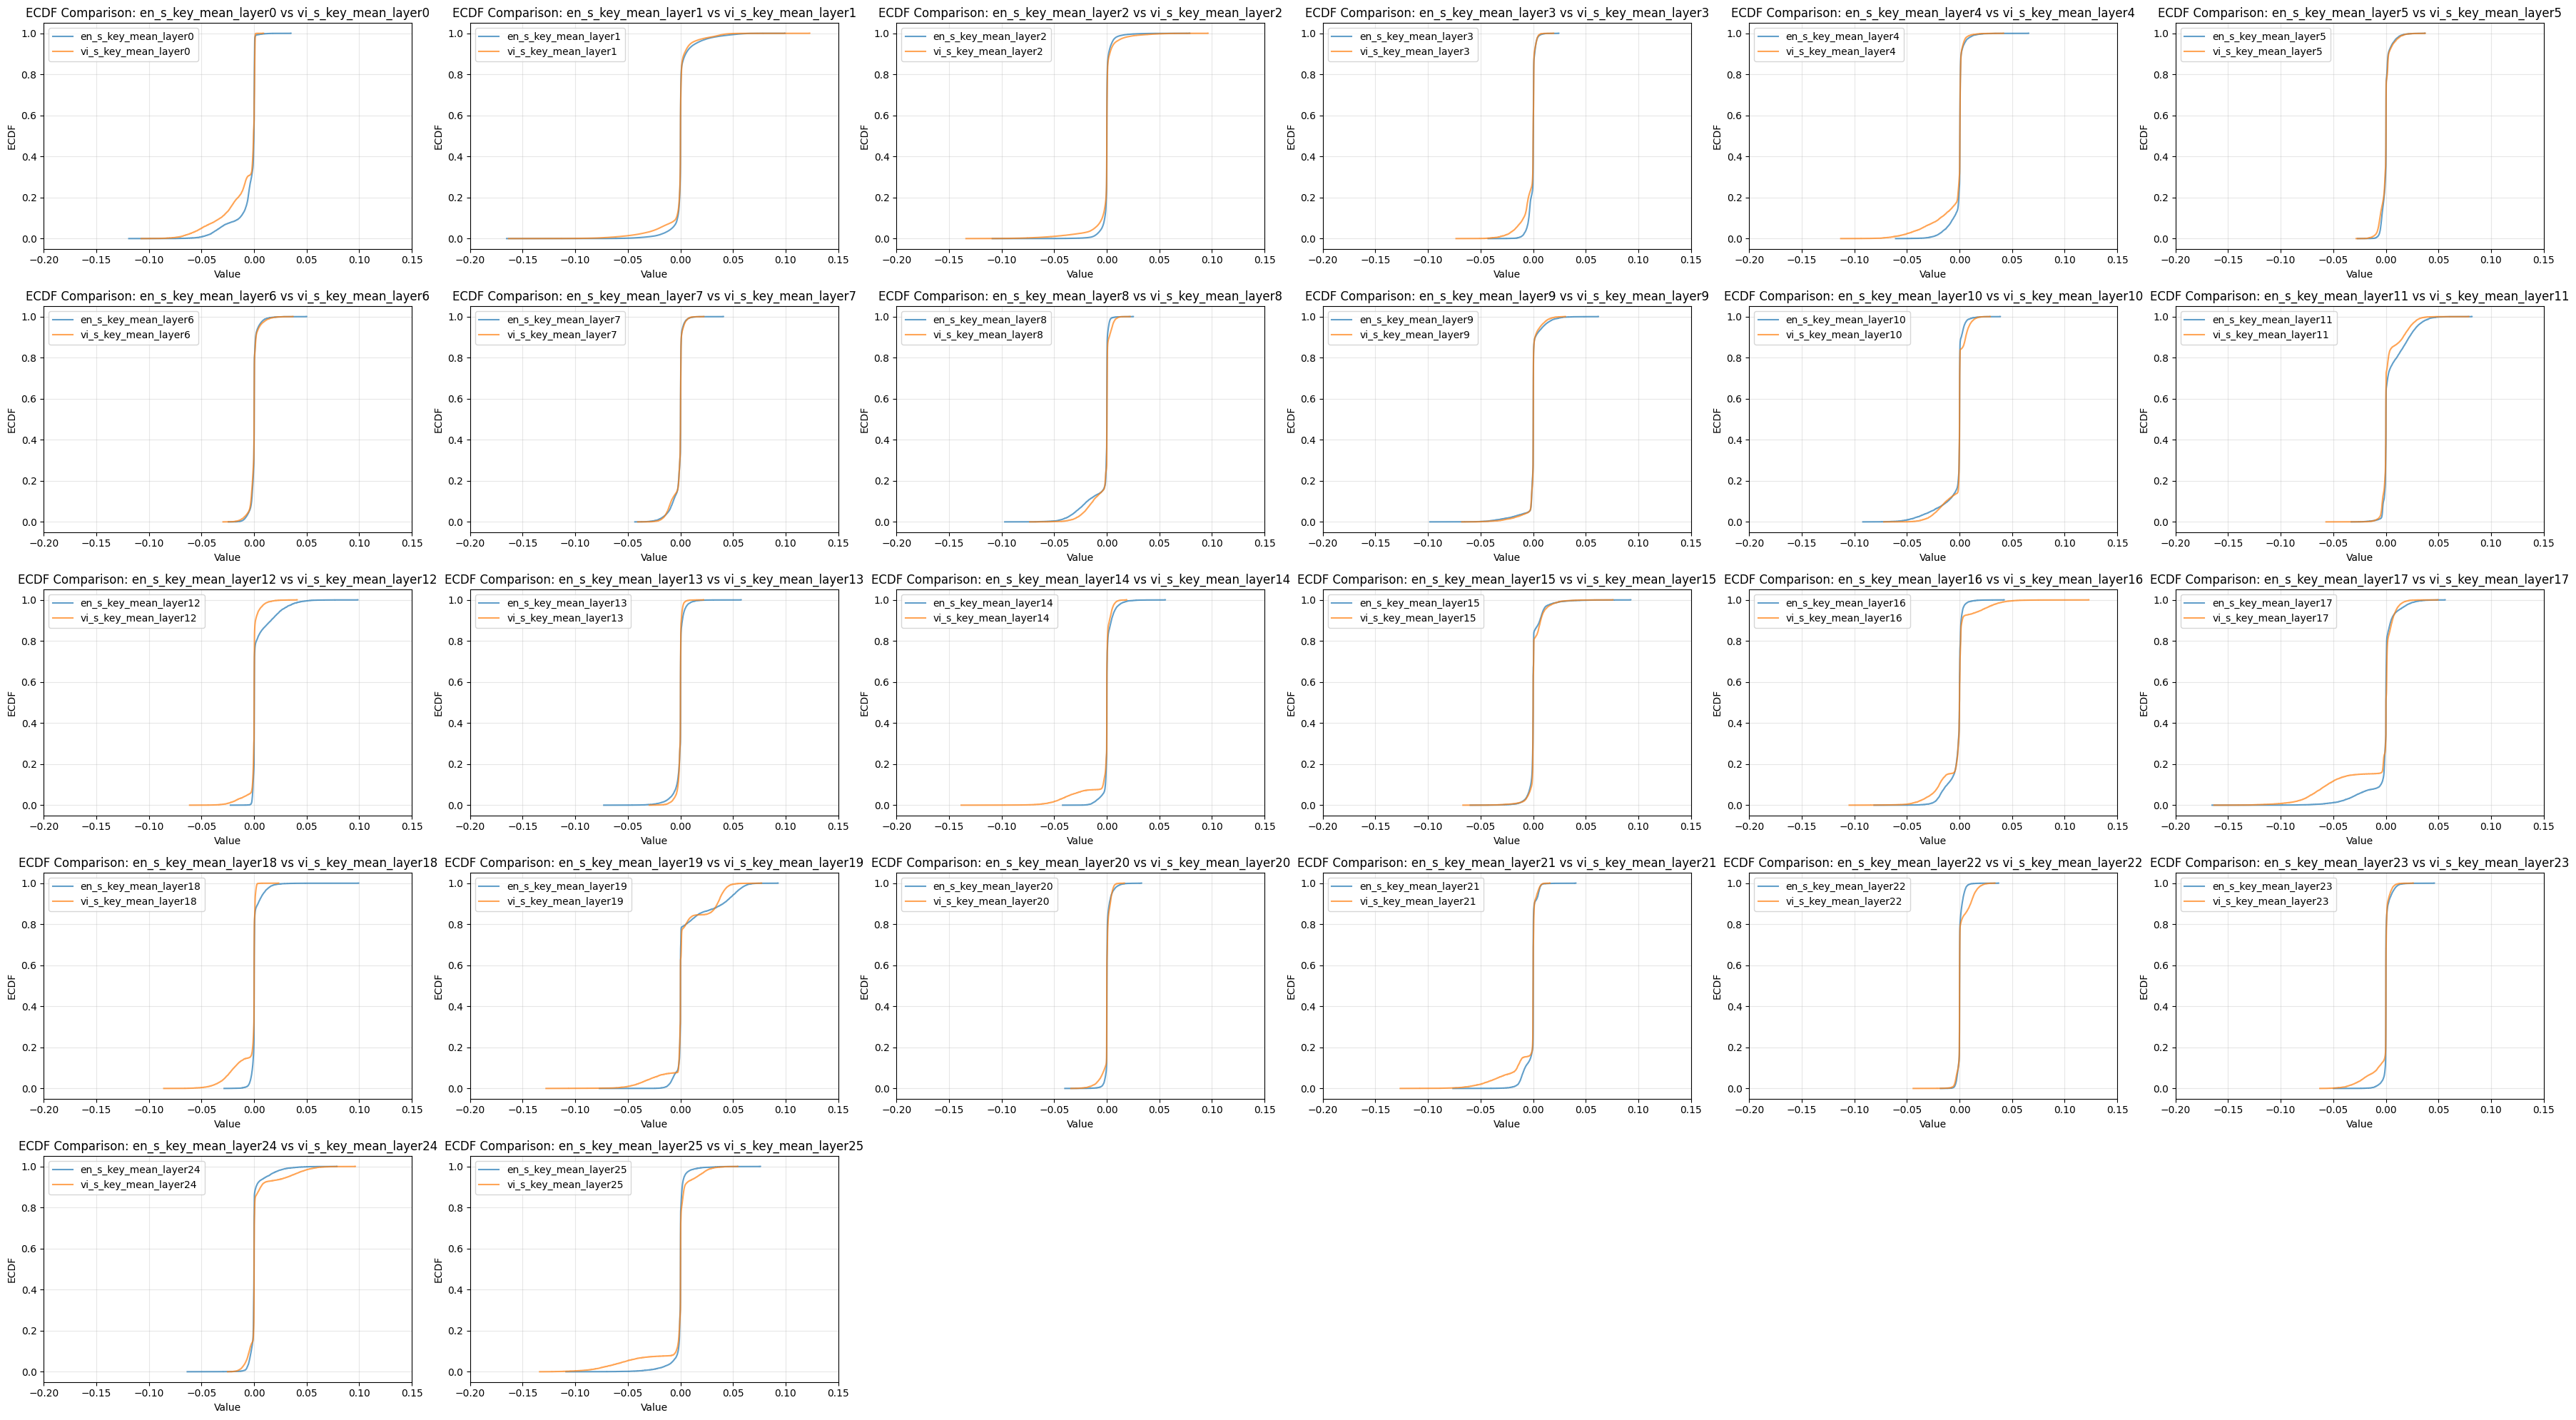

In [27]:
data_neu_enAvi_result_per_layer = []
data_neu_enAvi_result_per_layer_labels = []

for ilayer in range(26):

    en_result_tmp = []
    vi_result_tmp = []
    for ikey in data_neu_result.keys():
        if f'layers.{ilayer}' in ikey:
            en_result_tmp.extend(data_neu_result[ikey]['mean'])
            vi_result_tmp.extend(data_vi_neu_result[ikey]['mean'])
    
    
    data_neu_enAvi_result_per_layer.append(en_result_tmp)
    data_neu_enAvi_result_per_layer.append(vi_result_tmp)

    data_neu_enAvi_result_per_layer_labels.append(f'en_s_key_mean_layer{ilayer}')
    data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_mean_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels)

In [ ]:
TODO  每个key的范围的差别？？？？？

## 计算相关性

In [28]:
result_relation = calc_per_neu_pvalue(data, data_vi)

  0%|          | 0/340 [00:00<?, ?it/s]

(1000, 262144) (1000, 262144)


/tmp/ipykernel_989/3442345701.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = pearsonr(matrix1[:, i], matrix2[:, i])
  0%|          | 1/340 [01:47<10:08:36, 107.72s/it]

(1000, 1024) (1000, 1024)


  1%|          | 4/340 [01:48<1:22:30, 14.73s/it]  

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


  2%|▏         | 6/340 [01:48<35:23,  6.36s/it]  

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


  2%|▏         | 8/340 [01:51<21:33,  3.89s/it]

(1000, 6912) (1000, 6912)


  3%|▎         | 9/340 [01:54<19:41,  3.57s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 10/340 [01:54<14:57,  2.72s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 11/340 [01:55<11:23,  2.08s/it]

(1000, 1152) (1000, 1152)


  4%|▎         | 12/340 [01:55<08:45,  1.60s/it]

(1000, 1152) (1000, 1152)


  4%|▍         | 13/340 [01:55<06:51,  1.26s/it]

(1000, 1152) (1000, 1152)


  4%|▍         | 14/340 [01:56<05:28,  1.01s/it]

(1000, 1024) (1000, 1024)


  5%|▌         | 17/340 [01:56<02:38,  2.04it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


  6%|▌         | 20/340 [01:57<01:40,  3.17it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


  6%|▌         | 21/340 [02:00<04:24,  1.21it/s]

(1000, 6912) (1000, 6912)


  6%|▋         | 22/340 [02:02<06:42,  1.27s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 23/340 [02:03<05:35,  1.06s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 24/340 [02:03<04:42,  1.12it/s]

(1000, 1152) (1000, 1152)


  7%|▋         | 25/340 [02:04<04:02,  1.30it/s]

(1000, 1152) (1000, 1152)


  8%|▊         | 26/340 [02:04<03:33,  1.47it/s]

(1000, 1152) (1000, 1152)


  8%|▊         | 27/340 [02:04<03:10,  1.64it/s]

(1000, 1024) (1000, 1024)


  9%|▉         | 30/340 [02:05<01:39,  3.10it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


  9%|▉         | 32/340 [02:06<01:26,  3.57it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 10%|█         | 34/340 [02:08<04:00,  1.27it/s]

(1000, 6912) (1000, 6912)


 10%|█         | 35/340 [02:11<06:24,  1.26s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 36/340 [02:11<05:16,  1.04s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 37/340 [02:12<04:25,  1.14it/s]

(1000, 1152) (1000, 1152)


 11%|█         | 38/340 [02:12<03:48,  1.32it/s]

(1000, 1152) (1000, 1152)


 11%|█▏        | 39/340 [02:13<03:18,  1.52it/s]

(1000, 1152) (1000, 1152)


 12%|█▏        | 40/340 [02:13<02:58,  1.68it/s]

(1000, 1024) (1000, 1024)


 12%|█▏        | 42/340 [02:14<02:00,  2.47it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 14%|█▎        | 46/340 [02:14<01:12,  4.07it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 14%|█▍        | 47/340 [02:17<03:53,  1.25it/s]

(1000, 6912) (1000, 6912)


 14%|█▍        | 48/340 [02:20<06:07,  1.26s/it]

(1000, 1152) (1000, 1152)


 14%|█▍        | 49/340 [02:20<05:05,  1.05s/it]

(1000, 1152) (1000, 1152)


 15%|█▍        | 50/340 [02:21<04:17,  1.13it/s]

(1000, 1152) (1000, 1152)


 15%|█▌        | 51/340 [02:21<03:42,  1.30it/s]

(1000, 1152) (1000, 1152)


 15%|█▌        | 52/340 [02:22<03:13,  1.49it/s]

(1000, 1152) (1000, 1152)


 16%|█▌        | 53/340 [02:22<02:52,  1.67it/s]

(1000, 1024) (1000, 1024)


 16%|█▋        | 56/340 [02:23<01:36,  2.95it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 17%|█▋        | 59/340 [02:23<01:10,  3.98it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 18%|█▊        | 60/340 [02:26<03:40,  1.27it/s]

(1000, 6912) (1000, 6912)


 18%|█▊        | 61/340 [02:28<05:40,  1.22s/it]

(1000, 1152) (1000, 1152)


 18%|█▊        | 62/340 [02:29<04:41,  1.01s/it]

(1000, 1152) (1000, 1152)


 19%|█▊        | 63/340 [02:29<03:56,  1.17it/s]

(1000, 1152) (1000, 1152)


 19%|█▉        | 64/340 [02:30<03:23,  1.36it/s]

(1000, 1152) (1000, 1152)


 19%|█▉        | 65/340 [02:30<02:59,  1.53it/s]

(1000, 1152) (1000, 1152)


 19%|█▉        | 66/340 [02:31<02:39,  1.72it/s]

(1000, 1024) (1000, 1024)


 20%|██        | 69/340 [02:31<01:27,  3.09it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 21%|██        | 72/340 [02:32<01:04,  4.16it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 21%|██▏       | 73/340 [02:34<03:28,  1.28it/s]

(1000, 6912) (1000, 6912)


 22%|██▏       | 74/340 [02:37<05:30,  1.24s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 75/340 [02:37<04:32,  1.03s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 76/340 [02:38<03:48,  1.16it/s]

(1000, 1152) (1000, 1152)


 23%|██▎       | 77/340 [02:38<03:14,  1.35it/s]

(1000, 1152) (1000, 1152)


 23%|██▎       | 78/340 [02:39<02:50,  1.54it/s]

(1000, 1152) (1000, 1152)


 23%|██▎       | 79/340 [02:39<02:31,  1.72it/s]

(1000, 1024) (1000, 1024)


 24%|██▍       | 82/340 [02:40<01:23,  3.09it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 25%|██▌       | 85/340 [02:40<01:02,  4.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 25%|██▌       | 86/340 [02:43<03:15,  1.30it/s]

(1000, 6912) (1000, 6912)


 26%|██▌       | 87/340 [02:45<05:07,  1.22s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 88/340 [02:46<04:14,  1.01s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 89/340 [02:46<03:34,  1.17it/s]

(1000, 1152) (1000, 1152)


 26%|██▋       | 90/340 [02:47<03:02,  1.37it/s]

(1000, 1152) (1000, 1152)


 27%|██▋       | 91/340 [02:47<02:39,  1.56it/s]

(1000, 1152) (1000, 1152)


 27%|██▋       | 92/340 [02:47<02:22,  1.74it/s]

(1000, 1024) (1000, 1024)


 28%|██▊       | 95/340 [02:48<01:16,  3.21it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 29%|██▉       | 98/340 [02:49<00:56,  4.27it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 29%|██▉       | 99/340 [02:51<03:26,  1.17it/s]

(1000, 6912) (1000, 6912)


 29%|██▉       | 100/340 [02:54<05:23,  1.35s/it]

(1000, 1152) (1000, 1152)


 30%|██▉       | 101/340 [02:55<04:24,  1.11s/it]

(1000, 1152) (1000, 1152)


 30%|███       | 102/340 [02:55<03:39,  1.08it/s]

(1000, 1152) (1000, 1152)


 30%|███       | 103/340 [02:56<03:04,  1.28it/s]

(1000, 1152) (1000, 1152)


 31%|███       | 104/340 [02:56<02:41,  1.46it/s]

(1000, 1152) (1000, 1152)


 31%|███       | 105/340 [02:56<02:24,  1.63it/s]

(1000, 1024) (1000, 1024)


 32%|███▏      | 108/340 [02:57<01:19,  2.92it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 33%|███▎      | 111/340 [02:58<00:58,  3.94it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 33%|███▎      | 112/340 [03:00<03:02,  1.25it/s]

(1000, 6912) (1000, 6912)


 33%|███▎      | 113/340 [03:03<04:42,  1.24s/it]

(1000, 1152) (1000, 1152)


 34%|███▎      | 114/340 [03:03<03:53,  1.03s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 115/340 [03:04<03:15,  1.15it/s]

(1000, 1152) (1000, 1152)


 34%|███▍      | 116/340 [03:04<02:47,  1.34it/s]

(1000, 1152) (1000, 1152)


 34%|███▍      | 117/340 [03:05<02:24,  1.54it/s]

(1000, 1152) (1000, 1152)


 35%|███▍      | 118/340 [03:05<02:08,  1.73it/s]

(1000, 1024) (1000, 1024)


 36%|███▌      | 121/340 [03:06<01:11,  3.06it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 36%|███▋      | 124/340 [03:06<00:53,  4.05it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 37%|███▋      | 125/340 [03:09<02:52,  1.24it/s]

(1000, 6912) (1000, 6912)


 37%|███▋      | 126/340 [03:12<04:28,  1.25s/it]

(1000, 1152) (1000, 1152)


 37%|███▋      | 127/340 [03:12<03:40,  1.04s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 128/340 [03:12<03:05,  1.14it/s]

(1000, 1152) (1000, 1152)


 38%|███▊      | 129/340 [03:13<02:37,  1.34it/s]

(1000, 1152) (1000, 1152)


 38%|███▊      | 130/340 [03:13<02:15,  1.54it/s]

(1000, 1152) (1000, 1152)


 39%|███▊      | 131/340 [03:14<02:01,  1.72it/s]

(1000, 1024) (1000, 1024)


 39%|███▉      | 134/340 [03:14<01:08,  3.02it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 40%|████      | 137/340 [03:15<00:50,  4.01it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 41%|████      | 138/340 [03:17<02:39,  1.27it/s]

(1000, 6912) (1000, 6912)


 41%|████      | 139/340 [03:20<04:06,  1.23s/it]

(1000, 1152) (1000, 1152)


 41%|████      | 140/340 [03:20<03:23,  1.02s/it]

(1000, 1152) (1000, 1152)


 41%|████▏     | 141/340 [03:21<02:51,  1.16it/s]

(1000, 1152) (1000, 1152)


 42%|████▏     | 142/340 [03:21<02:26,  1.35it/s]

(1000, 1152) (1000, 1152)


 42%|████▏     | 143/340 [03:22<02:07,  1.54it/s]

(1000, 1152) (1000, 1152)


 42%|████▏     | 144/340 [03:22<01:54,  1.71it/s]

(1000, 1024) (1000, 1024)


 43%|████▎     | 147/340 [03:23<01:02,  3.07it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 44%|████▍     | 150/340 [03:23<00:46,  4.10it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 44%|████▍     | 151/340 [03:26<02:27,  1.28it/s]

(1000, 6912) (1000, 6912)


 45%|████▍     | 152/340 [03:29<03:51,  1.23s/it]

(1000, 1152) (1000, 1152)


 45%|████▌     | 153/340 [03:29<03:10,  1.02s/it]

(1000, 1152) (1000, 1152)


 45%|████▌     | 154/340 [03:29<02:38,  1.18it/s]

(1000, 1152) (1000, 1152)


 46%|████▌     | 155/340 [03:30<02:14,  1.38it/s]

(1000, 1152) (1000, 1152)


 46%|████▌     | 156/340 [03:30<01:56,  1.58it/s]

(1000, 1152) (1000, 1152)


 46%|████▌     | 157/340 [03:31<01:44,  1.76it/s]

(1000, 1024) (1000, 1024)


 47%|████▋     | 160/340 [03:31<00:57,  3.13it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 48%|████▊     | 163/340 [03:32<00:42,  4.21it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 48%|████▊     | 164/340 [03:34<02:17,  1.28it/s]

(1000, 6912) (1000, 6912)


 49%|████▊     | 165/340 [03:37<03:41,  1.27s/it]

(1000, 1152) (1000, 1152)


 49%|████▉     | 166/340 [03:38<03:02,  1.05s/it]

(1000, 1152) (1000, 1152)


 49%|████▉     | 167/340 [03:38<02:32,  1.14it/s]

(1000, 1152) (1000, 1152)


 49%|████▉     | 168/340 [03:38<02:11,  1.31it/s]

(1000, 1152) (1000, 1152)


 50%|████▉     | 169/340 [03:39<01:53,  1.50it/s]

(1000, 1152) (1000, 1152)


 50%|█████     | 170/340 [03:39<01:42,  1.66it/s]

(1000, 1024) (1000, 1024)


 51%|█████     | 172/340 [03:40<01:12,  2.33it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 51%|█████     | 173/340 [03:40<00:58,  2.87it/s]

(1000, 1152) (1000, 1152)


 51%|█████▏    | 175/340 [03:41<00:59,  2.78it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 52%|█████▏    | 176/340 [03:41<00:49,  3.34it/s]

(1000, 6912) (1000, 6912)


 52%|█████▏    | 177/340 [03:44<03:15,  1.20s/it]

(1000, 6912) (1000, 6912)


 52%|█████▏    | 178/340 [03:47<04:24,  1.63s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 179/340 [03:47<03:24,  1.27s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 180/340 [03:48<02:42,  1.02s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 181/340 [03:48<02:13,  1.19it/s]

(1000, 1152) (1000, 1152)


 54%|█████▎    | 182/340 [03:49<01:53,  1.40it/s]

(1000, 1152) (1000, 1152)


 54%|█████▍    | 183/340 [03:49<01:38,  1.59it/s]

(1000, 1024) (1000, 1024)


 55%|█████▍    | 186/340 [03:50<00:52,  2.93it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 56%|█████▌    | 189/340 [03:50<00:37,  4.01it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 56%|█████▌    | 190/340 [03:53<01:58,  1.27it/s]

(1000, 6912) (1000, 6912)


 56%|█████▌    | 191/340 [03:56<03:06,  1.25s/it]

(1000, 1152) (1000, 1152)


 56%|█████▋    | 192/340 [03:56<02:32,  1.03s/it]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 193/340 [03:56<02:07,  1.15it/s]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 194/340 [03:57<01:47,  1.36it/s]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 195/340 [03:57<01:33,  1.56it/s]

(1000, 1152) (1000, 1152)


 58%|█████▊    | 196/340 [03:58<01:23,  1.72it/s]

(1000, 1024) (1000, 1024)


 59%|█████▊    | 199/340 [03:58<00:46,  3.06it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 59%|█████▉    | 202/340 [03:59<00:33,  4.11it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 60%|█████▉    | 203/340 [04:01<01:45,  1.29it/s]

(1000, 6912) (1000, 6912)


 60%|██████    | 204/340 [04:04<02:45,  1.22s/it]

(1000, 1152) (1000, 1152)


 60%|██████    | 205/340 [04:04<02:16,  1.01s/it]

(1000, 1152) (1000, 1152)


 61%|██████    | 206/340 [04:05<01:53,  1.18it/s]

(1000, 1152) (1000, 1152)


 61%|██████    | 207/340 [04:05<01:36,  1.38it/s]

(1000, 1152) (1000, 1152)


 61%|██████    | 208/340 [04:06<01:23,  1.58it/s]

(1000, 1152) (1000, 1152)


 61%|██████▏   | 209/340 [04:06<01:15,  1.74it/s]

(1000, 1024) (1000, 1024)


 62%|██████▏   | 212/340 [04:07<00:41,  3.07it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 63%|██████▎   | 215/340 [04:07<00:30,  4.09it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 64%|██████▎   | 216/340 [04:10<01:36,  1.29it/s]

(1000, 6912) (1000, 6912)


 64%|██████▍   | 217/340 [04:12<02:31,  1.23s/it]

(1000, 1152) (1000, 1152)


 64%|██████▍   | 218/340 [04:13<02:04,  1.02s/it]

(1000, 1152) (1000, 1152)


 64%|██████▍   | 219/340 [04:13<01:43,  1.17it/s]

(1000, 1152) (1000, 1152)


 65%|██████▍   | 220/340 [04:14<01:27,  1.38it/s]

(1000, 1152) (1000, 1152)


 65%|██████▌   | 221/340 [04:14<01:15,  1.57it/s]

(1000, 1152) (1000, 1152)


 65%|██████▌   | 222/340 [04:14<01:07,  1.76it/s]

(1000, 1024) (1000, 1024)


 66%|██████▌   | 225/340 [04:15<00:36,  3.12it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 67%|██████▋   | 228/340 [04:16<00:27,  4.10it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 67%|██████▋   | 229/340 [04:18<01:25,  1.30it/s]

(1000, 6912) (1000, 6912)


 68%|██████▊   | 230/340 [04:21<02:14,  1.22s/it]

(1000, 1152) (1000, 1152)


 68%|██████▊   | 231/340 [04:21<01:50,  1.01s/it]

(1000, 1152) (1000, 1152)


 68%|██████▊   | 232/340 [04:22<01:32,  1.17it/s]

(1000, 1152) (1000, 1152)


 69%|██████▊   | 233/340 [04:22<01:18,  1.37it/s]

(1000, 1152) (1000, 1152)


 69%|██████▉   | 234/340 [04:22<01:08,  1.55it/s]

(1000, 1152) (1000, 1152)


 69%|██████▉   | 235/340 [04:23<01:00,  1.73it/s]

(1000, 1024) (1000, 1024)


 70%|███████   | 238/340 [04:23<00:33,  3.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 71%|███████   | 241/340 [04:24<00:23,  4.25it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 71%|███████   | 242/340 [04:27<01:27,  1.12it/s]

(1000, 6912) (1000, 6912)


 71%|███████▏  | 243/340 [04:29<02:15,  1.40s/it]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 244/340 [04:30<01:47,  1.12s/it]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 245/340 [04:30<01:27,  1.09it/s]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 246/340 [04:31<01:12,  1.29it/s]

(1000, 1152) (1000, 1152)


 73%|███████▎  | 247/340 [04:31<01:02,  1.49it/s]

(1000, 1152) (1000, 1152)


 73%|███████▎  | 248/340 [04:31<00:55,  1.66it/s]

(1000, 1024) (1000, 1024)


 74%|███████▍  | 251/340 [04:32<00:29,  3.01it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 74%|███████▍  | 253/340 [04:33<00:24,  3.50it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 75%|███████▌  | 255/340 [04:35<01:01,  1.37it/s]

(1000, 6912) (1000, 6912)


 75%|███████▌  | 256/340 [04:38<01:37,  1.17s/it]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 257/340 [04:38<01:21,  1.02it/s]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 258/340 [04:39<01:07,  1.21it/s]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 259/340 [04:39<00:57,  1.40it/s]

(1000, 1152) (1000, 1152)


 76%|███████▋  | 260/340 [04:39<00:50,  1.59it/s]

(1000, 1152) (1000, 1152)


 77%|███████▋  | 261/340 [04:40<00:44,  1.77it/s]

(1000, 1024) (1000, 1024)


 78%|███████▊  | 264/340 [04:40<00:24,  3.09it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 79%|███████▊  | 267/340 [04:41<00:17,  4.15it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 79%|███████▉  | 268/340 [04:44<00:55,  1.29it/s]

(1000, 6912) (1000, 6912)


 79%|███████▉  | 269/340 [04:46<01:26,  1.22s/it]

(1000, 1152) (1000, 1152)


 79%|███████▉  | 270/340 [04:47<01:10,  1.01s/it]

(1000, 1152) (1000, 1152)


 80%|███████▉  | 271/340 [04:47<00:58,  1.18it/s]

(1000, 1152) (1000, 1152)


 80%|████████  | 272/340 [04:47<00:49,  1.37it/s]

(1000, 1152) (1000, 1152)


 80%|████████  | 273/340 [04:48<00:42,  1.58it/s]

(1000, 1152) (1000, 1152)


 81%|████████  | 274/340 [04:48<00:37,  1.76it/s]

(1000, 1024) (1000, 1024)


 81%|████████▏ | 277/340 [04:49<00:19,  3.17it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 82%|████████▏ | 280/340 [04:49<00:14,  4.21it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 83%|████████▎ | 281/340 [04:52<00:45,  1.30it/s]

(1000, 6912) (1000, 6912)


 83%|████████▎ | 282/340 [04:55<01:10,  1.22s/it]

(1000, 1152) (1000, 1152)


 83%|████████▎ | 283/340 [04:55<00:57,  1.01s/it]

(1000, 1152) (1000, 1152)


 84%|████████▎ | 284/340 [04:55<00:47,  1.18it/s]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 285/340 [04:56<00:39,  1.38it/s]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 286/340 [04:56<00:34,  1.59it/s]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 287/340 [04:57<00:29,  1.78it/s]

(1000, 1024) (1000, 1024)


 85%|████████▌ | 290/340 [04:57<00:15,  3.18it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 86%|████████▌ | 293/340 [04:58<00:11,  4.25it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 86%|████████▋ | 294/340 [05:00<00:35,  1.30it/s]

(1000, 6912) (1000, 6912)


 87%|████████▋ | 295/340 [05:03<00:54,  1.22s/it]

(1000, 1152) (1000, 1152)


 87%|████████▋ | 296/340 [05:03<00:44,  1.01s/it]

(1000, 1152) (1000, 1152)


 87%|████████▋ | 297/340 [05:04<00:36,  1.19it/s]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 298/340 [05:04<00:30,  1.38it/s]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 299/340 [05:04<00:26,  1.57it/s]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 300/340 [05:05<00:22,  1.76it/s]

(1000, 1024) (1000, 1024)


 89%|████████▉ | 303/340 [05:05<00:11,  3.17it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 90%|█████████ | 306/340 [05:06<00:07,  4.27it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 90%|█████████ | 307/340 [05:09<00:25,  1.29it/s]

(1000, 6912) (1000, 6912)


 91%|█████████ | 308/340 [05:11<00:39,  1.24s/it]

(1000, 1152) (1000, 1152)


 91%|█████████ | 309/340 [05:12<00:31,  1.02s/it]

(1000, 1152) (1000, 1152)


 91%|█████████ | 310/340 [05:12<00:27,  1.07it/s]

(1000, 1152) (1000, 1152)


 91%|█████████▏| 311/340 [05:13<00:25,  1.15it/s]

(1000, 1152) (1000, 1152)


 92%|█████████▏| 312/340 [05:14<00:22,  1.22it/s]

(1000, 1152) (1000, 1152)


 92%|█████████▏| 313/340 [05:14<00:21,  1.28it/s]

(1000, 1024) (1000, 1024)


 93%|█████████▎| 316/340 [05:15<00:09,  2.46it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 94%|█████████▍| 319/340 [05:16<00:05,  3.70it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 94%|█████████▍| 320/340 [05:18<00:19,  1.05it/s]

(1000, 6912) (1000, 6912)


 94%|█████████▍| 321/340 [05:21<00:27,  1.46s/it]

(1000, 1152) (1000, 1152)


 95%|█████████▍| 322/340 [05:22<00:20,  1.16s/it]

(1000, 1152) (1000, 1152)


 95%|█████████▌| 323/340 [05:22<00:16,  1.06it/s]

(1000, 1152) (1000, 1152)


 95%|█████████▌| 324/340 [05:22<00:12,  1.26it/s]

(1000, 1152) (1000, 1152)


 96%|█████████▌| 325/340 [05:23<00:10,  1.46it/s]

(1000, 1152) (1000, 1152)


 96%|█████████▌| 326/340 [05:23<00:08,  1.64it/s]

(1000, 1024) (1000, 1024)


 96%|█████████▋| 328/340 [05:24<00:04,  2.44it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 1152) (1000, 1152)


 98%|█████████▊| 332/340 [05:24<00:01,  4.24it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)
(1000, 6912) (1000, 6912)


 98%|█████████▊| 333/340 [05:27<00:06,  1.12it/s]

(1000, 6912) (1000, 6912)


 98%|█████████▊| 334/340 [05:30<00:08,  1.39s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▊| 335/340 [05:30<00:05,  1.12s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 336/340 [05:31<00:03,  1.10it/s]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 337/340 [05:31<00:02,  1.30it/s]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 338/340 [05:31<00:01,  1.50it/s]

(1000, 1152) (1000, 1152)


100%|█████████▉| 339/340 [05:32<00:00,  1.70it/s]

(1000, 1152) (1000, 1152)


100%|██████████| 340/340 [05:32<00:00,  1.02it/s]


In [33]:
result_relation_spearman=calc_per_neu_pvalue(data, data_vi, method = 'spearman')

  0%|          | 0/340 [00:00<?, ?it/s]

(1000, 262144) (1000, 262144)


/tmp/ipykernel_989/3442345701.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(matrix1[:, i], matrix2[:, i])
  0%|          | 1/340 [00:58<5:30:44, 58.54s/it]

(1000, 1024) (1000, 1024)


  1%|          | 3/340 [00:59<1:15:16, 13.40s/it]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


  1%|          | 4/340 [00:59<45:50,  8.19s/it]  

(1000, 1152) (1000, 1152)


  2%|▏         | 6/340 [01:00<20:36,  3.70s/it]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


  2%|▏         | 7/340 [01:00<14:09,  2.55s/it]

(1000, 6912) (1000, 6912)


  2%|▏         | 8/340 [01:05<17:46,  3.21s/it]

(1000, 6912) (1000, 6912)


  3%|▎         | 9/340 [01:10<20:15,  3.67s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 10/340 [01:10<15:15,  2.77s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 11/340 [01:11<11:46,  2.15s/it]

(1000, 1152) (1000, 1152)


  4%|▎         | 12/340 [01:12<09:27,  1.73s/it]

(1000, 1152) (1000, 1152)


  4%|▍         | 13/340 [01:13<07:47,  1.43s/it]

(1000, 1152) (1000, 1152)


  4%|▍         | 14/340 [01:13<06:35,  1.21s/it]

(1000, 1024) (1000, 1024)


  5%|▍         | 16/340 [01:14<04:13,  1.28it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


  5%|▌         | 17/340 [01:14<03:12,  1.68it/s]

(1000, 1152) (1000, 1152)


  6%|▌         | 19/340 [01:15<02:40,  2.00it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


  6%|▌         | 20/340 [01:15<02:08,  2.49it/s]

(1000, 6912) (1000, 6912)


  6%|▌         | 21/340 [01:20<08:42,  1.64s/it]

(1000, 6912) (1000, 6912)


  6%|▋         | 22/340 [01:25<13:30,  2.55s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 23/340 [01:25<10:38,  2.01s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 24/340 [01:26<08:38,  1.64s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 25/340 [01:27<07:14,  1.38s/it]

(1000, 1152) (1000, 1152)


  8%|▊         | 26/340 [01:28<06:16,  1.20s/it]

(1000, 1152) (1000, 1152)


  8%|▊         | 27/340 [01:28<05:31,  1.06s/it]

(1000, 1024) (1000, 1024)


  9%|▊         | 29/340 [01:29<03:40,  1.41it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


  9%|▉         | 30/340 [01:29<02:49,  1.83it/s]

(1000, 1152) (1000, 1152)


  9%|▉         | 32/340 [01:30<02:28,  2.07it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 10%|▉         | 33/340 [01:30<01:59,  2.56it/s]

(1000, 6912) (1000, 6912)


 10%|█         | 34/340 [01:35<08:34,  1.68s/it]

(1000, 6912) (1000, 6912)


 10%|█         | 35/340 [01:40<13:00,  2.56s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 36/340 [01:41<10:14,  2.02s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 37/340 [01:41<08:20,  1.65s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 38/340 [01:42<06:58,  1.39s/it]

(1000, 1152) (1000, 1152)


 11%|█▏        | 39/340 [01:43<05:58,  1.19s/it]

(1000, 1152) (1000, 1152)


 12%|█▏        | 40/340 [01:44<05:20,  1.07s/it]

(1000, 1024) (1000, 1024)


 12%|█▏        | 42/340 [01:44<03:33,  1.40it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 13%|█▎        | 43/340 [01:45<02:44,  1.81it/s]

(1000, 1152) (1000, 1152)


 13%|█▎        | 45/340 [01:46<02:20,  2.10it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 14%|█▎        | 46/340 [01:46<01:52,  2.60it/s]

(1000, 6912) (1000, 6912)


 14%|█▍        | 47/340 [01:50<07:53,  1.62s/it]

(1000, 6912) (1000, 6912)


 14%|█▍        | 48/340 [01:55<12:12,  2.51s/it]

(1000, 1152) (1000, 1152)


 14%|█▍        | 49/340 [01:56<09:33,  1.97s/it]

(1000, 1152) (1000, 1152)


 15%|█▍        | 50/340 [01:56<07:43,  1.60s/it]

(1000, 1152) (1000, 1152)


 15%|█▌        | 51/340 [01:57<06:28,  1.35s/it]

(1000, 1152) (1000, 1152)


 15%|█▌        | 52/340 [01:58<05:33,  1.16s/it]

(1000, 1152) (1000, 1152)


 16%|█▌        | 53/340 [01:58<04:54,  1.03s/it]

(1000, 1024) (1000, 1024)


 16%|█▌        | 55/340 [01:59<03:15,  1.46it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 16%|█▋        | 56/340 [01:59<02:30,  1.89it/s]

(1000, 1152) (1000, 1152)


 17%|█▋        | 58/340 [02:00<02:09,  2.17it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 17%|█▋        | 59/340 [02:00<01:44,  2.68it/s]

(1000, 6912) (1000, 6912)


 18%|█▊        | 60/340 [02:05<07:27,  1.60s/it]

(1000, 6912) (1000, 6912)


 18%|█▊        | 61/340 [02:09<11:32,  2.48s/it]

(1000, 1152) (1000, 1152)


 18%|█▊        | 62/340 [02:10<09:09,  1.98s/it]

(1000, 1152) (1000, 1152)


 19%|█▊        | 63/340 [02:11<07:26,  1.61s/it]

(1000, 1152) (1000, 1152)


 19%|█▉        | 64/340 [02:12<06:16,  1.36s/it]

(1000, 1152) (1000, 1152)


 19%|█▉        | 65/340 [02:13<05:26,  1.19s/it]

(1000, 1152) (1000, 1152)


 19%|█▉        | 66/340 [02:13<04:54,  1.08s/it]

(1000, 1024) (1000, 1024)


 20%|██        | 68/340 [02:14<03:17,  1.37it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 20%|██        | 69/340 [02:14<02:33,  1.76it/s]

(1000, 1152) (1000, 1152)


 21%|██        | 71/340 [02:15<02:13,  2.02it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 21%|██        | 72/340 [02:16<01:48,  2.47it/s]

(1000, 6912) (1000, 6912)


 21%|██▏       | 73/340 [02:20<07:24,  1.67s/it]

(1000, 6912) (1000, 6912)


 22%|██▏       | 74/340 [02:25<11:21,  2.56s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 75/340 [02:26<08:54,  2.02s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 76/340 [02:26<07:15,  1.65s/it]

(1000, 1152) (1000, 1152)


 23%|██▎       | 77/340 [02:27<06:03,  1.38s/it]

(1000, 1152) (1000, 1152)


 23%|██▎       | 78/340 [02:28<05:12,  1.19s/it]

(1000, 1152) (1000, 1152)


 23%|██▎       | 79/340 [02:29<04:37,  1.06s/it]

(1000, 1024) (1000, 1024)


 24%|██▍       | 81/340 [02:30<03:04,  1.40it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 24%|██▍       | 82/340 [02:30<02:22,  1.81it/s]

(1000, 1152) (1000, 1152)


 25%|██▍       | 84/340 [02:31<02:04,  2.06it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 25%|██▌       | 85/340 [02:31<01:40,  2.55it/s]

(1000, 6912) (1000, 6912)


 25%|██▌       | 86/340 [02:35<06:56,  1.64s/it]

(1000, 6912) (1000, 6912)


 26%|██▌       | 87/340 [02:40<10:47,  2.56s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 88/340 [02:41<08:28,  2.02s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 89/340 [02:42<06:49,  1.63s/it]

(1000, 1152) (1000, 1152)


 26%|██▋       | 90/340 [02:42<05:40,  1.36s/it]

(1000, 1152) (1000, 1152)


 27%|██▋       | 91/340 [02:43<04:50,  1.17s/it]

(1000, 1152) (1000, 1152)


 27%|██▋       | 92/340 [02:44<04:16,  1.03s/it]

(1000, 1024) (1000, 1024)


 28%|██▊       | 94/340 [02:45<02:50,  1.44it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 28%|██▊       | 95/340 [02:45<02:11,  1.87it/s]

(1000, 1152) (1000, 1152)


 29%|██▊       | 97/340 [02:46<01:52,  2.15it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 29%|██▉       | 98/340 [02:46<01:30,  2.67it/s]

(1000, 6912) (1000, 6912)


 29%|██▉       | 99/340 [02:50<06:22,  1.59s/it]

(1000, 6912) (1000, 6912)


 29%|██▉       | 100/340 [02:55<09:52,  2.47s/it]

(1000, 1152) (1000, 1152)


 30%|██▉       | 101/340 [02:55<07:47,  1.95s/it]

(1000, 1152) (1000, 1152)


 30%|███       | 102/340 [02:56<06:20,  1.60s/it]

(1000, 1152) (1000, 1152)


 30%|███       | 103/340 [02:57<05:19,  1.35s/it]

(1000, 1152) (1000, 1152)


 31%|███       | 104/340 [02:58<04:35,  1.17s/it]

(1000, 1152) (1000, 1152)


 31%|███       | 105/340 [02:58<04:05,  1.04s/it]

(1000, 1024) (1000, 1024)


 31%|███▏      | 107/340 [02:59<02:42,  1.43it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 32%|███▏      | 108/340 [02:59<02:05,  1.84it/s]

(1000, 1152) (1000, 1152)


 32%|███▏      | 110/340 [03:00<01:49,  2.11it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 33%|███▎      | 111/340 [03:01<01:27,  2.61it/s]

(1000, 6912) (1000, 6912)


 33%|███▎      | 112/340 [03:05<06:08,  1.61s/it]

(1000, 6912) (1000, 6912)


 33%|███▎      | 113/340 [03:10<09:40,  2.56s/it]

(1000, 1152) (1000, 1152)


 34%|███▎      | 114/340 [03:11<07:36,  2.02s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 115/340 [03:11<06:09,  1.64s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 116/340 [03:12<05:07,  1.37s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 117/340 [03:13<04:24,  1.19s/it]

(1000, 1152) (1000, 1152)


 35%|███▍      | 118/340 [03:14<03:55,  1.06s/it]

(1000, 1024) (1000, 1024)


 35%|███▌      | 120/340 [03:15<02:39,  1.38it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 36%|███▌      | 121/340 [03:15<02:03,  1.78it/s]

(1000, 1152) (1000, 1152)


 36%|███▌      | 123/340 [03:16<01:47,  2.03it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 36%|███▋      | 124/340 [03:16<01:25,  2.53it/s]

(1000, 6912) (1000, 6912)


 37%|███▋      | 125/340 [03:21<06:02,  1.69s/it]

(1000, 6912) (1000, 6912)


 37%|███▋      | 126/340 [03:25<09:12,  2.58s/it]

(1000, 1152) (1000, 1152)


 37%|███▋      | 127/340 [03:26<07:14,  2.04s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 128/340 [03:27<05:52,  1.66s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 129/340 [03:28<04:54,  1.39s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 130/340 [03:28<04:12,  1.20s/it]

(1000, 1152) (1000, 1152)


 39%|███▊      | 131/340 [03:29<03:43,  1.07s/it]

(1000, 1024) (1000, 1024)


 39%|███▉      | 133/340 [03:30<02:29,  1.39it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 39%|███▉      | 134/340 [03:30<01:54,  1.80it/s]

(1000, 1152) (1000, 1152)


 40%|████      | 136/340 [03:31<01:38,  2.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 40%|████      | 137/340 [03:31<01:18,  2.58it/s]

(1000, 6912) (1000, 6912)


 41%|████      | 138/340 [03:36<05:29,  1.63s/it]

(1000, 6912) (1000, 6912)


 41%|████      | 139/340 [03:40<08:27,  2.52s/it]

(1000, 1152) (1000, 1152)


 41%|████      | 140/340 [03:41<06:39,  2.00s/it]

(1000, 1152) (1000, 1152)


 41%|████▏     | 141/340 [03:42<05:24,  1.63s/it]

(1000, 1152) (1000, 1152)


 42%|████▏     | 142/340 [03:43<04:31,  1.37s/it]

(1000, 1152) (1000, 1152)


 42%|████▏     | 143/340 [03:43<03:53,  1.19s/it]

(1000, 1152) (1000, 1152)


 42%|████▏     | 144/340 [03:44<03:27,  1.06s/it]

(1000, 1024) (1000, 1024)


 43%|████▎     | 146/340 [03:45<02:19,  1.39it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 43%|████▎     | 147/340 [03:45<01:46,  1.81it/s]

(1000, 1152) (1000, 1152)


 44%|████▍     | 149/340 [03:46<01:31,  2.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 44%|████▍     | 150/340 [03:46<01:13,  2.57it/s]

(1000, 6912) (1000, 6912)


 44%|████▍     | 151/340 [03:51<05:11,  1.65s/it]

(1000, 6912) (1000, 6912)


 45%|████▍     | 152/340 [03:55<07:55,  2.53s/it]

(1000, 1152) (1000, 1152)


 45%|████▌     | 153/340 [03:56<06:16,  2.01s/it]

(1000, 1152) (1000, 1152)


 45%|████▌     | 154/340 [03:57<05:06,  1.65s/it]

(1000, 1152) (1000, 1152)


 46%|████▌     | 155/340 [03:58<04:17,  1.39s/it]

(1000, 1152) (1000, 1152)


 46%|████▌     | 156/340 [03:59<03:42,  1.21s/it]

(1000, 1152) (1000, 1152)


 46%|████▌     | 157/340 [03:59<03:17,  1.08s/it]

(1000, 1024) (1000, 1024)


 47%|████▋     | 159/340 [04:00<02:10,  1.39it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 47%|████▋     | 160/340 [04:00<01:40,  1.79it/s]

(1000, 1152) (1000, 1152)


 48%|████▊     | 162/340 [04:01<01:26,  2.06it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 48%|████▊     | 163/340 [04:01<01:09,  2.56it/s]

(1000, 6912) (1000, 6912)


 48%|████▊     | 164/340 [04:06<04:43,  1.61s/it]

(1000, 6912) (1000, 6912)


 49%|████▊     | 165/340 [04:10<07:11,  2.46s/it]

(1000, 1152) (1000, 1152)


 49%|████▉     | 166/340 [04:11<05:38,  1.95s/it]

(1000, 1152) (1000, 1152)


 49%|████▉     | 167/340 [04:12<04:36,  1.60s/it]

(1000, 1152) (1000, 1152)


 49%|████▉     | 168/340 [04:13<03:53,  1.36s/it]

(1000, 1152) (1000, 1152)


 50%|████▉     | 169/340 [04:13<03:20,  1.17s/it]

(1000, 1152) (1000, 1152)


 50%|█████     | 170/340 [04:14<02:57,  1.04s/it]

(1000, 1024) (1000, 1024)


 51%|█████     | 172/340 [04:15<01:57,  1.43it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 51%|█████     | 173/340 [04:15<01:30,  1.85it/s]

(1000, 1152) (1000, 1152)


 51%|█████▏    | 175/340 [04:16<01:17,  2.14it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 52%|█████▏    | 176/340 [04:16<01:01,  2.66it/s]

(1000, 6912) (1000, 6912)


 52%|█████▏    | 177/340 [04:21<04:18,  1.59s/it]

(1000, 6912) (1000, 6912)


 52%|█████▏    | 178/340 [04:25<06:37,  2.45s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 179/340 [04:26<05:11,  1.94s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 180/340 [04:27<04:11,  1.57s/it]

(1000, 1152) (1000, 1152)


 53%|█████▎    | 181/340 [04:27<03:31,  1.33s/it]

(1000, 1152) (1000, 1152)


 54%|█████▎    | 182/340 [04:28<03:04,  1.17s/it]

(1000, 1152) (1000, 1152)


 54%|█████▍    | 183/340 [04:29<02:45,  1.05s/it]

(1000, 1024) (1000, 1024)


 54%|█████▍    | 185/340 [04:30<01:51,  1.38it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 55%|█████▍    | 186/340 [04:30<01:25,  1.79it/s]

(1000, 1152) (1000, 1152)


 55%|█████▌    | 188/340 [04:31<01:15,  2.02it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 56%|█████▌    | 189/340 [04:31<01:00,  2.50it/s]

(1000, 6912) (1000, 6912)


 56%|█████▌    | 190/340 [04:36<04:08,  1.65s/it]

(1000, 6912) (1000, 6912)


 56%|█████▌    | 191/340 [04:40<06:17,  2.54s/it]

(1000, 1152) (1000, 1152)


 56%|█████▋    | 192/340 [04:41<04:56,  2.01s/it]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 193/340 [04:42<04:00,  1.63s/it]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 194/340 [04:43<03:20,  1.37s/it]

(1000, 1152) (1000, 1152)


 57%|█████▋    | 195/340 [04:43<02:52,  1.19s/it]

(1000, 1152) (1000, 1152)


 58%|█████▊    | 196/340 [04:44<02:34,  1.07s/it]

(1000, 1024) (1000, 1024)


 58%|█████▊    | 198/340 [04:45<01:43,  1.37it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 59%|█████▊    | 199/340 [04:45<01:19,  1.76it/s]

(1000, 1152) (1000, 1152)


 59%|█████▉    | 201/340 [04:46<01:09,  2.00it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 59%|█████▉    | 202/340 [04:46<00:56,  2.46it/s]

(1000, 6912) (1000, 6912)


 60%|█████▉    | 203/340 [04:51<03:52,  1.70s/it]

(1000, 6912) (1000, 6912)


 60%|██████    | 204/340 [04:56<05:44,  2.53s/it]

(1000, 1152) (1000, 1152)


 60%|██████    | 205/340 [04:56<04:29,  2.00s/it]

(1000, 1152) (1000, 1152)


 61%|██████    | 206/340 [04:57<03:36,  1.62s/it]

(1000, 1152) (1000, 1152)


 61%|██████    | 207/340 [04:58<02:59,  1.35s/it]

(1000, 1152) (1000, 1152)


 61%|██████    | 208/340 [04:59<02:35,  1.18s/it]

(1000, 1152) (1000, 1152)


 61%|██████▏   | 209/340 [04:59<02:16,  1.04s/it]

(1000, 1024) (1000, 1024)


 62%|██████▏   | 211/340 [05:00<01:31,  1.41it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 62%|██████▏   | 212/340 [05:00<01:09,  1.83it/s]

(1000, 1152) (1000, 1152)


 63%|██████▎   | 214/340 [05:01<01:00,  2.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 63%|██████▎   | 215/340 [05:02<00:48,  2.57it/s]

(1000, 6912) (1000, 6912)


 64%|██████▎   | 216/340 [05:06<03:17,  1.60s/it]

(1000, 6912) (1000, 6912)


 64%|██████▍   | 217/340 [05:10<04:57,  2.42s/it]

(1000, 1152) (1000, 1152)


 64%|██████▍   | 218/340 [05:11<03:54,  1.92s/it]

(1000, 1152) (1000, 1152)


 64%|██████▍   | 219/340 [05:12<03:08,  1.56s/it]

(1000, 1152) (1000, 1152)


 65%|██████▍   | 220/340 [05:12<02:38,  1.32s/it]

(1000, 1152) (1000, 1152)


 65%|██████▌   | 221/340 [05:13<02:16,  1.15s/it]

(1000, 1152) (1000, 1152)


 65%|██████▌   | 222/340 [05:14<02:01,  1.03s/it]

(1000, 1024) (1000, 1024)


 66%|██████▌   | 224/340 [05:15<01:20,  1.44it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 66%|██████▌   | 225/340 [05:15<01:01,  1.86it/s]

(1000, 1152) (1000, 1152)


 67%|██████▋   | 227/340 [05:16<00:53,  2.12it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 67%|██████▋   | 228/340 [05:16<00:43,  2.59it/s]

(1000, 6912) (1000, 6912)


 67%|██████▋   | 229/340 [05:21<03:04,  1.66s/it]

(1000, 6912) (1000, 6912)


 68%|██████▊   | 230/340 [05:25<04:40,  2.55s/it]

(1000, 1152) (1000, 1152)


 68%|██████▊   | 231/340 [05:26<03:39,  2.02s/it]

(1000, 1152) (1000, 1152)


 68%|██████▊   | 232/340 [05:27<02:57,  1.64s/it]

(1000, 1152) (1000, 1152)


 69%|██████▊   | 233/340 [05:28<02:27,  1.38s/it]

(1000, 1152) (1000, 1152)


 69%|██████▉   | 234/340 [05:28<02:06,  1.19s/it]

(1000, 1152) (1000, 1152)


 69%|██████▉   | 235/340 [05:29<01:52,  1.07s/it]

(1000, 1024) (1000, 1024)


 70%|██████▉   | 237/340 [05:30<01:14,  1.38it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 70%|███████   | 238/340 [05:30<00:57,  1.78it/s]

(1000, 1152) (1000, 1152)


 71%|███████   | 240/340 [05:31<00:49,  2.04it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 71%|███████   | 241/340 [05:31<00:39,  2.52it/s]

(1000, 6912) (1000, 6912)


 71%|███████   | 242/340 [05:36<02:47,  1.71s/it]

(1000, 6912) (1000, 6912)


 71%|███████▏  | 243/340 [05:41<04:12,  2.60s/it]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 244/340 [05:42<03:16,  2.05s/it]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 245/340 [05:42<02:37,  1.66s/it]

(1000, 1152) (1000, 1152)


 72%|███████▏  | 246/340 [05:43<02:10,  1.39s/it]

(1000, 1152) (1000, 1152)


 73%|███████▎  | 247/340 [05:44<01:52,  1.21s/it]

(1000, 1152) (1000, 1152)


 73%|███████▎  | 248/340 [05:45<01:39,  1.08s/it]

(1000, 1024) (1000, 1024)


 74%|███████▎  | 250/340 [05:46<01:04,  1.38it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 74%|███████▍  | 251/340 [05:46<00:49,  1.79it/s]

(1000, 1152) (1000, 1152)


 74%|███████▍  | 253/340 [05:47<00:42,  2.04it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 75%|███████▍  | 254/340 [05:47<00:33,  2.54it/s]

(1000, 6912) (1000, 6912)


 75%|███████▌  | 255/340 [05:51<02:19,  1.64s/it]

(1000, 6912) (1000, 6912)


 75%|███████▌  | 256/340 [05:56<03:26,  2.46s/it]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 257/340 [05:56<02:40,  1.94s/it]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 258/340 [05:57<02:09,  1.58s/it]

(1000, 1152) (1000, 1152)


 76%|███████▌  | 259/340 [05:58<01:47,  1.33s/it]

(1000, 1152) (1000, 1152)


 76%|███████▋  | 260/340 [05:59<01:31,  1.15s/it]

(1000, 1152) (1000, 1152)


 77%|███████▋  | 261/340 [05:59<01:21,  1.03s/it]

(1000, 1024) (1000, 1024)


 77%|███████▋  | 263/340 [06:00<00:54,  1.43it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 78%|███████▊  | 264/340 [06:00<00:41,  1.84it/s]

(1000, 1152) (1000, 1152)


 78%|███████▊  | 266/340 [06:01<00:35,  2.07it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 79%|███████▊  | 267/340 [06:02<00:28,  2.54it/s]

(1000, 6912) (1000, 6912)


 79%|███████▉  | 268/340 [06:06<02:00,  1.68s/it]

(1000, 6912) (1000, 6912)


 79%|███████▉  | 269/340 [06:11<03:02,  2.57s/it]

(1000, 1152) (1000, 1152)


 79%|███████▉  | 270/340 [06:12<02:21,  2.02s/it]

(1000, 1152) (1000, 1152)


 80%|███████▉  | 271/340 [06:12<01:53,  1.65s/it]

(1000, 1152) (1000, 1152)


 80%|████████  | 272/340 [06:13<01:34,  1.38s/it]

(1000, 1152) (1000, 1152)


 80%|████████  | 273/340 [06:14<01:20,  1.19s/it]

(1000, 1152) (1000, 1152)


 81%|████████  | 274/340 [06:15<01:10,  1.07s/it]

(1000, 1024) (1000, 1024)


 81%|████████  | 276/340 [06:16<00:46,  1.38it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 81%|████████▏ | 277/340 [06:16<00:35,  1.79it/s]

(1000, 1152) (1000, 1152)


 82%|████████▏ | 279/340 [06:17<00:29,  2.06it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 82%|████████▏ | 280/340 [06:17<00:23,  2.54it/s]

(1000, 6912) (1000, 6912)


 83%|████████▎ | 281/340 [06:22<01:38,  1.67s/it]

(1000, 6912) (1000, 6912)


 83%|████████▎ | 282/340 [06:26<02:27,  2.54s/it]

(1000, 1152) (1000, 1152)


 83%|████████▎ | 283/340 [06:27<01:54,  2.00s/it]

(1000, 1152) (1000, 1152)


 84%|████████▎ | 284/340 [06:28<01:30,  1.62s/it]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 285/340 [06:28<01:14,  1.35s/it]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 286/340 [06:29<01:03,  1.17s/it]

(1000, 1152) (1000, 1152)


 84%|████████▍ | 287/340 [06:30<00:54,  1.04s/it]

(1000, 1024) (1000, 1024)


 85%|████████▌ | 289/340 [06:31<00:36,  1.41it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 85%|████████▌ | 290/340 [06:31<00:27,  1.82it/s]

(1000, 1152) (1000, 1152)


 86%|████████▌ | 292/340 [06:32<00:23,  2.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 86%|████████▌ | 293/340 [06:32<00:18,  2.56it/s]

(1000, 6912) (1000, 6912)


 86%|████████▋ | 294/340 [06:37<01:16,  1.66s/it]

(1000, 6912) (1000, 6912)


 87%|████████▋ | 295/340 [06:41<01:54,  2.56s/it]

(1000, 1152) (1000, 1152)


 87%|████████▋ | 296/340 [06:42<01:28,  2.02s/it]

(1000, 1152) (1000, 1152)


 87%|████████▋ | 297/340 [06:43<01:10,  1.63s/it]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 298/340 [06:43<00:57,  1.36s/it]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 299/340 [06:44<00:47,  1.17s/it]

(1000, 1152) (1000, 1152)


 88%|████████▊ | 300/340 [06:45<00:41,  1.04s/it]

(1000, 1024) (1000, 1024)


 89%|████████▉ | 302/340 [06:46<00:26,  1.42it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 89%|████████▉ | 303/340 [06:46<00:20,  1.84it/s]

(1000, 1152) (1000, 1152)


 90%|████████▉ | 305/340 [06:47<00:16,  2.08it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 90%|█████████ | 306/340 [06:47<00:13,  2.56it/s]

(1000, 6912) (1000, 6912)


 90%|█████████ | 307/340 [06:52<00:54,  1.65s/it]

(1000, 6912) (1000, 6912)


 91%|█████████ | 308/340 [06:56<01:22,  2.56s/it]

(1000, 1152) (1000, 1152)


 91%|█████████ | 309/340 [06:57<01:02,  2.03s/it]

(1000, 1152) (1000, 1152)


 91%|█████████ | 310/340 [06:58<00:49,  1.65s/it]

(1000, 1152) (1000, 1152)


 91%|█████████▏| 311/340 [06:59<00:40,  1.39s/it]

(1000, 1152) (1000, 1152)


 92%|█████████▏| 312/340 [06:59<00:33,  1.19s/it]

(1000, 1152) (1000, 1152)


 92%|█████████▏| 313/340 [07:00<00:28,  1.07s/it]

(1000, 1024) (1000, 1024)


 93%|█████████▎| 315/340 [07:01<00:17,  1.39it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 93%|█████████▎| 316/340 [07:01<00:14,  1.71it/s]

(1000, 1152) (1000, 1152)


 93%|█████████▎| 317/340 [07:03<00:17,  1.29it/s]

(1000, 256) (1000, 256)


 94%|█████████▎| 318/340 [07:03<00:13,  1.59it/s]

(1000, 256) (1000, 256)


 94%|█████████▍| 319/340 [07:03<00:11,  1.90it/s]

(1000, 6912) (1000, 6912)


 94%|█████████▍| 320/340 [07:08<00:37,  1.86s/it]

(1000, 6912) (1000, 6912)


 94%|█████████▍| 321/340 [07:13<00:50,  2.68s/it]

(1000, 1152) (1000, 1152)


 95%|█████████▍| 322/340 [07:13<00:37,  2.10s/it]

(1000, 1152) (1000, 1152)


 95%|█████████▌| 323/340 [07:14<00:28,  1.69s/it]

(1000, 1152) (1000, 1152)


 95%|█████████▌| 324/340 [07:15<00:22,  1.40s/it]

(1000, 1152) (1000, 1152)


 96%|█████████▌| 325/340 [07:16<00:18,  1.20s/it]

(1000, 1152) (1000, 1152)


 96%|█████████▌| 326/340 [07:16<00:14,  1.06s/it]

(1000, 1024) (1000, 1024)


 96%|█████████▋| 328/340 [07:17<00:08,  1.41it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 97%|█████████▋| 329/340 [07:17<00:06,  1.82it/s]

(1000, 1152) (1000, 1152)


 97%|█████████▋| 331/340 [07:18<00:04,  2.05it/s]

(1000, 256) (1000, 256)
(1000, 256) (1000, 256)


 98%|█████████▊| 332/340 [07:18<00:03,  2.52it/s]

(1000, 6912) (1000, 6912)


 98%|█████████▊| 333/340 [07:23<00:11,  1.66s/it]

(1000, 6912) (1000, 6912)


 98%|█████████▊| 334/340 [07:28<00:15,  2.53s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▊| 335/340 [07:28<00:09,  2.00s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 336/340 [07:29<00:06,  1.63s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 337/340 [07:30<00:04,  1.36s/it]

(1000, 1152) (1000, 1152)


 99%|█████████▉| 338/340 [07:31<00:02,  1.17s/it]

(1000, 1152) (1000, 1152)


100%|█████████▉| 339/340 [07:31<00:01,  1.04s/it]

(1000, 1152) (1000, 1152)


100%|██████████| 340/340 [07:32<00:00,  1.33s/it]


In [46]:
result_relation_mi=calc_per_neu_pvalue(data, data_vi, method = 'mi')



  0%|          | 0/340 [00:00<?, ?it/s]

(1000, 1024) (1000, 1024)




  0%|          | 1/340 [00:06<33:59,  6.02s/it]

(1000, 256) (1000, 256)




  1%|          | 2/340 [00:07<17:54,  3.18s/it]

(1000, 256) (1000, 256)




  1%|          | 3/340 [00:08<12:48,  2.28s/it]

(1000, 1152) (1000, 1152)




  1%|          | 4/340 [00:13<19:46,  3.53s/it]

(1000, 256) (1000, 256)




  1%|▏         | 5/340 [00:15<15:04,  2.70s/it]

(1000, 256) (1000, 256)




  2%|▏         | 6/340 [00:16<12:16,  2.21s/it]

(1000, 6912) (1000, 6912)




  2%|▏         | 7/340 [00:49<1:07:31, 12.17s/it]

(1000, 6912) (1000, 6912)




  2%|▏         | 8/340 [01:21<1:43:04, 18.63s/it]

(1000, 1152) (1000, 1152)




  3%|▎         | 9/340 [01:26<1:19:54, 14.49s/it]

(1000, 1152) (1000, 1152)




  3%|▎         | 10/340 [01:32<1:03:56, 11.63s/it]

(1000, 1152) (1000, 1152)




  3%|▎         | 11/340 [01:37<53:08,  9.69s/it]  

(1000, 1152) (1000, 1152)




  4%|▎         | 12/340 [01:42<45:47,  8.38s/it]

(1000, 1152) (1000, 1152)




  4%|▍         | 13/340 [01:48<40:44,  7.48s/it]

(1000, 1024) (1000, 1024)




  4%|▍         | 14/340 [01:53<36:26,  6.71s/it]

(1000, 256) (1000, 256)




  4%|▍         | 15/340 [01:54<27:18,  5.04s/it]

(1000, 256) (1000, 256)




  5%|▍         | 16/340 [01:55<20:58,  3.88s/it]

(1000, 1152) (1000, 1152)




  5%|▌         | 17/340 [02:00<23:16,  4.32s/it]

(1000, 256) (1000, 256)




  5%|▌         | 18/340 [02:02<18:09,  3.38s/it]

(1000, 256) (1000, 256)




  6%|▌         | 19/340 [02:03<14:32,  2.72s/it]

(1000, 6912) (1000, 6912)




  6%|▌         | 20/340 [02:35<1:02:26, 11.71s/it]

(1000, 6912) (1000, 6912)




  6%|▌         | 21/340 [03:08<1:35:13, 17.91s/it]

(1000, 1152) (1000, 1152)




  6%|▋         | 22/340 [03:13<1:15:05, 14.17s/it]

(1000, 1152) (1000, 1152)




  7%|▋         | 23/340 [03:19<1:00:57, 11.54s/it]

(1000, 1152) (1000, 1152)




  7%|▋         | 24/340 [03:24<51:05,  9.70s/it]  

(1000, 1152) (1000, 1152)




  7%|▋         | 25/340 [03:29<44:14,  8.43s/it]

(1000, 1152) (1000, 1152)




  8%|▊         | 26/340 [03:35<39:17,  7.51s/it]

(1000, 1024) (1000, 1024)




  8%|▊         | 27/340 [03:40<34:51,  6.68s/it]

(1000, 256) (1000, 256)




  8%|▊         | 28/340 [03:41<26:11,  5.04s/it]

(1000, 256) (1000, 256)




  9%|▊         | 29/340 [03:42<20:11,  3.89s/it]

(1000, 1152) (1000, 1152)




  9%|▉         | 30/340 [03:47<22:24,  4.34s/it]

(1000, 256) (1000, 256)




  9%|▉         | 31/340 [03:49<17:28,  3.39s/it]

(1000, 256) (1000, 256)




  9%|▉         | 32/340 [03:50<14:01,  2.73s/it]

(1000, 6912) (1000, 6912)




 10%|▉         | 33/340 [04:23<1:00:20, 11.79s/it]

(1000, 6912) (1000, 6912)




 10%|█         | 34/340 [04:55<1:32:15, 18.09s/it]

(1000, 1152) (1000, 1152)




 10%|█         | 35/340 [05:01<1:12:42, 14.30s/it]

(1000, 1152) (1000, 1152)




 11%|█         | 36/340 [05:07<1:00:17, 11.90s/it]

(1000, 1152) (1000, 1152)




 11%|█         | 37/340 [05:13<50:09,  9.93s/it]  

(1000, 1152) (1000, 1152)




 11%|█         | 38/340 [05:18<43:06,  8.56s/it]

(1000, 1152) (1000, 1152)




 11%|█▏        | 39/340 [05:23<38:12,  7.62s/it]

(1000, 1024) (1000, 1024)




 12%|█▏        | 40/340 [05:28<33:38,  6.73s/it]

(1000, 256) (1000, 256)




 12%|█▏        | 41/340 [05:29<25:15,  5.07s/it]

(1000, 256) (1000, 256)




 12%|█▏        | 42/340 [05:30<19:26,  3.92s/it]

(1000, 1152) (1000, 1152)




 13%|█▎        | 43/340 [05:36<21:46,  4.40s/it]

(1000, 256) (1000, 256)




 13%|█▎        | 44/340 [05:37<16:59,  3.44s/it]

(1000, 256) (1000, 256)




 13%|█▎        | 45/340 [05:38<13:37,  2.77s/it]

(1000, 6912) (1000, 6912)




 14%|█▎        | 46/340 [06:11<57:16, 11.69s/it]

(1000, 6912) (1000, 6912)




 14%|█▍        | 47/340 [06:43<1:27:47, 17.98s/it]

(1000, 1152) (1000, 1152)




 14%|█▍        | 48/340 [06:49<1:09:05, 14.20s/it]

(1000, 1152) (1000, 1152)




 14%|█▍        | 49/340 [06:54<55:56, 11.54s/it]  

(1000, 1152) (1000, 1152)




 15%|█▍        | 50/340 [07:00<46:48,  9.69s/it]

(1000, 1152) (1000, 1152)




 15%|█▌        | 51/340 [07:05<40:21,  8.38s/it]

(1000, 1152) (1000, 1152)




 15%|█▌        | 52/340 [07:10<36:00,  7.50s/it]

(1000, 1024) (1000, 1024)




 16%|█▌        | 53/340 [07:15<32:02,  6.70s/it]

(1000, 256) (1000, 256)




 16%|█▌        | 54/340 [07:16<24:06,  5.06s/it]

(1000, 256) (1000, 256)




 16%|█▌        | 55/340 [07:18<18:32,  3.90s/it]

(1000, 1152) (1000, 1152)




 16%|█▋        | 56/340 [07:23<20:36,  4.35s/it]

(1000, 256) (1000, 256)




 17%|█▋        | 57/340 [07:24<16:03,  3.40s/it]

(1000, 256) (1000, 256)




 17%|█▋        | 58/340 [07:25<12:52,  2.74s/it]

(1000, 6912) (1000, 6912)




 17%|█▋        | 59/340 [07:58<54:10, 11.57s/it]

(1000, 6912) (1000, 6912)




 18%|█▊        | 60/340 [08:30<1:22:53, 17.76s/it]

(1000, 1152) (1000, 1152)




 18%|█▊        | 61/340 [08:35<1:05:13, 14.03s/it]

(1000, 1152) (1000, 1152)




 18%|█▊        | 62/340 [08:41<53:06, 11.46s/it]  

(1000, 1152) (1000, 1152)




 19%|█▊        | 63/340 [08:46<44:34,  9.65s/it]

(1000, 1152) (1000, 1152)




 19%|█▉        | 64/340 [08:51<38:40,  8.41s/it]

(1000, 1152) (1000, 1152)




 19%|█▉        | 65/340 [08:57<34:22,  7.50s/it]

(1000, 1024) (1000, 1024)




 19%|█▉        | 66/340 [09:02<30:26,  6.67s/it]

(1000, 256) (1000, 256)




 20%|█▉        | 67/340 [09:03<22:54,  5.03s/it]

(1000, 256) (1000, 256)




 20%|██        | 68/340 [09:04<17:37,  3.89s/it]

(1000, 1152) (1000, 1152)




 20%|██        | 69/340 [09:09<19:38,  4.35s/it]

(1000, 256) (1000, 256)




 21%|██        | 70/340 [09:11<15:18,  3.40s/it]

(1000, 256) (1000, 256)




 21%|██        | 71/340 [09:12<12:17,  2.74s/it]

(1000, 6912) (1000, 6912)




 21%|██        | 72/340 [09:44<52:13, 11.69s/it]

(1000, 6912) (1000, 6912)




 21%|██▏       | 73/340 [10:17<1:19:27, 17.86s/it]

(1000, 1152) (1000, 1152)




 22%|██▏       | 74/340 [10:22<1:02:42, 14.15s/it]

(1000, 1152) (1000, 1152)




 22%|██▏       | 75/340 [10:28<50:59, 11.55s/it]  

(1000, 1152) (1000, 1152)




 22%|██▏       | 76/340 [10:33<42:40,  9.70s/it]

(1000, 1152) (1000, 1152)




 23%|██▎       | 77/340 [10:38<36:43,  8.38s/it]

(1000, 1152) (1000, 1152)




 23%|██▎       | 78/340 [10:44<32:50,  7.52s/it]

(1000, 1024) (1000, 1024)




 23%|██▎       | 79/340 [10:48<28:58,  6.66s/it]

(1000, 256) (1000, 256)




 24%|██▎       | 80/340 [10:50<21:43,  5.01s/it]

(1000, 256) (1000, 256)




 24%|██▍       | 81/340 [10:51<16:39,  3.86s/it]

(1000, 1152) (1000, 1152)




 24%|██▍       | 82/340 [10:56<18:32,  4.31s/it]

(1000, 256) (1000, 256)




 24%|██▍       | 83/340 [10:57<14:32,  3.40s/it]

(1000, 256) (1000, 256)




 25%|██▍       | 84/340 [10:59<11:44,  2.75s/it]

(1000, 6912) (1000, 6912)




 25%|██▌       | 85/340 [11:31<49:39, 11.69s/it]

(1000, 6912) (1000, 6912)




 25%|██▌       | 86/340 [12:04<1:15:58, 17.95s/it]

(1000, 1152) (1000, 1152)




 26%|██▌       | 87/340 [12:09<59:42, 14.16s/it]  

(1000, 1152) (1000, 1152)




 26%|██▌       | 88/340 [12:14<48:21, 11.52s/it]

(1000, 1152) (1000, 1152)




 26%|██▌       | 89/340 [12:20<40:33,  9.69s/it]

(1000, 1152) (1000, 1152)




 26%|██▋       | 90/340 [12:25<34:52,  8.37s/it]

(1000, 1152) (1000, 1152)




 27%|██▋       | 91/340 [12:31<31:00,  7.47s/it]

(1000, 1024) (1000, 1024)




 27%|██▋       | 92/340 [12:35<27:44,  6.71s/it]

(1000, 256) (1000, 256)




 27%|██▋       | 93/340 [12:37<20:50,  5.06s/it]

(1000, 256) (1000, 256)




 28%|██▊       | 94/340 [12:38<16:02,  3.91s/it]

(1000, 1152) (1000, 1152)




 28%|██▊       | 95/340 [12:43<17:47,  4.36s/it]

(1000, 256) (1000, 256)




 28%|██▊       | 96/340 [12:45<13:50,  3.41s/it]

(1000, 256) (1000, 256)




 29%|██▊       | 97/340 [12:46<11:07,  2.75s/it]

(1000, 6912) (1000, 6912)




 29%|██▉       | 98/340 [13:18<46:42, 11.58s/it]

(1000, 6912) (1000, 6912)




 29%|██▉       | 99/340 [13:50<1:11:38, 17.84s/it]

(1000, 1152) (1000, 1152)




 29%|██▉       | 100/340 [13:56<56:21, 14.09s/it] 

(1000, 1152) (1000, 1152)




 30%|██▉       | 101/340 [14:01<45:36, 11.45s/it]

(1000, 1152) (1000, 1152)




 30%|███       | 102/340 [14:06<38:17,  9.65s/it]

(1000, 1152) (1000, 1152)




 30%|███       | 103/340 [14:12<33:11,  8.40s/it]

(1000, 1152) (1000, 1152)




 31%|███       | 104/340 [14:17<29:30,  7.50s/it]

(1000, 1024) (1000, 1024)




 31%|███       | 105/340 [14:22<26:06,  6.67s/it]

(1000, 256) (1000, 256)




 31%|███       | 106/340 [14:23<19:34,  5.02s/it]

(1000, 256) (1000, 256)




 31%|███▏      | 107/340 [14:24<15:02,  3.87s/it]

(1000, 1152) (1000, 1152)




 32%|███▏      | 108/340 [14:30<16:42,  4.32s/it]

(1000, 256) (1000, 256)




 32%|███▏      | 109/340 [14:31<13:01,  3.38s/it]

(1000, 256) (1000, 256)




 32%|███▏      | 110/340 [14:32<10:28,  2.73s/it]

(1000, 6912) (1000, 6912)




 33%|███▎      | 111/340 [15:05<44:51, 11.75s/it]

(1000, 6912) (1000, 6912)




 33%|███▎      | 112/340 [15:37<1:08:09, 17.93s/it]

(1000, 1152) (1000, 1152)




 33%|███▎      | 113/340 [15:43<53:39, 14.18s/it]  

(1000, 1152) (1000, 1152)




 34%|███▎      | 114/340 [15:48<43:40, 11.59s/it]

(1000, 1152) (1000, 1152)




 34%|███▍      | 115/340 [15:54<36:34,  9.76s/it]

(1000, 1152) (1000, 1152)




 34%|███▍      | 116/340 [15:59<31:38,  8.47s/it]

(1000, 1152) (1000, 1152)




 34%|███▍      | 117/340 [16:05<28:12,  7.59s/it]

(1000, 1024) (1000, 1024)




 35%|███▍      | 118/340 [16:10<24:52,  6.72s/it]

(1000, 256) (1000, 256)




 35%|███▌      | 119/340 [16:11<18:37,  5.06s/it]

(1000, 256) (1000, 256)




 35%|███▌      | 120/340 [16:12<14:15,  3.89s/it]

(1000, 1152) (1000, 1152)




 36%|███▌      | 121/340 [16:17<15:49,  4.33s/it]

(1000, 256) (1000, 256)




 36%|███▌      | 122/340 [16:18<12:22,  3.41s/it]

(1000, 256) (1000, 256)




 36%|███▌      | 123/340 [16:20<09:55,  2.75s/it]

(1000, 6912) (1000, 6912)




 36%|███▋      | 124/340 [16:53<42:22, 11.77s/it]

(1000, 6912) (1000, 6912)




 37%|███▋      | 125/340 [17:25<1:04:28, 17.99s/it]

(1000, 1152) (1000, 1152)




 37%|███▋      | 126/340 [17:30<50:40, 14.21s/it]  

(1000, 1152) (1000, 1152)




 37%|███▋      | 127/340 [17:36<40:56, 11.53s/it]

(1000, 1152) (1000, 1152)




 38%|███▊      | 128/340 [17:41<34:20,  9.72s/it]

(1000, 1152) (1000, 1152)




 38%|███▊      | 129/340 [17:46<29:31,  8.40s/it]

(1000, 1152) (1000, 1152)




 38%|███▊      | 130/340 [17:52<26:15,  7.50s/it]

(1000, 1024) (1000, 1024)




 39%|███▊      | 131/340 [17:57<23:25,  6.72s/it]

(1000, 256) (1000, 256)




 39%|███▉      | 132/340 [17:58<17:33,  5.06s/it]

(1000, 256) (1000, 256)




 39%|███▉      | 133/340 [17:59<13:28,  3.90s/it]

(1000, 1152) (1000, 1152)




 39%|███▉      | 134/340 [18:05<14:56,  4.35s/it]

(1000, 256) (1000, 256)




 40%|███▉      | 135/340 [18:06<11:38,  3.41s/it]

(1000, 256) (1000, 256)




 40%|████      | 136/340 [18:07<09:20,  2.75s/it]

(1000, 6912) (1000, 6912)




 40%|████      | 137/340 [18:40<39:31, 11.68s/it]

(1000, 6912) (1000, 6912)




 41%|████      | 138/340 [19:12<1:00:25, 17.95s/it]

(1000, 1152) (1000, 1152)




 41%|████      | 139/340 [19:18<47:31, 14.18s/it]  

(1000, 1152) (1000, 1152)




 41%|████      | 140/340 [19:23<38:20, 11.50s/it]

(1000, 1152) (1000, 1152)




 41%|████▏     | 141/340 [19:28<32:02,  9.66s/it]

(1000, 1152) (1000, 1152)




 42%|████▏     | 142/340 [19:34<27:52,  8.45s/it]

(1000, 1152) (1000, 1152)




 42%|████▏     | 143/340 [19:39<24:43,  7.53s/it]

(1000, 1024) (1000, 1024)




 42%|████▏     | 144/340 [19:44<21:55,  6.71s/it]

(1000, 256) (1000, 256)




 43%|████▎     | 145/340 [19:45<16:27,  5.06s/it]

(1000, 256) (1000, 256)




 43%|████▎     | 146/340 [19:46<12:38,  3.91s/it]

(1000, 1152) (1000, 1152)




 43%|████▎     | 147/340 [19:52<13:57,  4.34s/it]

(1000, 256) (1000, 256)




 44%|████▎     | 148/340 [19:53<10:51,  3.39s/it]

(1000, 256) (1000, 256)




 44%|████▍     | 149/340 [19:54<08:41,  2.73s/it]

(1000, 6912) (1000, 6912)




 44%|████▍     | 150/340 [20:27<36:56, 11.66s/it]

(1000, 6912) (1000, 6912)




 44%|████▍     | 151/340 [20:59<56:18, 17.88s/it]

(1000, 1152) (1000, 1152)




 45%|████▍     | 152/340 [21:04<44:18, 14.14s/it]

(1000, 1152) (1000, 1152)




 45%|████▌     | 153/340 [21:10<36:02, 11.57s/it]

(1000, 1152) (1000, 1152)




 45%|████▌     | 154/340 [21:16<31:09, 10.05s/it]

(1000, 1152) (1000, 1152)




 46%|████▌     | 155/340 [21:22<26:36,  8.63s/it]

(1000, 1152) (1000, 1152)




 46%|████▌     | 156/340 [21:27<23:28,  7.66s/it]

(1000, 1024) (1000, 1024)




 46%|████▌     | 157/340 [21:32<20:45,  6.81s/it]

(1000, 256) (1000, 256)




 46%|████▋     | 158/340 [21:33<15:31,  5.12s/it]

(1000, 256) (1000, 256)




 47%|████▋     | 159/340 [21:34<11:53,  3.94s/it]

(1000, 1152) (1000, 1152)




 47%|████▋     | 160/340 [21:40<13:04,  4.36s/it]

(1000, 256) (1000, 256)




 47%|████▋     | 161/340 [21:41<10:10,  3.41s/it]

(1000, 256) (1000, 256)




 48%|████▊     | 162/340 [21:42<08:07,  2.74s/it]

(1000, 6912) (1000, 6912)


  0%|          | 0/340 [30:11<?, ?it/s]


 48%|████▊     | 163/340 [22:16<36:02, 12.22s/it]

(1000, 6912) (1000, 6912)




 48%|████▊     | 164/340 [22:49<53:52, 18.37s/it]

(1000, 1152) (1000, 1152)




 49%|████▊     | 165/340 [22:55<42:13, 14.48s/it]

(1000, 1152) (1000, 1152)




 49%|████▉     | 166/340 [23:00<34:10, 11.79s/it]

(1000, 1152) (1000, 1152)




 49%|████▉     | 167/340 [23:05<28:29,  9.88s/it]

(1000, 1152) (1000, 1152)




 49%|████▉     | 168/340 [23:11<24:22,  8.50s/it]

(1000, 1152) (1000, 1152)




 50%|████▉     | 169/340 [23:16<21:40,  7.61s/it]

(1000, 1024) (1000, 1024)




 50%|█████     | 170/340 [23:21<19:10,  6.77s/it]

(1000, 256) (1000, 256)




 50%|█████     | 171/340 [23:22<14:22,  5.10s/it]

(1000, 256) (1000, 256)




 51%|█████     | 172/340 [23:24<11:02,  3.94s/it]

(1000, 1152) (1000, 1152)




 51%|█████     | 173/340 [23:29<12:19,  4.43s/it]

(1000, 256) (1000, 256)




 51%|█████     | 174/340 [23:30<09:35,  3.47s/it]

(1000, 256) (1000, 256)




 51%|█████▏    | 175/340 [23:32<07:42,  2.80s/it]

(1000, 6912) (1000, 6912)




 52%|█████▏    | 176/340 [24:04<31:44, 11.61s/it]

(1000, 6912) (1000, 6912)




 52%|█████▏    | 177/340 [24:37<48:55, 18.01s/it]

(1000, 1152) (1000, 1152)




 52%|█████▏    | 178/340 [24:42<38:20, 14.20s/it]

(1000, 1152) (1000, 1152)




 53%|█████▎    | 179/340 [24:47<30:57, 11.54s/it]

(1000, 1152) (1000, 1152)




 53%|█████▎    | 180/340 [24:53<25:55,  9.72s/it]

(1000, 1152) (1000, 1152)




 53%|█████▎    | 181/340 [24:58<22:26,  8.47s/it]

(1000, 1152) (1000, 1152)




 54%|█████▎    | 182/340 [25:04<19:52,  7.55s/it]

(1000, 1024) (1000, 1024)




 54%|█████▍    | 183/340 [25:09<17:38,  6.74s/it]

(1000, 256) (1000, 256)




 54%|█████▍    | 184/340 [25:10<13:15,  5.10s/it]

(1000, 256) (1000, 256)




 54%|█████▍    | 185/340 [25:11<10:08,  3.93s/it]

(1000, 1152) (1000, 1152)




 55%|█████▍    | 186/340 [25:16<11:08,  4.34s/it]

(1000, 256) (1000, 256)




 55%|█████▌    | 187/340 [25:18<08:39,  3.40s/it]

(1000, 256) (1000, 256)




 55%|█████▌    | 188/340 [25:19<06:55,  2.74s/it]

(1000, 6912) (1000, 6912)




 56%|█████▌    | 189/340 [25:52<29:38, 11.78s/it]

(1000, 6912) (1000, 6912)




 56%|█████▌    | 190/340 [26:24<45:00, 18.00s/it]

(1000, 1152) (1000, 1152)




 56%|█████▌    | 191/340 [26:30<35:26, 14.27s/it]

(1000, 1152) (1000, 1152)




 56%|█████▋    | 192/340 [26:35<28:39, 11.61s/it]

(1000, 1152) (1000, 1152)




 57%|█████▋    | 193/340 [26:41<23:53,  9.75s/it]

(1000, 1152) (1000, 1152)




 57%|█████▋    | 194/340 [26:46<20:34,  8.46s/it]

(1000, 1152) (1000, 1152)




 57%|█████▋    | 195/340 [26:51<18:10,  7.52s/it]

(1000, 1024) (1000, 1024)




 58%|█████▊    | 196/340 [26:56<16:03,  6.69s/it]

(1000, 256) (1000, 256)




 58%|█████▊    | 197/340 [26:57<12:00,  5.04s/it]

(1000, 256) (1000, 256)




 58%|█████▊    | 198/340 [26:58<09:10,  3.87s/it]

(1000, 1152) (1000, 1152)




 59%|█████▊    | 199/340 [27:04<10:10,  4.33s/it]

(1000, 256) (1000, 256)




 59%|█████▉    | 200/340 [27:05<07:53,  3.38s/it]

(1000, 256) (1000, 256)




 59%|█████▉    | 201/340 [27:06<06:18,  2.72s/it]

(1000, 6912) (1000, 6912)




 59%|█████▉    | 202/340 [27:39<26:52, 11.68s/it]

(1000, 6912) (1000, 6912)




 60%|█████▉    | 203/340 [28:11<40:48, 17.87s/it]

(1000, 1152) (1000, 1152)




 60%|██████    | 204/340 [28:16<32:01, 14.13s/it]

(1000, 1152) (1000, 1152)




 60%|██████    | 205/340 [28:22<25:53, 11.51s/it]

(1000, 1152) (1000, 1152)




 61%|██████    | 206/340 [28:27<21:37,  9.68s/it]

(1000, 1152) (1000, 1152)




 61%|██████    | 207/340 [28:32<18:31,  8.35s/it]

(1000, 1152) (1000, 1152)




 61%|██████    | 208/340 [28:38<16:24,  7.46s/it]

(1000, 1024) (1000, 1024)




 61%|██████▏   | 209/340 [28:43<14:33,  6.67s/it]

(1000, 256) (1000, 256)




 62%|██████▏   | 210/340 [28:44<10:54,  5.03s/it]

(1000, 256) (1000, 256)




 62%|██████▏   | 211/340 [28:45<08:23,  3.90s/it]

(1000, 1152) (1000, 1152)




 62%|██████▏   | 212/340 [28:51<09:18,  4.36s/it]

(1000, 256) (1000, 256)




 63%|██████▎   | 213/340 [28:52<07:15,  3.43s/it]

(1000, 256) (1000, 256)




 63%|██████▎   | 214/340 [28:53<05:48,  2.77s/it]

(1000, 6912) (1000, 6912)




 63%|██████▎   | 215/340 [29:26<24:20, 11.69s/it]

(1000, 6912) (1000, 6912)




 64%|██████▎   | 216/340 [29:58<37:15, 18.03s/it]

(1000, 1152) (1000, 1152)




 64%|██████▍   | 217/340 [30:04<29:07, 14.21s/it]

(1000, 1152) (1000, 1152)




 64%|██████▍   | 218/340 [30:09<23:27, 11.54s/it]

(1000, 1152) (1000, 1152)




 64%|██████▍   | 219/340 [30:15<19:39,  9.75s/it]

(1000, 1152) (1000, 1152)




 65%|██████▍   | 220/340 [30:20<16:55,  8.46s/it]

(1000, 1152) (1000, 1152)




 65%|██████▌   | 221/340 [30:25<14:59,  7.56s/it]

(1000, 1024) (1000, 1024)




 65%|██████▌   | 222/340 [30:31<13:22,  6.80s/it]

(1000, 256) (1000, 256)




 66%|██████▌   | 223/340 [30:32<10:00,  5.13s/it]

(1000, 256) (1000, 256)




 66%|██████▌   | 224/340 [30:33<07:40,  3.97s/it]

(1000, 1152) (1000, 1152)




 66%|██████▌   | 225/340 [30:38<08:24,  4.39s/it]

(1000, 256) (1000, 256)




 66%|██████▋   | 226/340 [30:40<06:31,  3.43s/it]

(1000, 256) (1000, 256)




 67%|██████▋   | 227/340 [30:41<05:11,  2.76s/it]

(1000, 6912) (1000, 6912)




 67%|██████▋   | 228/340 [31:13<21:54, 11.74s/it]

(1000, 6912) (1000, 6912)




 67%|██████▋   | 229/340 [31:46<33:06, 17.90s/it]

(1000, 1152) (1000, 1152)




 68%|██████▊   | 230/340 [31:51<26:04, 14.22s/it]

(1000, 1152) (1000, 1152)




 68%|██████▊   | 231/340 [31:57<21:02, 11.59s/it]

(1000, 1152) (1000, 1152)




 68%|██████▊   | 232/340 [32:02<17:31,  9.73s/it]

(1000, 1152) (1000, 1152)




 69%|██████▊   | 233/340 [32:08<15:05,  8.46s/it]

(1000, 1152) (1000, 1152)




 69%|██████▉   | 234/340 [32:13<13:19,  7.54s/it]

(1000, 1024) (1000, 1024)




 69%|██████▉   | 235/340 [32:18<11:44,  6.71s/it]

(1000, 256) (1000, 256)




 69%|██████▉   | 236/340 [32:19<08:45,  5.06s/it]

(1000, 256) (1000, 256)




 70%|██████▉   | 237/340 [32:20<06:42,  3.91s/it]

(1000, 1152) (1000, 1152)




 70%|███████   | 238/340 [32:26<07:21,  4.33s/it]

(1000, 256) (1000, 256)




 70%|███████   | 239/340 [32:27<05:42,  3.39s/it]

(1000, 256) (1000, 256)




 71%|███████   | 240/340 [32:28<04:32,  2.72s/it]

(1000, 6912) (1000, 6912)




 71%|███████   | 241/340 [33:01<19:23, 11.75s/it]

(1000, 6912) (1000, 6912)




 71%|███████   | 242/340 [33:33<29:27, 18.04s/it]

(1000, 1152) (1000, 1152)




 71%|███████▏  | 243/340 [33:39<23:02, 14.26s/it]

(1000, 1152) (1000, 1152)




 72%|███████▏  | 244/340 [33:44<18:36, 11.63s/it]

(1000, 1152) (1000, 1152)




 72%|███████▏  | 245/340 [33:50<15:26,  9.75s/it]

(1000, 1152) (1000, 1152)




 72%|███████▏  | 246/340 [33:55<13:10,  8.41s/it]

(1000, 1152) (1000, 1152)




 73%|███████▎  | 247/340 [34:01<11:39,  7.52s/it]

(1000, 1024) (1000, 1024)




 73%|███████▎  | 248/340 [34:05<10:16,  6.70s/it]

(1000, 256) (1000, 256)




 73%|███████▎  | 249/340 [34:07<07:40,  5.06s/it]

(1000, 256) (1000, 256)




 74%|███████▎  | 250/340 [34:08<05:51,  3.90s/it]

(1000, 1152) (1000, 1152)




 74%|███████▍  | 251/340 [34:13<06:30,  4.39s/it]

(1000, 256) (1000, 256)




 74%|███████▍  | 252/340 [34:15<05:04,  3.46s/it]

(1000, 256) (1000, 256)




 74%|███████▍  | 253/340 [34:16<04:03,  2.80s/it]

(1000, 6912) (1000, 6912)




 75%|███████▍  | 254/340 [34:48<16:44, 11.68s/it]

(1000, 6912) (1000, 6912)




 75%|███████▌  | 255/340 [35:21<25:30, 18.01s/it]

(1000, 1152) (1000, 1152)




 75%|███████▌  | 256/340 [35:26<19:53, 14.21s/it]

(1000, 1152) (1000, 1152)




 76%|███████▌  | 257/340 [35:32<15:57, 11.53s/it]

(1000, 1152) (1000, 1152)




 76%|███████▌  | 258/340 [35:37<13:16,  9.72s/it]

(1000, 1152) (1000, 1152)




 76%|███████▌  | 259/340 [35:43<11:25,  8.46s/it]

(1000, 1152) (1000, 1152)




 76%|███████▋  | 260/340 [35:48<10:07,  7.59s/it]

(1000, 1024) (1000, 1024)




 77%|███████▋  | 261/340 [35:53<08:55,  6.78s/it]

(1000, 256) (1000, 256)




 77%|███████▋  | 262/340 [35:54<06:38,  5.11s/it]

(1000, 256) (1000, 256)




 77%|███████▋  | 263/340 [35:55<05:03,  3.94s/it]

(1000, 1152) (1000, 1152)




 78%|███████▊  | 264/340 [36:01<05:31,  4.37s/it]

(1000, 256) (1000, 256)




 78%|███████▊  | 265/340 [36:02<04:16,  3.42s/it]

(1000, 256) (1000, 256)




 78%|███████▊  | 266/340 [36:03<03:24,  2.76s/it]

(1000, 6912) (1000, 6912)




 79%|███████▊  | 267/340 [36:36<14:16, 11.73s/it]

(1000, 6912) (1000, 6912)




 79%|███████▉  | 268/340 [37:08<21:33, 17.97s/it]

(1000, 1152) (1000, 1152)




 79%|███████▉  | 269/340 [37:14<16:52, 14.26s/it]

(1000, 1152) (1000, 1152)




 79%|███████▉  | 270/340 [37:20<13:33, 11.62s/it]

(1000, 1152) (1000, 1152)




 80%|███████▉  | 271/340 [37:25<11:15,  9.80s/it]

(1000, 1152) (1000, 1152)




 80%|████████  | 272/340 [37:31<09:38,  8.51s/it]

(1000, 1152) (1000, 1152)




 80%|████████  | 273/340 [37:36<08:26,  7.56s/it]

(1000, 1024) (1000, 1024)




 81%|████████  | 274/340 [37:41<07:25,  6.75s/it]

(1000, 256) (1000, 256)




 81%|████████  | 275/340 [37:42<05:32,  5.11s/it]

(1000, 256) (1000, 256)




 81%|████████  | 276/340 [37:43<04:12,  3.95s/it]

(1000, 1152) (1000, 1152)




 81%|████████▏ | 277/340 [37:49<04:35,  4.38s/it]

(1000, 256) (1000, 256)




 82%|████████▏ | 278/340 [37:50<03:32,  3.43s/it]

(1000, 256) (1000, 256)




 82%|████████▏ | 279/340 [37:51<02:48,  2.76s/it]

(1000, 6912) (1000, 6912)




 82%|████████▏ | 280/340 [38:24<11:45, 11.77s/it]

(1000, 6912) (1000, 6912)




 83%|████████▎ | 281/340 [38:57<17:44, 18.04s/it]

(1000, 1152) (1000, 1152)




 83%|████████▎ | 282/340 [39:02<13:47, 14.27s/it]

(1000, 1152) (1000, 1152)




 83%|████████▎ | 283/340 [39:07<11:01, 11.60s/it]

(1000, 1152) (1000, 1152)




 84%|████████▎ | 284/340 [39:13<09:04,  9.72s/it]

(1000, 1152) (1000, 1152)




 84%|████████▍ | 285/340 [39:18<07:42,  8.41s/it]

(1000, 1152) (1000, 1152)




 84%|████████▍ | 286/340 [39:23<06:43,  7.48s/it]

(1000, 1024) (1000, 1024)




 84%|████████▍ | 287/340 [39:28<05:51,  6.63s/it]

(1000, 256) (1000, 256)




 85%|████████▍ | 288/340 [39:29<04:20,  5.00s/it]

(1000, 256) (1000, 256)




 85%|████████▌ | 289/340 [39:30<03:17,  3.87s/it]

(1000, 1152) (1000, 1152)




 85%|████████▌ | 290/340 [39:36<03:38,  4.37s/it]

(1000, 256) (1000, 256)




 86%|████████▌ | 291/340 [39:37<02:48,  3.43s/it]

(1000, 256) (1000, 256)




 86%|████████▌ | 292/340 [39:38<02:12,  2.77s/it]

(1000, 6912) (1000, 6912)




 86%|████████▌ | 293/340 [40:11<09:07, 11.65s/it]

(1000, 6912) (1000, 6912)




 86%|████████▋ | 294/340 [40:44<13:52, 18.10s/it]

(1000, 1152) (1000, 1152)




 87%|████████▋ | 295/340 [40:49<10:42, 14.28s/it]

(1000, 1152) (1000, 1152)




 87%|████████▋ | 296/340 [40:55<08:29, 11.59s/it]

(1000, 1152) (1000, 1152)




 87%|████████▋ | 297/340 [41:00<06:56,  9.70s/it]

(1000, 1152) (1000, 1152)




 88%|████████▊ | 298/340 [41:05<05:52,  8.40s/it]

(1000, 1152) (1000, 1152)




 88%|████████▊ | 299/340 [41:11<05:07,  7.49s/it]

(1000, 1024) (1000, 1024)




 88%|████████▊ | 300/340 [41:16<04:28,  6.70s/it]

(1000, 256) (1000, 256)




 89%|████████▊ | 301/340 [41:17<03:17,  5.07s/it]

(1000, 256) (1000, 256)




 89%|████████▉ | 302/340 [41:18<02:28,  3.91s/it]

(1000, 1152) (1000, 1152)




 89%|████████▉ | 303/340 [41:23<02:41,  4.36s/it]

(1000, 256) (1000, 256)




 89%|████████▉ | 304/340 [41:25<02:02,  3.41s/it]

(1000, 256) (1000, 256)




 90%|████████▉ | 305/340 [41:26<01:36,  2.75s/it]

(1000, 6912) (1000, 6912)




 90%|█████████ | 306/340 [41:58<06:36, 11.67s/it]

(1000, 6912) (1000, 6912)




 90%|█████████ | 307/340 [42:31<09:51, 17.91s/it]

(1000, 1152) (1000, 1152)




 91%|█████████ | 308/340 [42:37<07:39, 14.37s/it]

(1000, 1152) (1000, 1152)




 91%|█████████ | 309/340 [42:42<06:02, 11.69s/it]

(1000, 1152) (1000, 1152)




 91%|█████████ | 310/340 [42:48<04:55,  9.85s/it]

(1000, 1152) (1000, 1152)




 91%|█████████▏| 311/340 [42:53<04:07,  8.53s/it]

(1000, 1152) (1000, 1152)




 92%|█████████▏| 312/340 [42:59<03:31,  7.57s/it]

(1000, 1024) (1000, 1024)




 92%|█████████▏| 313/340 [43:03<03:02,  6.74s/it]

(1000, 256) (1000, 256)




 92%|█████████▏| 314/340 [43:05<02:12,  5.10s/it]

(1000, 256) (1000, 256)




 93%|█████████▎| 315/340 [43:06<01:38,  3.93s/it]

(1000, 1152) (1000, 1152)




 93%|█████████▎| 316/340 [43:11<01:44,  4.34s/it]

(1000, 256) (1000, 256)




 93%|█████████▎| 317/340 [43:12<01:18,  3.39s/it]

(1000, 256) (1000, 256)




 94%|█████████▎| 318/340 [43:14<01:00,  2.74s/it]

(1000, 6912) (1000, 6912)




 94%|█████████▍| 319/340 [43:47<04:07, 11.78s/it]

(1000, 6912) (1000, 6912)




 94%|█████████▍| 320/340 [44:19<06:00, 18.00s/it]

(1000, 1152) (1000, 1152)




 94%|█████████▍| 321/340 [44:25<04:30, 14.25s/it]

(1000, 1152) (1000, 1152)




 95%|█████████▍| 322/340 [44:30<03:29, 11.62s/it]

(1000, 1152) (1000, 1152)




 95%|█████████▌| 323/340 [44:35<02:45,  9.72s/it]

(1000, 1152) (1000, 1152)




 95%|█████████▌| 324/340 [44:41<02:14,  8.44s/it]

(1000, 1152) (1000, 1152)




 96%|█████████▌| 325/340 [44:46<01:52,  7.50s/it]

(1000, 1024) (1000, 1024)




 96%|█████████▌| 326/340 [44:51<01:33,  6.65s/it]

(1000, 256) (1000, 256)




 96%|█████████▌| 327/340 [44:52<01:05,  5.01s/it]

(1000, 256) (1000, 256)




 96%|█████████▋| 328/340 [44:53<00:46,  3.88s/it]

(1000, 1152) (1000, 1152)




 97%|█████████▋| 329/340 [44:59<00:48,  4.37s/it]

(1000, 256) (1000, 256)




 97%|█████████▋| 330/340 [45:00<00:34,  3.43s/it]

(1000, 256) (1000, 256)




 97%|█████████▋| 331/340 [45:01<00:24,  2.77s/it]

(1000, 6912) (1000, 6912)




 98%|█████████▊| 332/340 [45:33<01:32, 11.62s/it]

(1000, 6912) (1000, 6912)




 98%|█████████▊| 333/340 [46:06<02:05, 17.89s/it]

(1000, 1152) (1000, 1152)




 98%|█████████▊| 334/340 [46:11<01:24, 14.14s/it]

(1000, 1152) (1000, 1152)




 99%|█████████▊| 335/340 [46:17<00:57, 11.50s/it]

(1000, 1152) (1000, 1152)




 99%|█████████▉| 336/340 [46:22<00:38,  9.65s/it]

(1000, 1152) (1000, 1152)




 99%|█████████▉| 337/340 [46:27<00:25,  8.34s/it]

(1000, 1152) (1000, 1152)




 99%|█████████▉| 338/340 [46:33<00:16,  8.26s/it]


In [47]:
result_relation_cka=calc_per_neu_pvalue(data, data_vi, method = 'cka')

  0%|          | 0/340 [00:00<?, ?it/s]

(1000, 1024) (1000, 1024)


/tmp/ipykernel_989/3264801579.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return hsic / norm
  0%|          | 1/340 [00:28<2:41:06, 28.51s/it]

(1000, 256) (1000, 256)


  1%|          | 2/340 [00:35<1:27:39, 15.56s/it]

(1000, 256) (1000, 256)


  1%|          | 3/340 [00:41<1:04:11, 11.43s/it]

(1000, 1152) (1000, 1152)


  1%|          | 4/340 [01:07<1:37:08, 17.35s/it]

(1000, 256) (1000, 256)


  1%|▏         | 5/340 [01:14<1:15:07, 13.46s/it]

(1000, 256) (1000, 256)


  2%|▏         | 6/340 [01:21<1:01:49, 11.11s/it]

(1000, 6912) (1000, 6912)


  2%|▏         | 7/340 [04:18<6:03:55, 65.57s/it]

(1000, 6912) (1000, 6912)


  2%|▏         | 8/340 [07:15<9:19:16, 101.08s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 9/340 [07:41<7:08:20, 77.65s/it] 

(1000, 1152) (1000, 1152)


  3%|▎         | 10/340 [08:08<5:40:03, 61.83s/it]

(1000, 1152) (1000, 1152)


  3%|▎         | 11/340 [08:34<4:39:39, 51.00s/it]

(1000, 1152) (1000, 1152)


  4%|▎         | 12/340 [09:01<3:57:36, 43.46s/it]

(1000, 1152) (1000, 1152)


  4%|▍         | 13/340 [09:27<3:29:27, 38.43s/it]

(1000, 1024) (1000, 1024)


  4%|▍         | 14/340 [09:55<3:10:51, 35.13s/it]

(1000, 256) (1000, 256)


  4%|▍         | 15/340 [10:02<2:24:01, 26.59s/it]

(1000, 256) (1000, 256)


  5%|▍         | 16/340 [10:08<1:51:13, 20.60s/it]

(1000, 1152) (1000, 1152)


  5%|▌         | 17/340 [10:35<2:00:14, 22.34s/it]

(1000, 256) (1000, 256)


  5%|▌         | 18/340 [10:41<1:34:26, 17.60s/it]

(1000, 256) (1000, 256)


  6%|▌         | 19/340 [10:48<1:16:32, 14.31s/it]

(1000, 6912) (1000, 6912)


  6%|▌         | 20/340 [13:49<5:42:50, 64.28s/it]

(1000, 6912) (1000, 6912)


  6%|▌         | 21/340 [16:50<8:48:54, 99.48s/it]

(1000, 1152) (1000, 1152)


  6%|▋         | 22/340 [17:17<6:51:42, 77.68s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 23/340 [17:44<5:29:45, 62.41s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 24/340 [18:11<4:32:37, 51.77s/it]

(1000, 1152) (1000, 1152)


  7%|▋         | 25/340 [18:38<3:52:19, 44.25s/it]

(1000, 1152) (1000, 1152)


  8%|▊         | 26/340 [19:04<3:23:39, 38.92s/it]

(1000, 1024) (1000, 1024)


  8%|▊         | 27/340 [19:32<3:05:54, 35.64s/it]

(1000, 256) (1000, 256)


  8%|▊         | 28/340 [19:39<2:20:11, 26.96s/it]

(1000, 256) (1000, 256)


  9%|▊         | 29/340 [19:45<1:48:06, 20.86s/it]

(1000, 1152) (1000, 1152)


  9%|▉         | 30/340 [20:12<1:56:59, 22.64s/it]

(1000, 256) (1000, 256)


  9%|▉         | 31/340 [20:19<1:31:54, 17.85s/it]

(1000, 256) (1000, 256)


  9%|▉         | 32/340 [20:25<1:14:22, 14.49s/it]

(1000, 6912) (1000, 6912)


 10%|▉         | 33/340 [23:28<5:32:21, 64.96s/it]

(1000, 6912) (1000, 6912)


 10%|█         | 34/340 [26:31<8:31:20, 100.26s/it]

(1000, 1152) (1000, 1152)


 10%|█         | 35/340 [26:57<6:37:11, 78.14s/it] 

(1000, 1152) (1000, 1152)


 11%|█         | 36/340 [27:24<5:18:14, 62.81s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 37/340 [27:52<4:23:17, 52.14s/it]

(1000, 1152) (1000, 1152)


 11%|█         | 38/340 [28:18<3:44:14, 44.55s/it]

(1000, 1152) (1000, 1152)


 11%|█▏        | 39/340 [28:46<3:17:18, 39.33s/it]

(1000, 1024) (1000, 1024)


 12%|█▏        | 40/340 [29:15<3:01:01, 36.20s/it]

(1000, 256) (1000, 256)


 12%|█▏        | 41/340 [29:22<2:16:41, 27.43s/it]

(1000, 256) (1000, 256)


 12%|█▏        | 42/340 [29:28<1:45:42, 21.28s/it]

(1000, 1152) (1000, 1152)


 13%|█▎        | 43/340 [29:55<1:53:53, 23.01s/it]

(1000, 256) (1000, 256)


 13%|█▎        | 44/340 [30:03<1:29:52, 18.22s/it]

(1000, 256) (1000, 256)


 13%|█▎        | 45/340 [30:09<1:12:57, 14.84s/it]

(1000, 6912) (1000, 6912)


 14%|█▎        | 46/340 [33:16<5:24:26, 66.21s/it]

(1000, 6912) (1000, 6912)


 14%|█▍        | 47/340 [36:21<8:18:22, 102.06s/it]

(1000, 1152) (1000, 1152)


 14%|█▍        | 48/340 [36:48<6:27:24, 79.60s/it] 

(1000, 1152) (1000, 1152)


 14%|█▍        | 49/340 [37:16<5:10:23, 64.00s/it]

(1000, 1152) (1000, 1152)


 15%|█▍        | 50/340 [37:43<4:15:50, 52.93s/it]

(1000, 1152) (1000, 1152)


 15%|█▌        | 51/340 [38:11<3:37:59, 45.26s/it]

(1000, 1152) (1000, 1152)


 15%|█▌        | 52/340 [38:38<3:11:11, 39.83s/it]

(1000, 1024) (1000, 1024)


 16%|█▌        | 53/340 [39:07<2:54:51, 36.55s/it]

(1000, 256) (1000, 256)


 16%|█▌        | 54/340 [39:14<2:11:52, 27.67s/it]

(1000, 256) (1000, 256)


 16%|█▌        | 55/340 [39:21<1:41:59, 21.47s/it]

(1000, 1152) (1000, 1152)


 16%|█▋        | 56/340 [39:48<1:49:43, 23.18s/it]

(1000, 256) (1000, 256)


 17%|█▋        | 57/340 [39:55<1:26:22, 18.31s/it]

(1000, 256) (1000, 256)


 17%|█▋        | 58/340 [40:02<1:10:05, 14.91s/it]

(1000, 6912) (1000, 6912)


 17%|█▋        | 59/340 [43:09<5:12:45, 66.78s/it]

(1000, 6912) (1000, 6912)


 18%|█▊        | 60/340 [46:17<8:00:33, 102.98s/it]

(1000, 1152) (1000, 1152)


 18%|█▊        | 61/340 [46:44<6:13:34, 80.34s/it] 

(1000, 1152) (1000, 1152)


 18%|█▊        | 62/340 [47:12<4:59:05, 64.55s/it]

(1000, 1152) (1000, 1152)


 19%|█▊        | 63/340 [47:40<4:06:38, 53.42s/it]

(1000, 1152) (1000, 1152)


 19%|█▉        | 64/340 [48:07<3:30:21, 45.73s/it]

(1000, 1152) (1000, 1152)


 19%|█▉        | 65/340 [48:37<3:07:49, 40.98s/it]

(1000, 1024) (1000, 1024)


 19%|█▉        | 66/340 [49:07<2:51:06, 37.47s/it]

(1000, 256) (1000, 256)


 20%|█▉        | 67/340 [49:13<2:08:41, 28.28s/it]

(1000, 256) (1000, 256)


 20%|██        | 68/340 [49:20<1:39:05, 21.86s/it]

(1000, 1152) (1000, 1152)


 20%|██        | 69/340 [49:47<1:45:58, 23.46s/it]

(1000, 256) (1000, 256)


 21%|██        | 70/340 [49:54<1:22:55, 18.43s/it]

(1000, 256) (1000, 256)


 21%|██        | 71/340 [50:01<1:07:11, 14.99s/it]

(1000, 6912) (1000, 6912)


 21%|██        | 72/340 [53:02<4:49:05, 64.72s/it]

(1000, 6912) (1000, 6912)


 21%|██▏       | 73/340 [56:03<7:23:11, 99.59s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 74/340 [56:31<5:45:55, 78.03s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 75/340 [56:58<4:38:17, 63.01s/it]

(1000, 1152) (1000, 1152)


 22%|██▏       | 76/340 [57:25<3:49:38, 52.19s/it]

(1000, 1152) (1000, 1152)


 23%|██▎       | 77/340 [57:52<3:15:08, 44.52s/it]

(1000, 1152) (1000, 1152)


 23%|██▎       | 78/340 [58:19<2:50:50, 39.12s/it]

(1000, 1024) (1000, 1024)


 23%|██▎       | 79/340 [58:47<2:36:12, 35.91s/it]

(1000, 256) (1000, 256)


 24%|██▎       | 80/340 [58:54<1:57:51, 27.20s/it]

(1000, 256) (1000, 256)


 24%|██▍       | 81/340 [59:01<1:31:00, 21.08s/it]

(1000, 1152) (1000, 1152)


 24%|██▍       | 82/340 [59:29<1:40:07, 23.29s/it]

(1000, 256) (1000, 256)


 24%|██▍       | 83/340 [59:36<1:18:37, 18.36s/it]

(1000, 256) (1000, 256)


 25%|██▍       | 84/340 [59:43<1:03:24, 14.86s/it]

(1000, 6912) (1000, 6912)


 25%|██▌       | 85/340 [1:02:47<4:39:50, 65.84s/it]

(1000, 6912) (1000, 6912)


 25%|██▌       | 86/340 [1:05:54<7:11:45, 101.99s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 87/340 [1:06:21<5:34:57, 79.44s/it] 

(1000, 1152) (1000, 1152)


 26%|██▌       | 88/340 [1:06:48<4:27:36, 63.71s/it]

(1000, 1152) (1000, 1152)


 26%|██▌       | 89/340 [1:07:15<3:40:43, 52.76s/it]

(1000, 1152) (1000, 1152)


 26%|██▋       | 90/340 [1:07:42<3:07:18, 44.95s/it]

(1000, 1152) (1000, 1152)


 27%|██▋       | 91/340 [1:08:09<2:44:31, 39.65s/it]

(1000, 1024) (1000, 1024)


 27%|██▋       | 92/340 [1:08:38<2:30:18, 36.37s/it]

(1000, 256) (1000, 256)


 27%|██▋       | 93/340 [1:08:45<1:53:30, 27.57s/it]

(1000, 256) (1000, 256)


 28%|██▊       | 94/340 [1:08:52<1:27:38, 21.38s/it]

(1000, 1152) (1000, 1152)


 28%|██▊       | 95/340 [1:09:19<1:34:16, 23.09s/it]

(1000, 256) (1000, 256)


 28%|██▊       | 96/340 [1:09:25<1:14:06, 18.22s/it]

(1000, 256) (1000, 256)


 29%|██▊       | 97/340 [1:09:33<1:00:12, 14.87s/it]

(1000, 6912) (1000, 6912)


 29%|██▉       | 98/340 [1:12:38<4:26:33, 66.09s/it]

(1000, 6912) (1000, 6912)


 29%|██▉       | 99/340 [1:15:43<6:48:45, 101.76s/it]

(1000, 1152) (1000, 1152)


 29%|██▉       | 100/340 [1:16:10<5:17:30, 79.38s/it]

(1000, 1152) (1000, 1152)


 30%|██▉       | 101/340 [1:16:38<4:14:03, 63.78s/it]

(1000, 1152) (1000, 1152)


 30%|███       | 102/340 [1:17:05<3:29:28, 52.81s/it]

(1000, 1152) (1000, 1152)


 30%|███       | 103/340 [1:17:32<2:58:16, 45.13s/it]

(1000, 1152) (1000, 1152)


 31%|███       | 104/340 [1:17:59<2:36:17, 39.73s/it]

(1000, 1024) (1000, 1024)


 31%|███       | 105/340 [1:18:28<2:22:33, 36.40s/it]

(1000, 256) (1000, 256)


 31%|███       | 106/340 [1:18:35<1:47:26, 27.55s/it]

(1000, 256) (1000, 256)


 31%|███▏      | 107/340 [1:18:42<1:22:57, 21.36s/it]

(1000, 1152) (1000, 1152)


 32%|███▏      | 108/340 [1:19:08<1:28:45, 22.96s/it]

(1000, 256) (1000, 256)


 32%|███▏      | 109/340 [1:19:15<1:09:45, 18.12s/it]

(1000, 256) (1000, 256)


 32%|███▏      | 110/340 [1:19:22<56:40, 14.78s/it]  

(1000, 6912) (1000, 6912)


 33%|███▎      | 111/340 [1:22:20<4:03:18, 63.75s/it]

(1000, 6912) (1000, 6912)


 33%|███▎      | 112/340 [1:25:17<6:10:49, 97.59s/it]

(1000, 1152) (1000, 1152)


 33%|███▎      | 113/340 [1:25:43<4:48:27, 76.24s/it]

(1000, 1152) (1000, 1152)


 34%|███▎      | 114/340 [1:26:09<3:50:32, 61.21s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 115/340 [1:26:36<3:10:23, 50.77s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 116/340 [1:27:02<2:42:05, 43.42s/it]

(1000, 1152) (1000, 1152)


 34%|███▍      | 117/340 [1:27:28<2:22:26, 38.32s/it]

(1000, 1024) (1000, 1024)


 35%|███▍      | 118/340 [1:27:56<2:10:05, 35.16s/it]

(1000, 256) (1000, 256)


 35%|███▌      | 119/340 [1:28:03<1:38:09, 26.65s/it]

(1000, 256) (1000, 256)


 35%|███▌      | 120/340 [1:28:10<1:15:36, 20.62s/it]

(1000, 1152) (1000, 1152)


 36%|███▌      | 121/340 [1:28:36<1:21:17, 22.27s/it]

(1000, 256) (1000, 256)


 36%|███▌      | 122/340 [1:28:42<1:03:46, 17.55s/it]

(1000, 256) (1000, 256)


 36%|███▌      | 123/340 [1:28:49<51:46, 14.32s/it]  

(1000, 6912) (1000, 6912)


 36%|███▋      | 124/340 [1:31:50<3:51:21, 64.26s/it]

(1000, 6912) (1000, 6912)


 37%|███▋      | 125/340 [1:34:56<6:01:21, 100.84s/it]

(1000, 1152) (1000, 1152)


 37%|███▋      | 126/340 [1:35:23<4:41:00, 78.79s/it] 

(1000, 1152) (1000, 1152)


 37%|███▋      | 127/340 [1:35:51<3:45:25, 63.50s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 128/340 [1:36:18<3:05:50, 52.60s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 129/340 [1:36:45<2:38:05, 44.95s/it]

(1000, 1152) (1000, 1152)


 38%|███▊      | 130/340 [1:37:12<2:18:25, 39.55s/it]

(1000, 1024) (1000, 1024)


 39%|███▊      | 131/340 [1:37:41<2:06:52, 36.42s/it]

(1000, 256) (1000, 256)


 39%|███▉      | 132/340 [1:37:48<1:35:21, 27.51s/it]

(1000, 256) (1000, 256)


 39%|███▉      | 133/340 [1:37:55<1:13:33, 21.32s/it]

(1000, 1152) (1000, 1152)


 39%|███▉      | 134/340 [1:38:23<1:19:32, 23.17s/it]

(1000, 256) (1000, 256)


 40%|███▉      | 135/340 [1:38:29<1:02:00, 18.15s/it]

(1000, 256) (1000, 256)


 40%|████      | 136/340 [1:38:35<49:47, 14.64s/it]  

(1000, 6912) (1000, 6912)


 40%|████      | 137/340 [1:41:32<3:34:08, 63.29s/it]

(1000, 6912) (1000, 6912)


 41%|████      | 138/340 [1:44:29<5:27:57, 97.41s/it]

(1000, 1152) (1000, 1152)


 41%|████      | 139/340 [1:44:56<4:14:52, 76.08s/it]

(1000, 1152) (1000, 1152)


 41%|████      | 140/340 [1:45:22<3:23:57, 61.19s/it]

(1000, 1152) (1000, 1152)


 41%|████▏     | 141/340 [1:45:49<2:48:37, 50.84s/it]

(1000, 1152) (1000, 1152)


KeyboardInterrupt: 

In [ ]:
result_relation_wasserstein=calc_per_neu_pvalue(data, data_vi, method = 'wasserstein')

In [ ]:
result_relation_ks=calc_per_neu_pvalue(data, data_vi, method = 'ks')

In [ ]:
result_relation_topk=calc_per_neu_pvalue(data, data_vi, method = 'topk', topk=10)

### MI

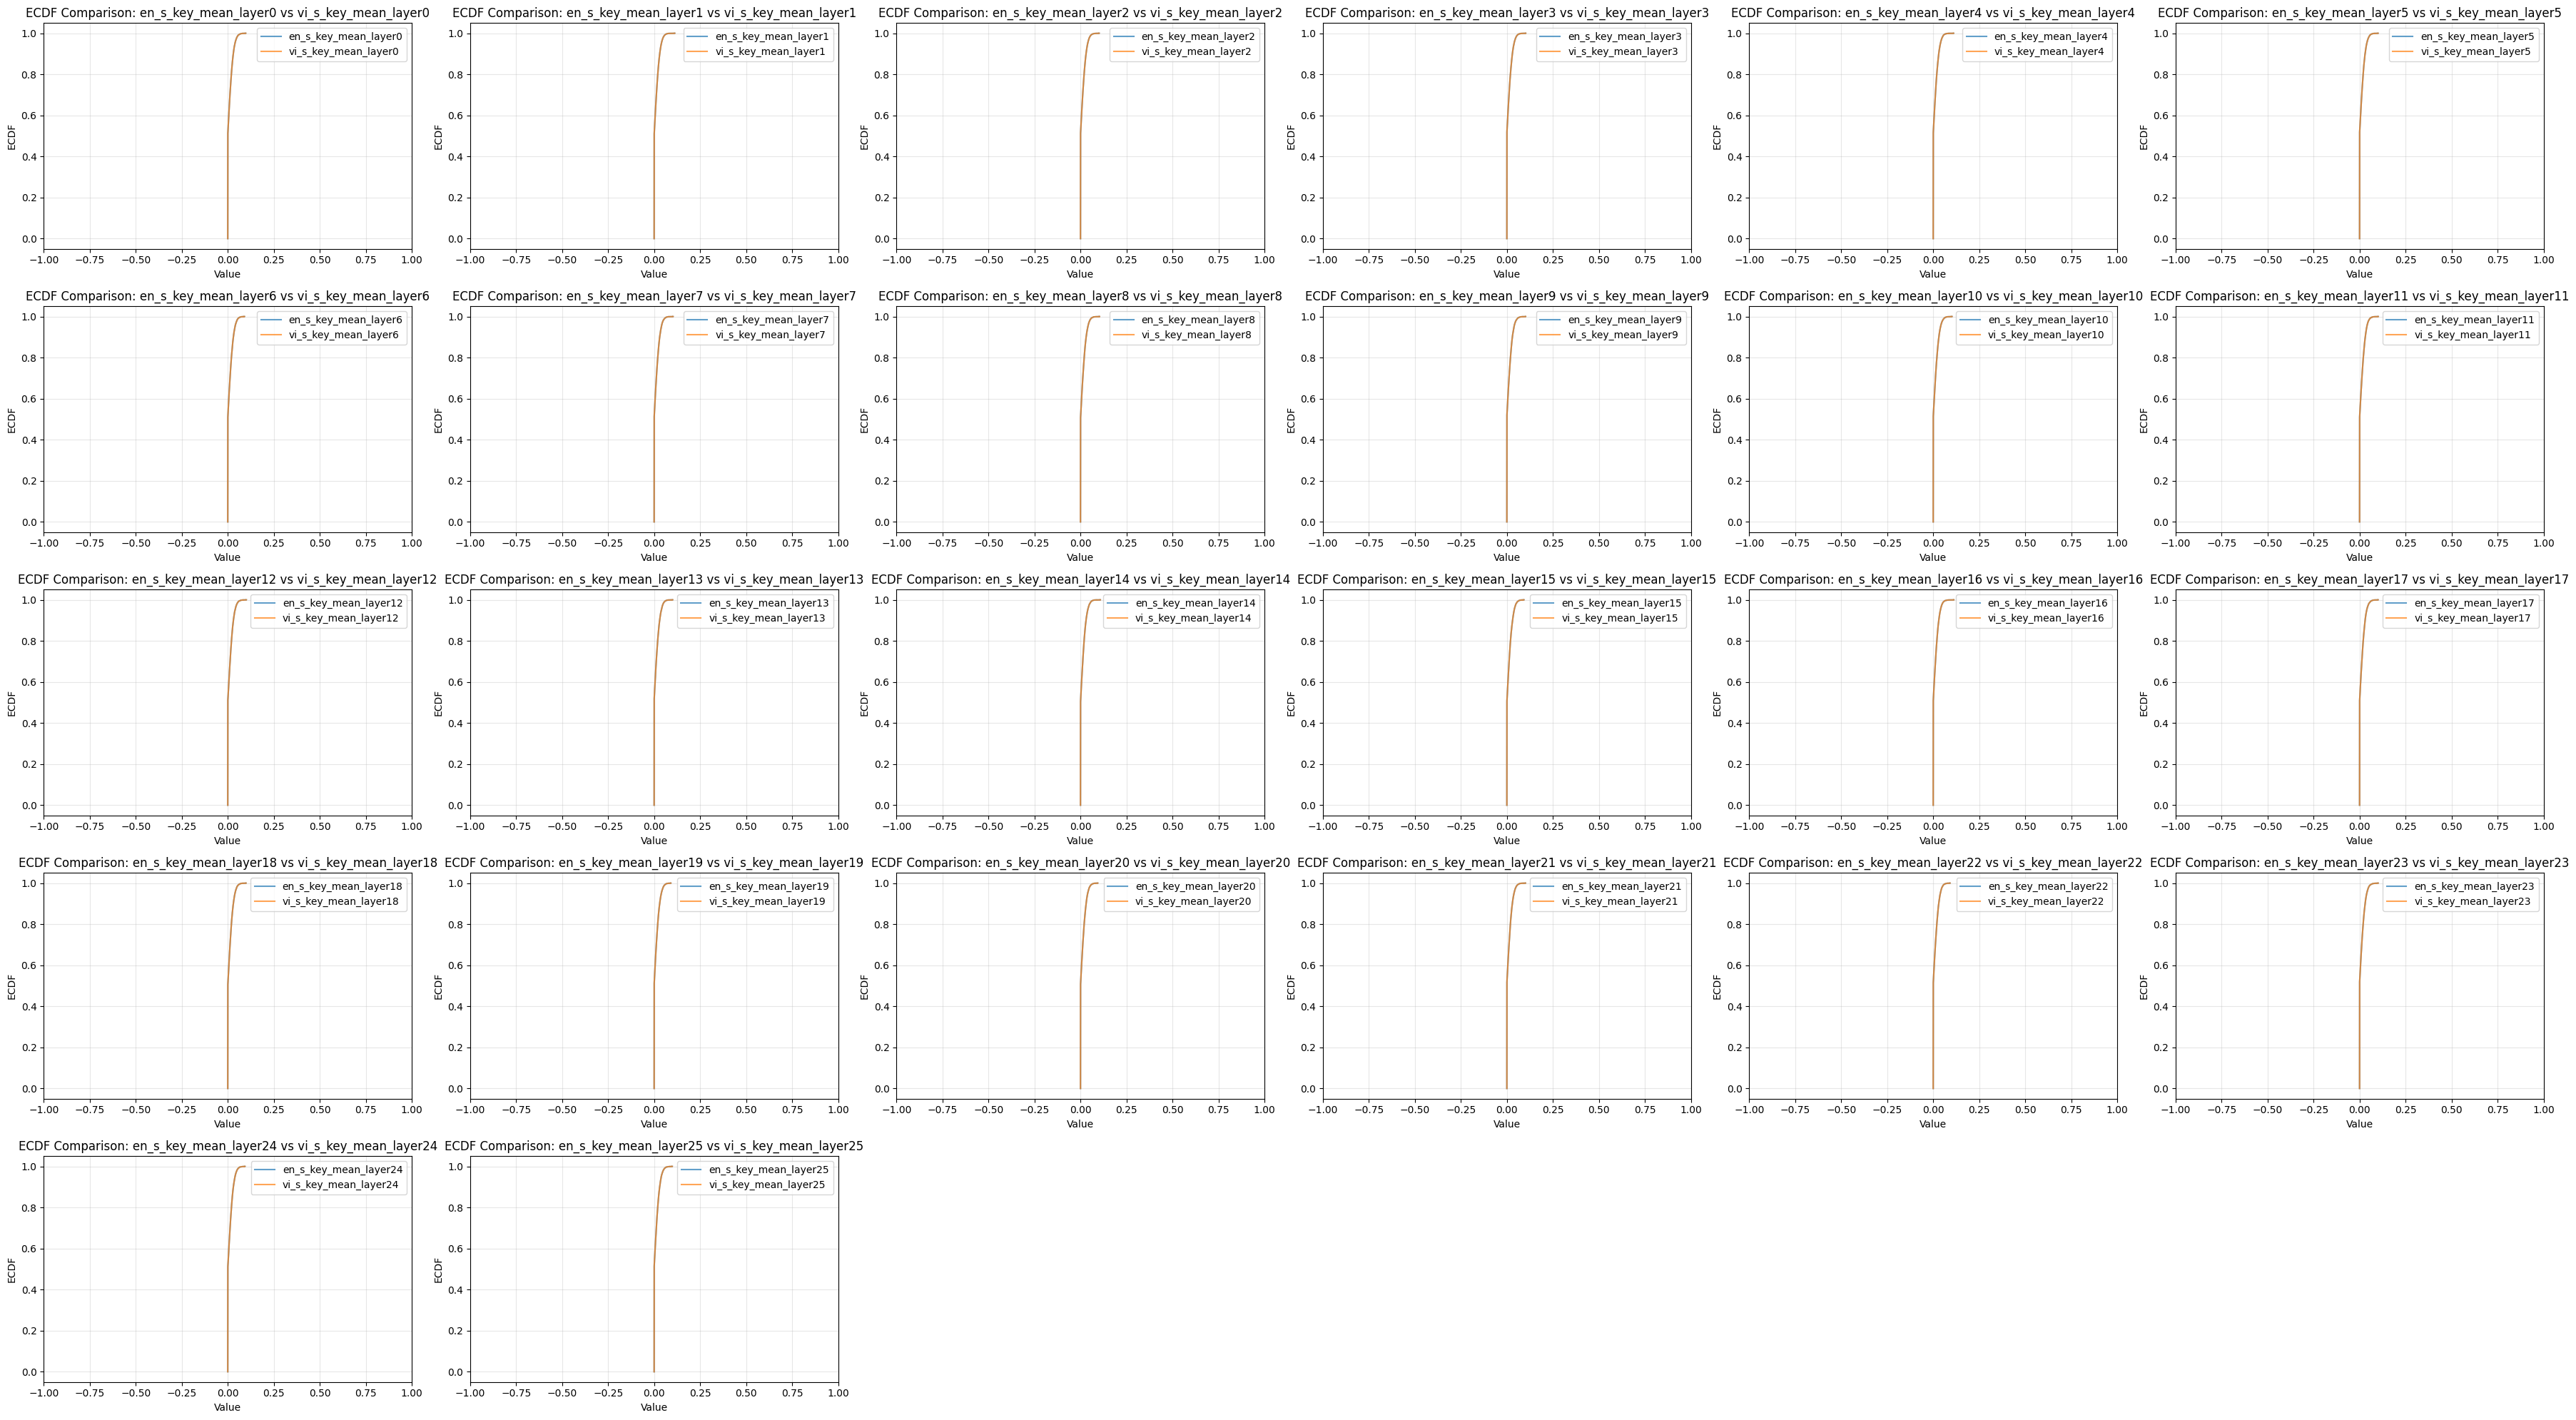

In [48]:
data_neu_enAvi_rela_result_per_layer = []
data_neu_enAvi_rela_result_per_layer_labels = []

for ilayer in range(26):
    single_layer = []
    for ikey in result_relation.keys():
        if f'layers.{ilayer}' in ikey:
            single_layer.extend(result_relation_mi[ikey]['p'][0].tolist())
    
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
           

    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    #data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_mean_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_rela_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max =1, xdim_min = -1)

### spearman relation

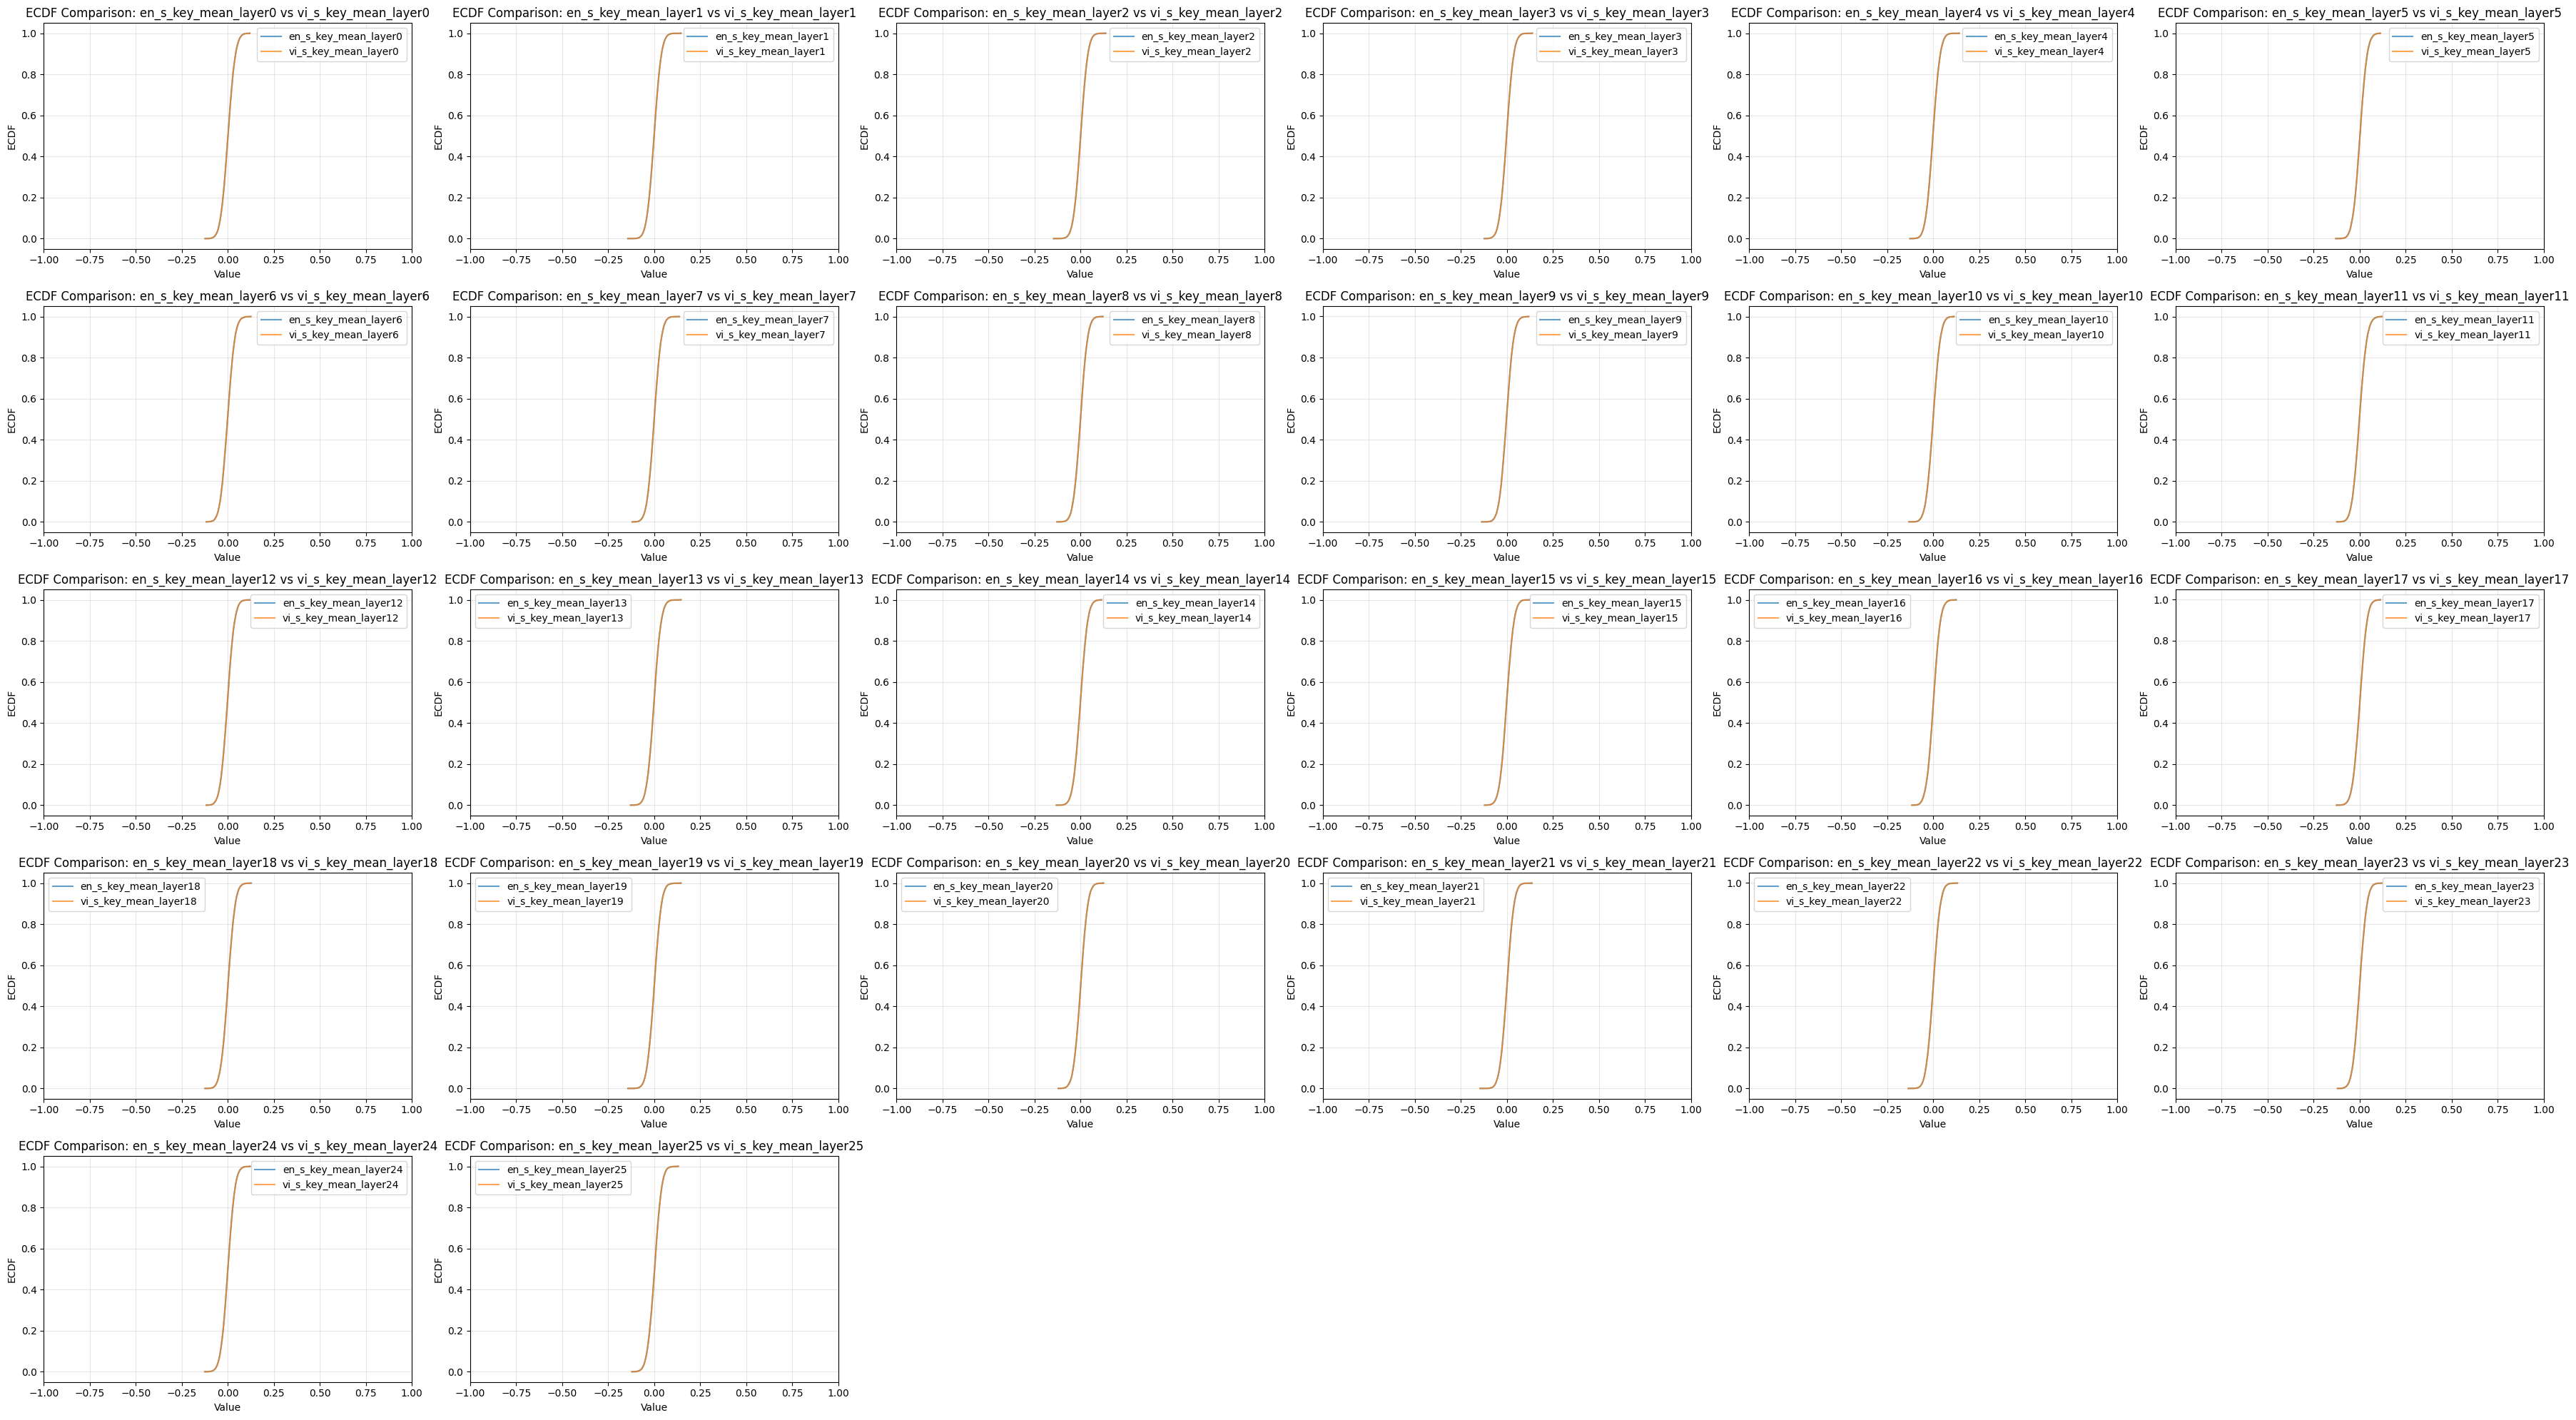

In [34]:
data_neu_enAvi_rela_result_per_layer = []
data_neu_enAvi_rela_result_per_layer_labels = []

for ilayer in range(26):
    single_layer = []
    for ikey in result_relation.keys():
        if f'layers.{ilayer}' in ikey:
            single_layer.extend(result_relation_spearman[ikey]['p'][0].tolist())
    
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
           

    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    #data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_mean_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_rela_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max =1, xdim_min = -1)

### pearson relation

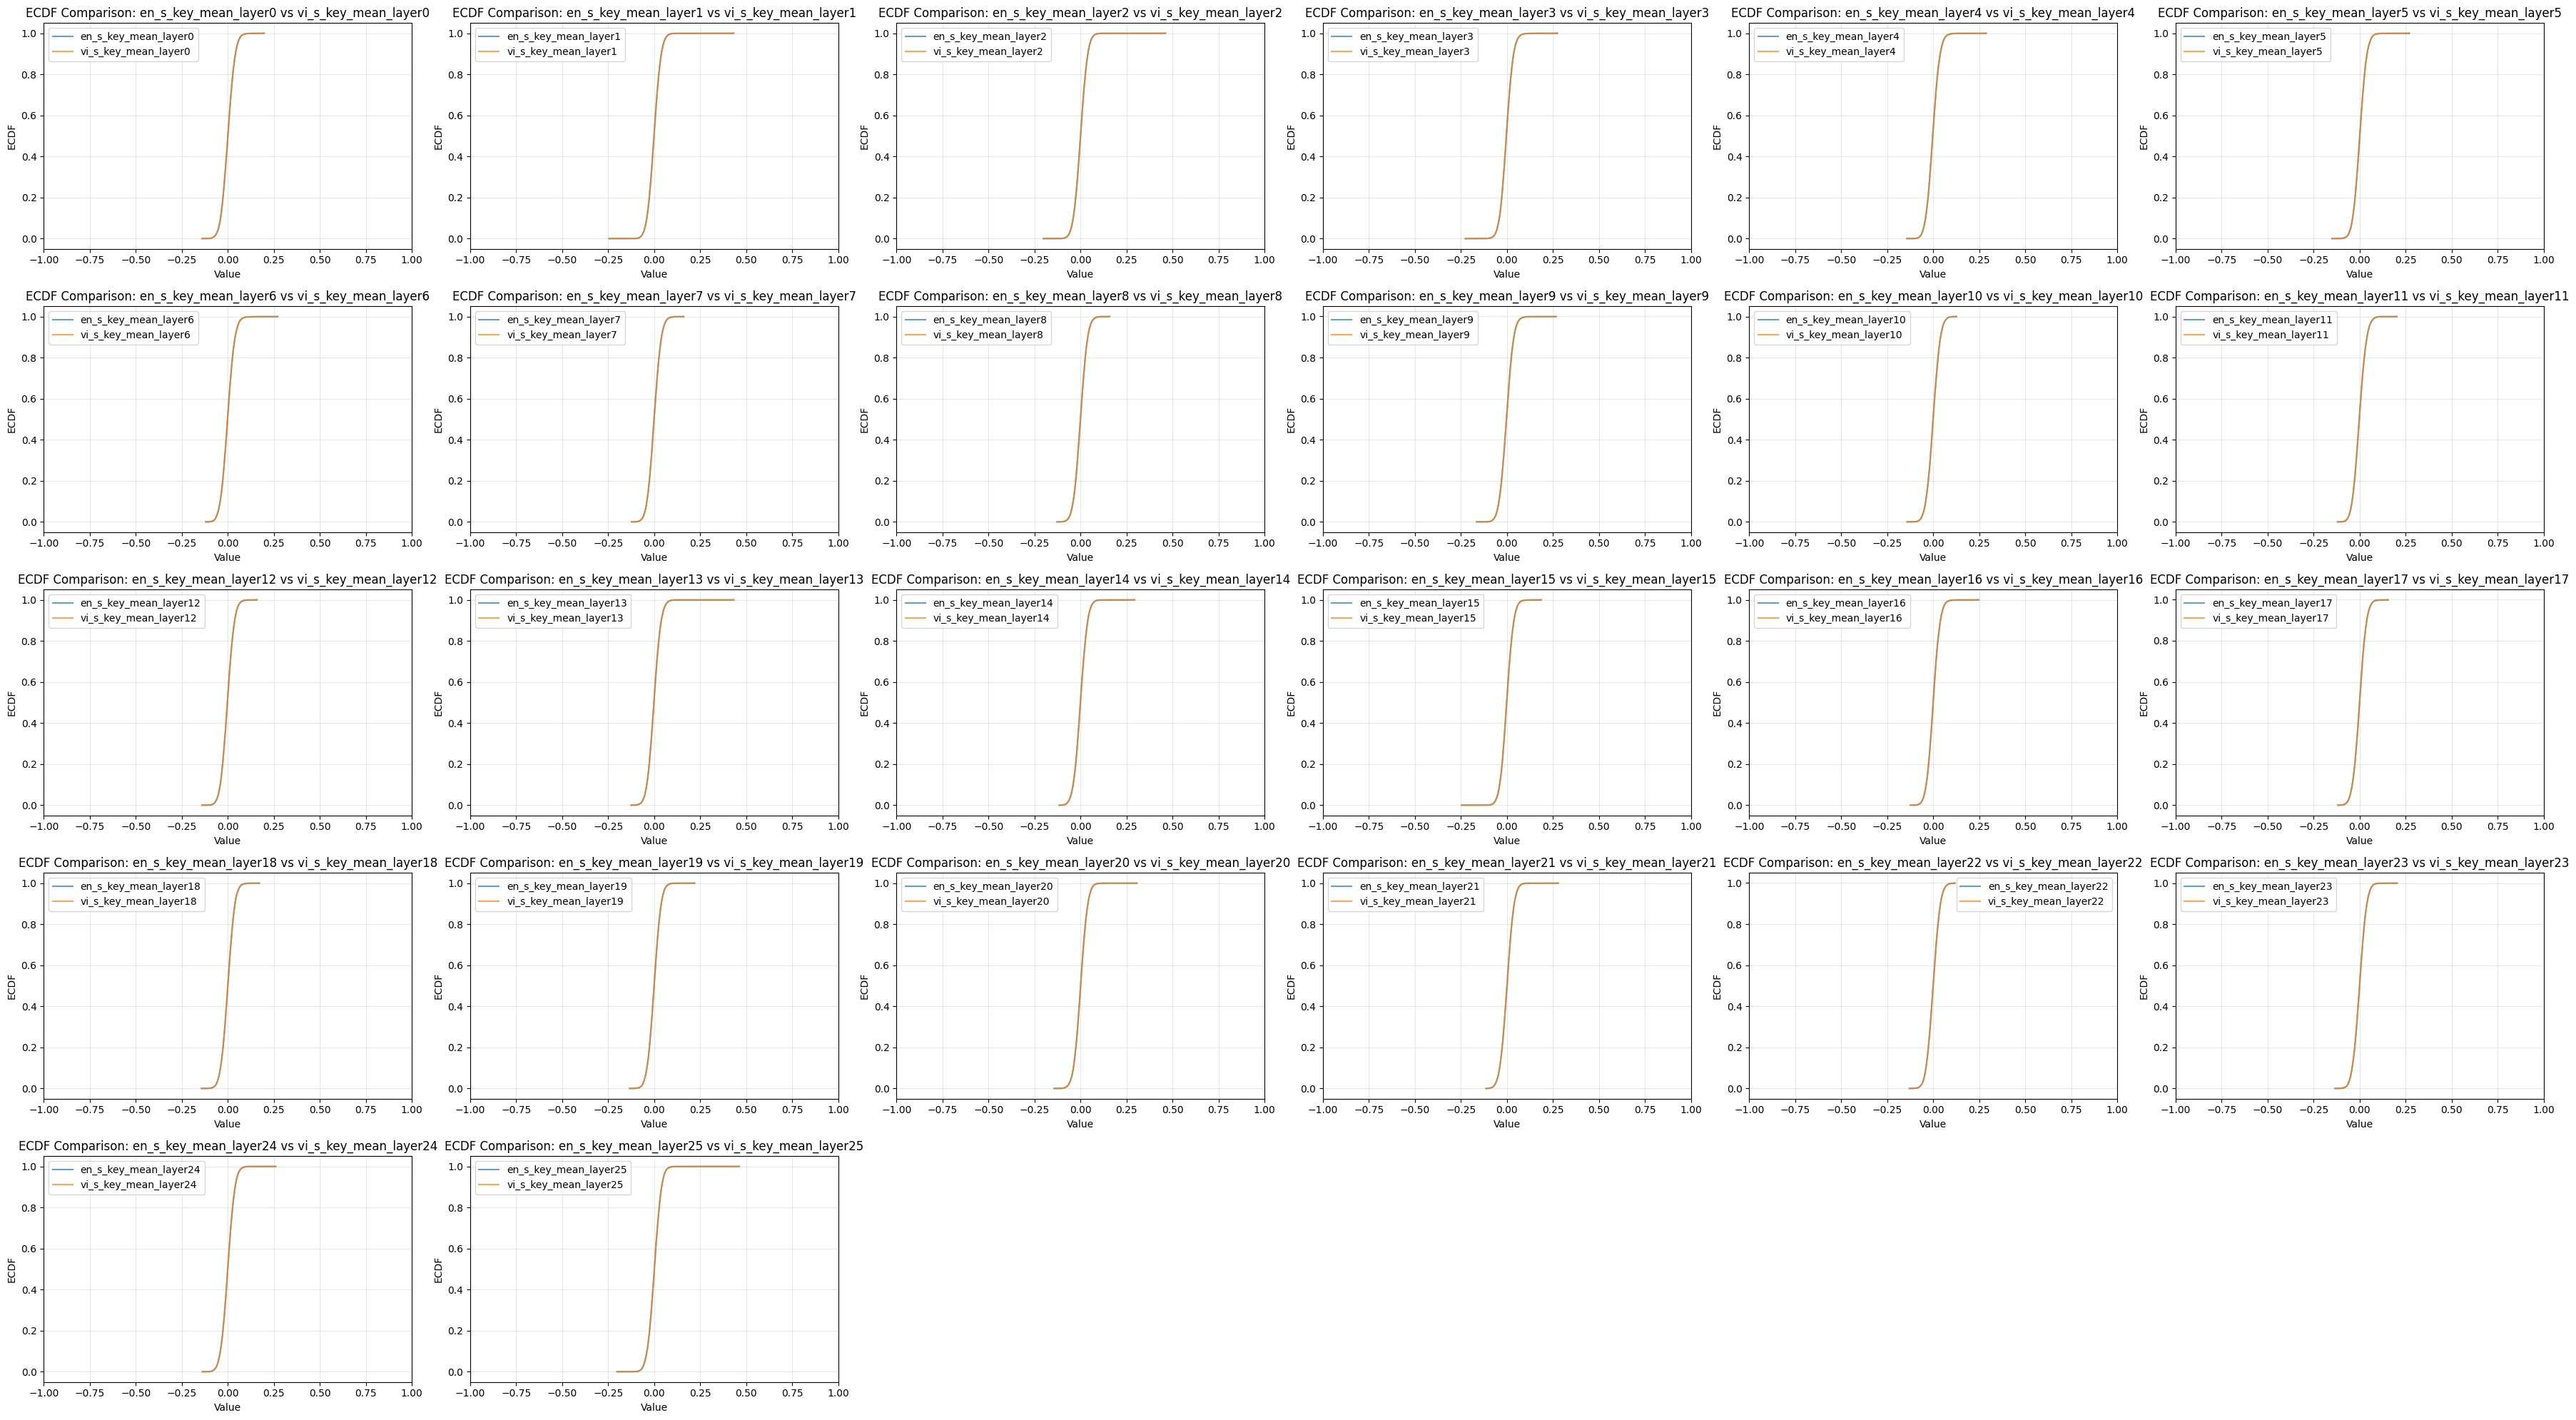

In [29]:
data_neu_enAvi_rela_result_per_layer = []
data_neu_enAvi_rela_result_per_layer_labels = []

for ilayer in range(26):
    single_layer = []
    for ikey in result_relation.keys():
        if f'layers.{ilayer}' in ikey:
            single_layer.extend(result_relation[ikey]['p'][0].tolist())
    
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
    data_neu_enAvi_rela_result_per_layer.append(np.array(single_layer))
           

    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    data_neu_enAvi_result_per_layer_labels.append(f"layer.{ilayer}")
    #data_neu_enAvi_result_per_layer_labels.append(f'vi_s_key_mean_layer{ilayer}')
    
plot_ecdf_pairs(data_neu_enAvi_rela_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max =1, xdim_min = -1)

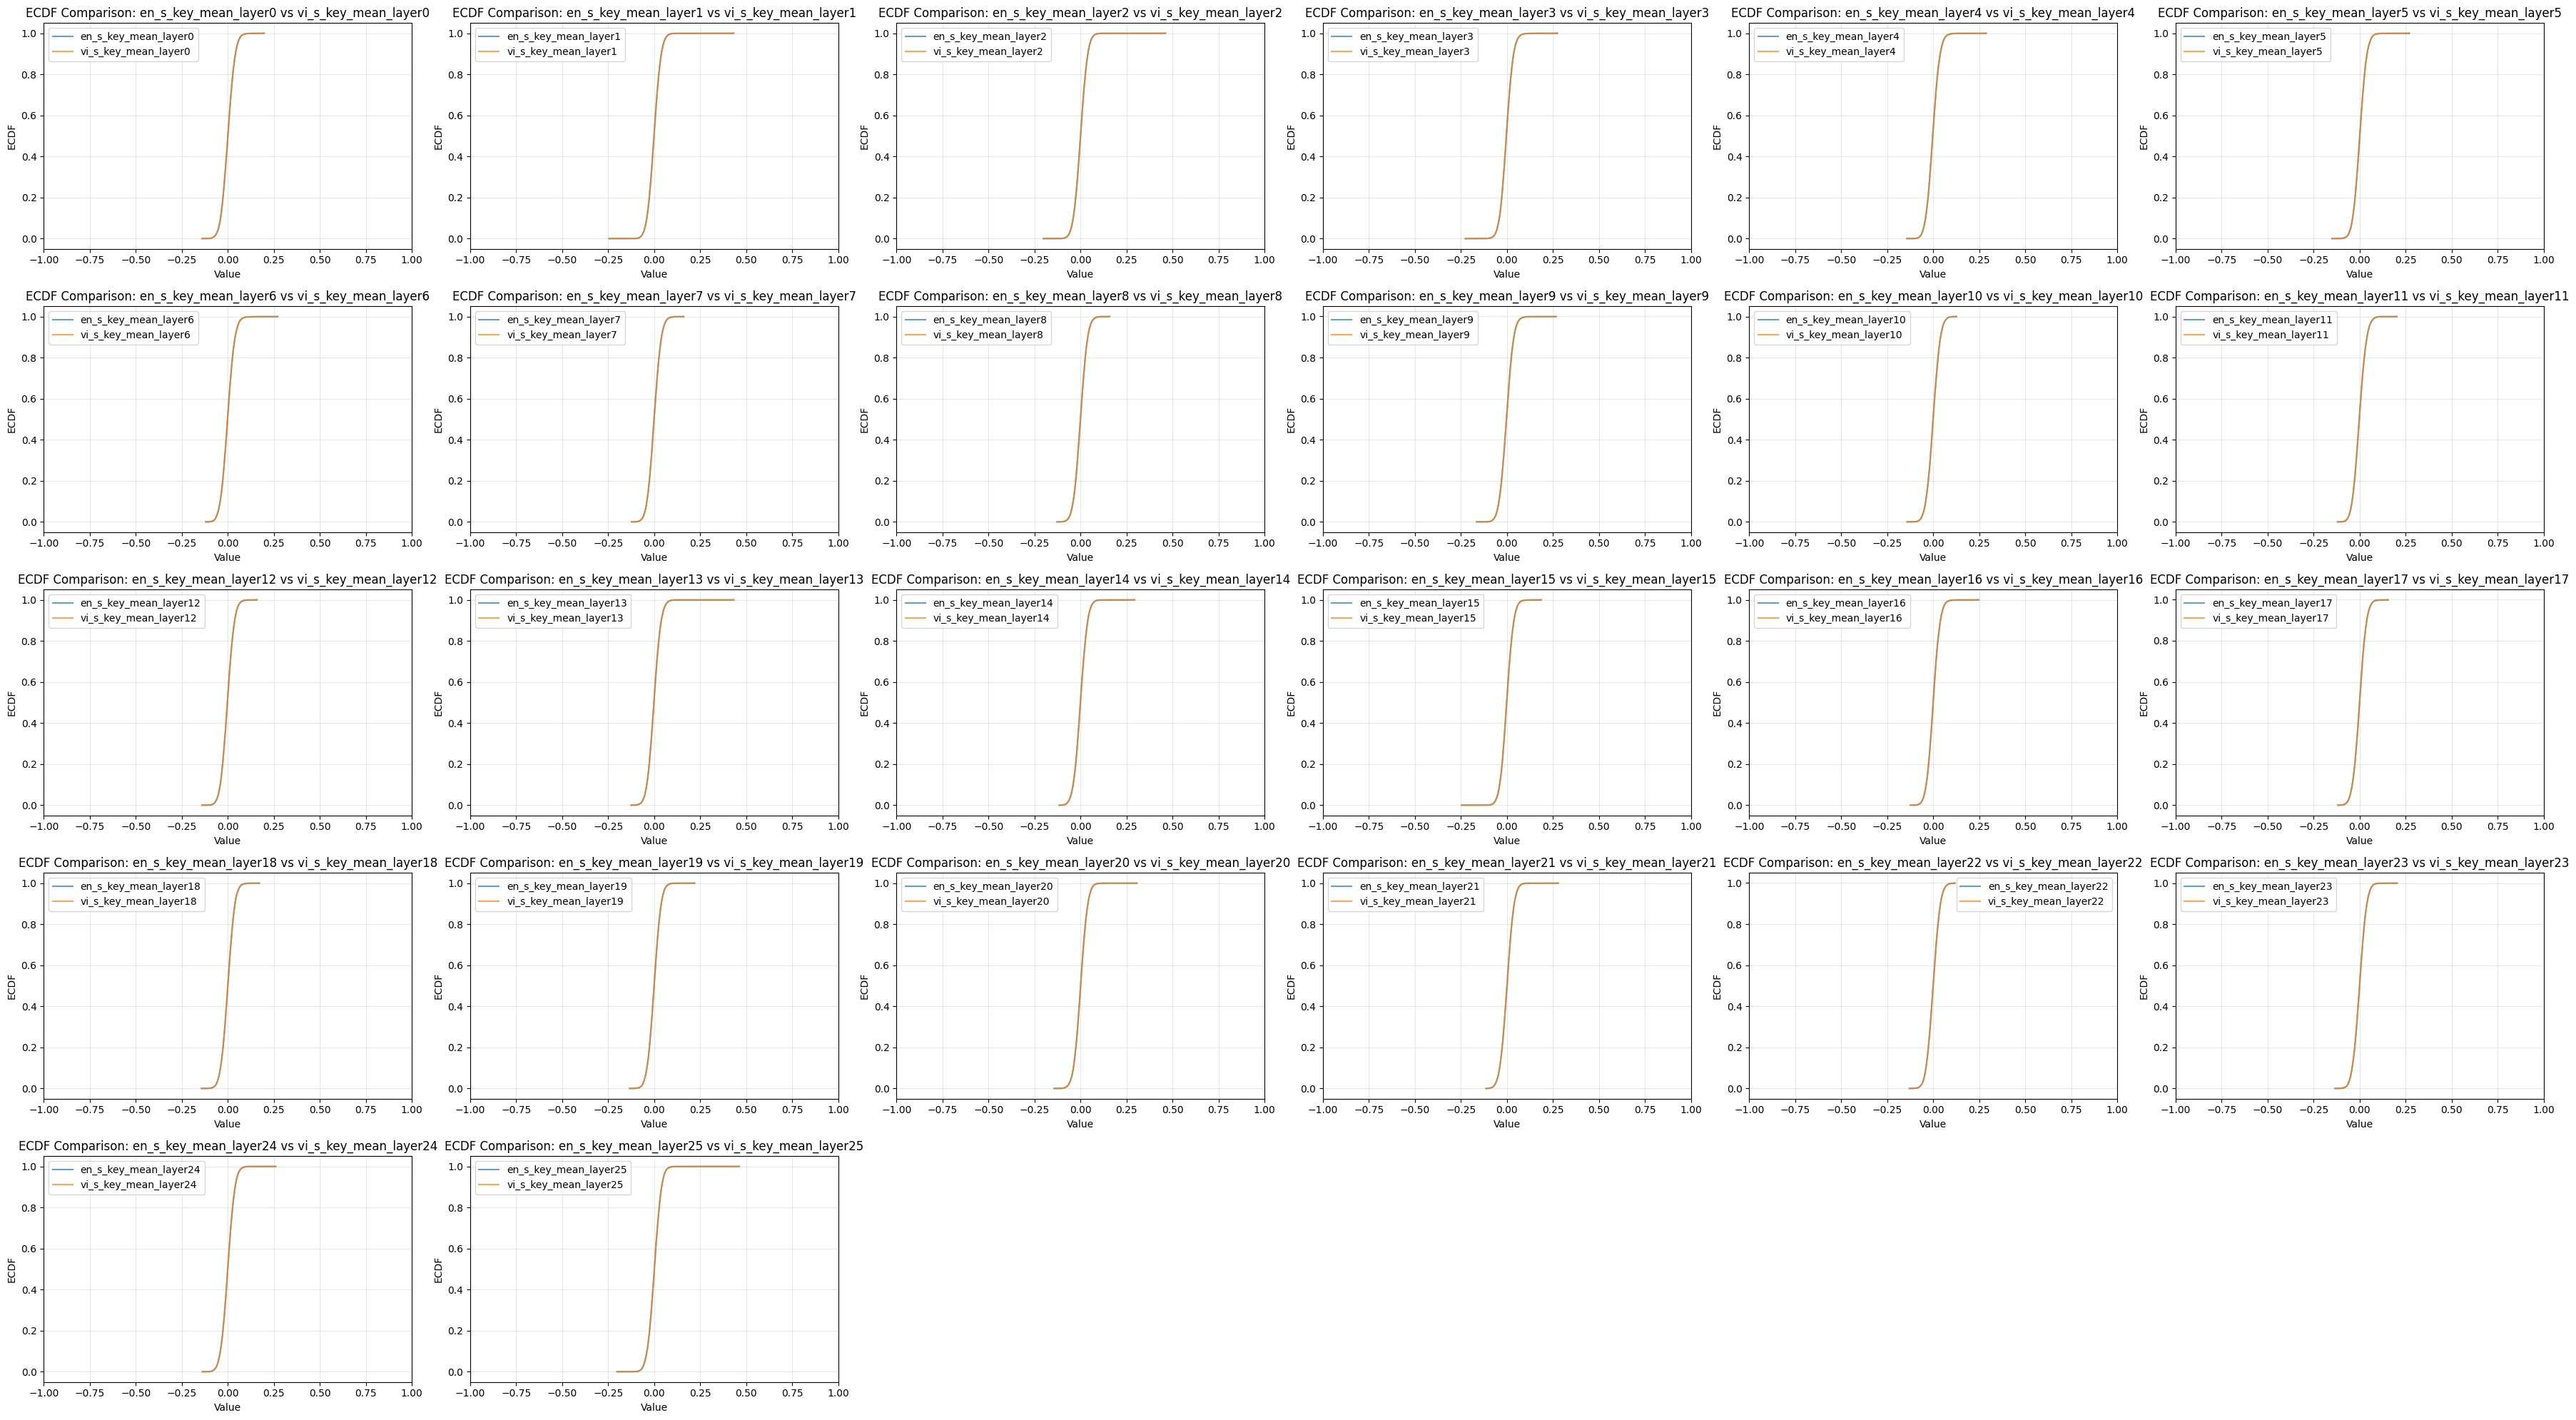

In [30]:
plot_ecdf_pairs(data_neu_enAvi_rela_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max =1, xdim_min = -1)

In [ ]:
data_neu_enAvi_rela_result_per_layer

In [68]:
data_neu_enAvi_result_per_layer_labels

['en_s_key_mean_layer0',
 'vi_s_key_mean_layer0',
 'en_s_key_mean_layer1',
 'vi_s_key_mean_layer1',
 'en_s_key_mean_layer2',
 'vi_s_key_mean_layer2',
 'en_s_key_mean_layer3',
 'vi_s_key_mean_layer3',
 'en_s_key_mean_layer4',
 'vi_s_key_mean_layer4',
 'en_s_key_mean_layer5',
 'vi_s_key_mean_layer5',
 'en_s_key_mean_layer6',
 'vi_s_key_mean_layer6',
 'en_s_key_mean_layer7',
 'vi_s_key_mean_layer7',
 'en_s_key_mean_layer8',
 'vi_s_key_mean_layer8',
 'en_s_key_mean_layer9',
 'vi_s_key_mean_layer9',
 'en_s_key_mean_layer10',
 'vi_s_key_mean_layer10',
 'en_s_key_mean_layer11',
 'vi_s_key_mean_layer11',
 'en_s_key_mean_layer12',
 'vi_s_key_mean_layer12',
 'en_s_key_mean_layer13',
 'vi_s_key_mean_layer13',
 'en_s_key_mean_layer14',
 'vi_s_key_mean_layer14',
 'en_s_key_mean_layer15',
 'vi_s_key_mean_layer15',
 'en_s_key_mean_layer16',
 'vi_s_key_mean_layer16',
 'en_s_key_mean_layer17',
 'vi_s_key_mean_layer17',
 'en_s_key_mean_layer18',
 'vi_s_key_mean_layer18',
 'en_s_key_mean_layer19',
 'vi_s

In [45]:
mean_diff

[0.00023478745424654335,
 -8.707778761163354e-05,
 -0.0002664269686647458,
 -0.00013238142128102481,
 1.3182201655581594e-05,
 -5.4263437050394714e-05,
 -0.0002950956331915222,
 -0.0004534808249445632,
 1.570439781062305e-05,
 0.00010918673615378793,
 -1.8308055587112904e-06,
 -0.0005048358434578404,
 -0.00041587491523387143,
 -0.0002726164530031383,
 3.691016900120303e-05,
 -3.861130971927196e-05,
 0.0004122239952266682,
 -0.00044001522110193036,
 -0.0005502562853507698,
 -0.00019877526210621,
 4.9323229177389294e-05,
 -0.00013075218885205686,
 -0.0002580929867690429,
 9.200818021781743e-05,
 9.71989102254156e-05,
 0.00023642323503736407,
 0.00021306915732566267,
 -0.0005435957664303714,
 -6.049926014384255e-05,
 -0.0006489293155027553,
 6.011886216583662e-05,
 0.00013480220513883978,
 -4.406459629535675e-05,
 5.74813648199779e-05,
 -0.0002870846292353235,
 0.00011700977847795002,
 -0.00026362590506323613,
 0.0007892475841799751,
 1.398497261106968e-05,
 -0.00024083453172352165,
 5.29

In [34]:
data_neu_result['model.layers.25.mlp.down_proj.weight']

{'mean': array([-2.38119264e-02, -3.45425341e-02, -1.53310498e-02, -3.43324443e-02,
        -2.32918262e-02,  5.44926193e-03, -1.20341827e-02,  6.18050496e-03,
        -5.81717491e-03,  1.43132408e-02, -2.97678775e-02, -1.96201404e-02,
        -1.79942714e-02, -8.21619564e-03,  3.97978392e-03, -5.57584564e-03,
         1.42397119e-02,  2.82128851e-02, -2.58416327e-02,  1.87514598e-02,
         8.51600369e-03, -2.96815899e-03, -1.18688742e-03, -1.85993910e-02,
         1.79726548e-03, -1.12243659e-02, -1.58983601e-02, -2.02607115e-02,
         4.49041526e-03, -6.94245762e-03,  8.59651508e-04, -7.90435407e-03,
         9.97444325e-03, -7.09260814e-04, -1.78002583e-02, -3.26603585e-02,
        -2.11065345e-03,  1.91532572e-03, -4.83536952e-02, -2.23678168e-02,
        -1.15232931e-02, -1.08075639e-03, -2.92652448e-02,  1.84377995e-02,
        -1.12490853e-02, -4.38274609e-03,  3.11696198e-03,  1.15826540e-02,
        -3.37575542e-03, -2.23004652e-02, -6.42160575e-04, -7.43108657e-03,
    

In [35]:
data_vi_neu_result['model.layers.25.mlp.down_proj.weight']

{'mean': array([-0.07093204, -0.05271608, -0.05006902, -0.04516286, -0.08126508,
        -0.0800415 , -0.08919949, -0.05059637, -0.12613365, -0.05594657,
        -0.04187763, -0.08214543, -0.06834735, -0.06023985, -0.05355349,
        -0.06986336, -0.05941318, -0.03074584, -0.04740571, -0.02717342,
        -0.05768245, -0.07339083, -0.05787617, -0.087263  , -0.05445906,
        -0.09850127, -0.05564315, -0.10485224, -0.04292427, -0.03076179,
        -0.06753568, -0.05106528, -0.06153915, -0.05471267, -0.06022271,
        -0.0541912 , -0.04697651, -0.05576254, -0.032357  , -0.09699886,
        -0.07704493, -0.03715025, -0.10409101, -0.04997383, -0.05166753,
        -0.05557119, -0.08023428, -0.04643232, -0.0440607 , -0.05313642,
        -0.06424081, -0.10415355, -0.04929743, -0.0679798 , -0.04326785,
        -0.05859665, -0.0892798 , -0.06259097, -0.05728916, -0.05374724,
        -0.05657242, -0.03226157, -0.07693531, -0.03986122, -0.0460888 ,
        -0.02805841, -0.06628784, -0.041565

## 分位数

In [18]:
get_key_quan(data_vi, 'model.layers.0.mlp.down_proj.weight')

10% 分位数: -0.474609375
25% 分位数: -0.201171875
50% 分位数: -0.00019693374633789062
75% 分位数: 0.1982421875
90% 分位数: 0.455078125


In [19]:
get_key_quan(data_vi,'model.layers.25.mlp.down_proj.weight')

10% 分位数: -2.109375
25% 分位数: -1.015625
50% 分位数: -0.0052490234375
75% 分位数: 1.0
90% 分位数: 2.109375


In [7]:
get_key_quan(data, 'model.layers.0.mlp.down_proj.weight')

10% 分位数: -0.25390625
25% 分位数: -0.107421875
50% 分位数: 0.003204345703125
75% 分位数: 0.11572265625
90% 分位数: 0.263671875


In [8]:
get_key_quan(data,'model.layers.25.mlp.down_proj.weight')

10% 分位数: -1.1015625
25% 分位数: -0.5234375
50% 分位数: 0.0034332275390625
75% 分位数: 0.53515625
90% 分位数: 1.1640625


In [9]:
get_key_quan(data,'model.layers.0.self_attn.q_proj.weight')

10% 分位数: -0.00677490234375
25% 分位数: -0.002593994140625
50% 分位数: -4.1909515857696533e-07
75% 分位数: 0.002410888671875
90% 分位数: 0.006439208984375


In [10]:
get_key_quan(data,'model.layers.25.self_attn.q_proj.weight')

10% 分位数: -0.00811767578125
25% 分位数: -0.0026702880859375
50% 分位数: 4.954636096954346e-07
75% 分位数: 0.002685546875
90% 分位数: 0.0079345703125


In [11]:
get_key_quan(data,'model.layers.25.self_attn.k_proj.weight')

10% 分位数: -0.0167236328125
25% 分位数: -0.006134033203125
50% 分位数: 0.0
75% 分位数: 0.005859375
90% 分位数: 0.016845703125


In [12]:
get_key_quan(data,'model.layers.25.self_attn.v_proj.weight')

10% 分位数: -0.134765625
25% 分位数: -0.054931640625
50% 分位数: -0.0020751953125
75% 分位数: 0.046142578125
90% 分位数: 0.119140625


In [13]:
get_key_quan(data,'model.layers.0.self_attn.v_proj.weight')

10% 分位数: -0.158203125
25% 分位数: -0.07080078125
50% 分位数: -0.00445556640625
75% 分位数: 0.060302734375
90% 分位数: 0.1376953125


In [14]:
#data['model.layers.0.mlp.down_proj.weight']

In [15]:
data.keys()

dict_keys(['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_norm.weight', 'model.layers.0.self_attn.k_norm.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.pre_feedforward_layernorm.weight', 'model.layers.0.post_feedforward_layernorm.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_norm.weight', 'model.layers.1.self_attn.k_norm.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.input_layernorm.

## LAPE

In [68]:
data.keys()


dict_keys(['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_norm.weight', 'model.layers.0.self_attn.k_norm.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.pre_feedforward_layernorm.weight', 'model.layers.0.post_feedforward_layernorm.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_norm.weight', 'model.layers.1.self_attn.k_norm.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.input_layernorm.

In [32]:

def get_single_data_prob(data):

    new_data = {}
    for ikey in tqdm(data):
    
        # example activation relevance
        all_example_re = data[ikey]
    
        # n_sample * neu_count
        perkey_all_sample = np.array([itmp.float().numpy().tolist() for itmp in data[ikey] ])
    
        perkey_all_sample_mask = np.where(perkey_all_sample>0, 1, 0)
    
    
        # 1* neu_count
        per_neu_prob = np.sum(perkey_all_sample_mask, axis = 0)/perkey_all_sample.shape[0]

        new_data[ikey] = per_neu_prob

        

    return new_data


def calc_lape(data_list):

    lape_result = {}

    new_data_list = []
    for idata in tqdm(data_list):

        new_data = get_single_data_prob(idata)

        # calc entropy for single language
        for ikey in tqdm(new_data.keys()):
            
            new_data[ikey] = -new_data[ikey] * np.log(new_data[ikey]+0.000001)
        
        new_data_list.append(new_data)

    # calc LAPE(language activation probaability entropy)
    lape_score = {}
    for ikey in tqdm(new_data_list[0].keys()):

        lape_score[ikey] = sum([idata[ikey] for idata in new_data_list])

    # total & per language
    return lape_score, new_data_list

    
    

        
    
    
    
    

    



#### tmp test

In [70]:
res = get_single_data_prob()

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


In [76]:
tmp = np.array([itmp.float().numpy().tolist() for itmp in data['model.layers.0.self_attn.o_proj.weight'] ])

In [78]:
perkey_all_sample_mask = np.where(tmp>0, 1, 0)

In [80]:
perkey_all_sample_mask.shape

(1000, 1152)

In [82]:
per_neu_prob = np.sum(perkey_all_sample_mask, axis = 0)/perkey_all_sample_mask.shape[0]

In [83]:
per_neu_prob.shape

(1152,)

In [84]:
min(per_neu_prob)

np.float64(0.0)

In [85]:
max(per_neu_prob)

np.float64(1.0)

In [72]:
min(res['model.layers.0.self_attn.o_proj.weight'])

np.float64(0.0)

In [73]:
max(res['model.layers.0.self_attn.o_proj.weight'])

np.float64(1.0)

#### extrac mlp

In [29]:
def extract_mlp_data(data):
    new_res = {}
    for ikey in data.keys():
        if 'mlp' in ikey:
            new_res[ikey] = data[ikey]
    return new_res
    

In [30]:
data_en_mlp = extract_mlp_data(data)
data_vi_mlp=  extract_mlp_data(data_vi)
data_zh_mlp = extract_mlp_data(data_zh)


In [33]:
lape_score, per_lang_lape_score = calc_lape([data_en_mlp, data_vi_mlp, data_zh_mlp])

100%|██████████| 78/78 [00:35<00:00,  2.23it/s]

100%|██████████| 78/78 [00:32<00:00,  2.43it/s]

100%|██████████| 78/78 [00:31<00:00,  2.49it/s]

100%|██████████| 78/78 [00:00<00:00, 58798.65it/s]


In [34]:
max(per_lang_lape_score[0]['model.layers.6.self_attn.o_proj.weight'])

KeyError: 'model.layers.6.self_attn.o_proj.weight'

In [35]:
min(per_lang_lape_score[0]['model.layers.6.self_attn.o_proj.weight'])

KeyError: 'model.layers.6.self_attn.o_proj.weight'

In [36]:
lape_score['model.layers.0.self_attn.q_proj.weight']

KeyError: 'model.layers.0.self_attn.q_proj.weight'

In [43]:
'''
ECDF of lape score

'''
def draw_score_per_layer_ecdf_score(lape_score):
        data_neu_enAvi_result_per_layer = []
        data_neu_enAvi_result_per_layer_labels = []
        
        for ilayer in range(26):
        
            en_result_tmp = []
            vi_result_tmp = []
            for ikey in lape_score.keys():
                if f'layers.{ilayer}' in ikey:
                    en_result_tmp.extend(lape_score[ikey].tolist())
                    vi_result_tmp.extend(lape_score[ikey].tolist())
            
            
            data_neu_enAvi_result_per_layer.append(en_result_tmp)
            data_neu_enAvi_result_per_layer.append(vi_result_tmp)
        
            data_neu_enAvi_result_per_layer_labels.append(f'lape_3_lang{ilayer}')
            data_neu_enAvi_result_per_layer_labels.append(f'lape_3_lang{ilayer}')
            
        plot_ecdf_pairs(data_neu_enAvi_result_per_layer, data_neu_enAvi_result_per_layer_labels, xdim_max=3, xdim_min=-3)

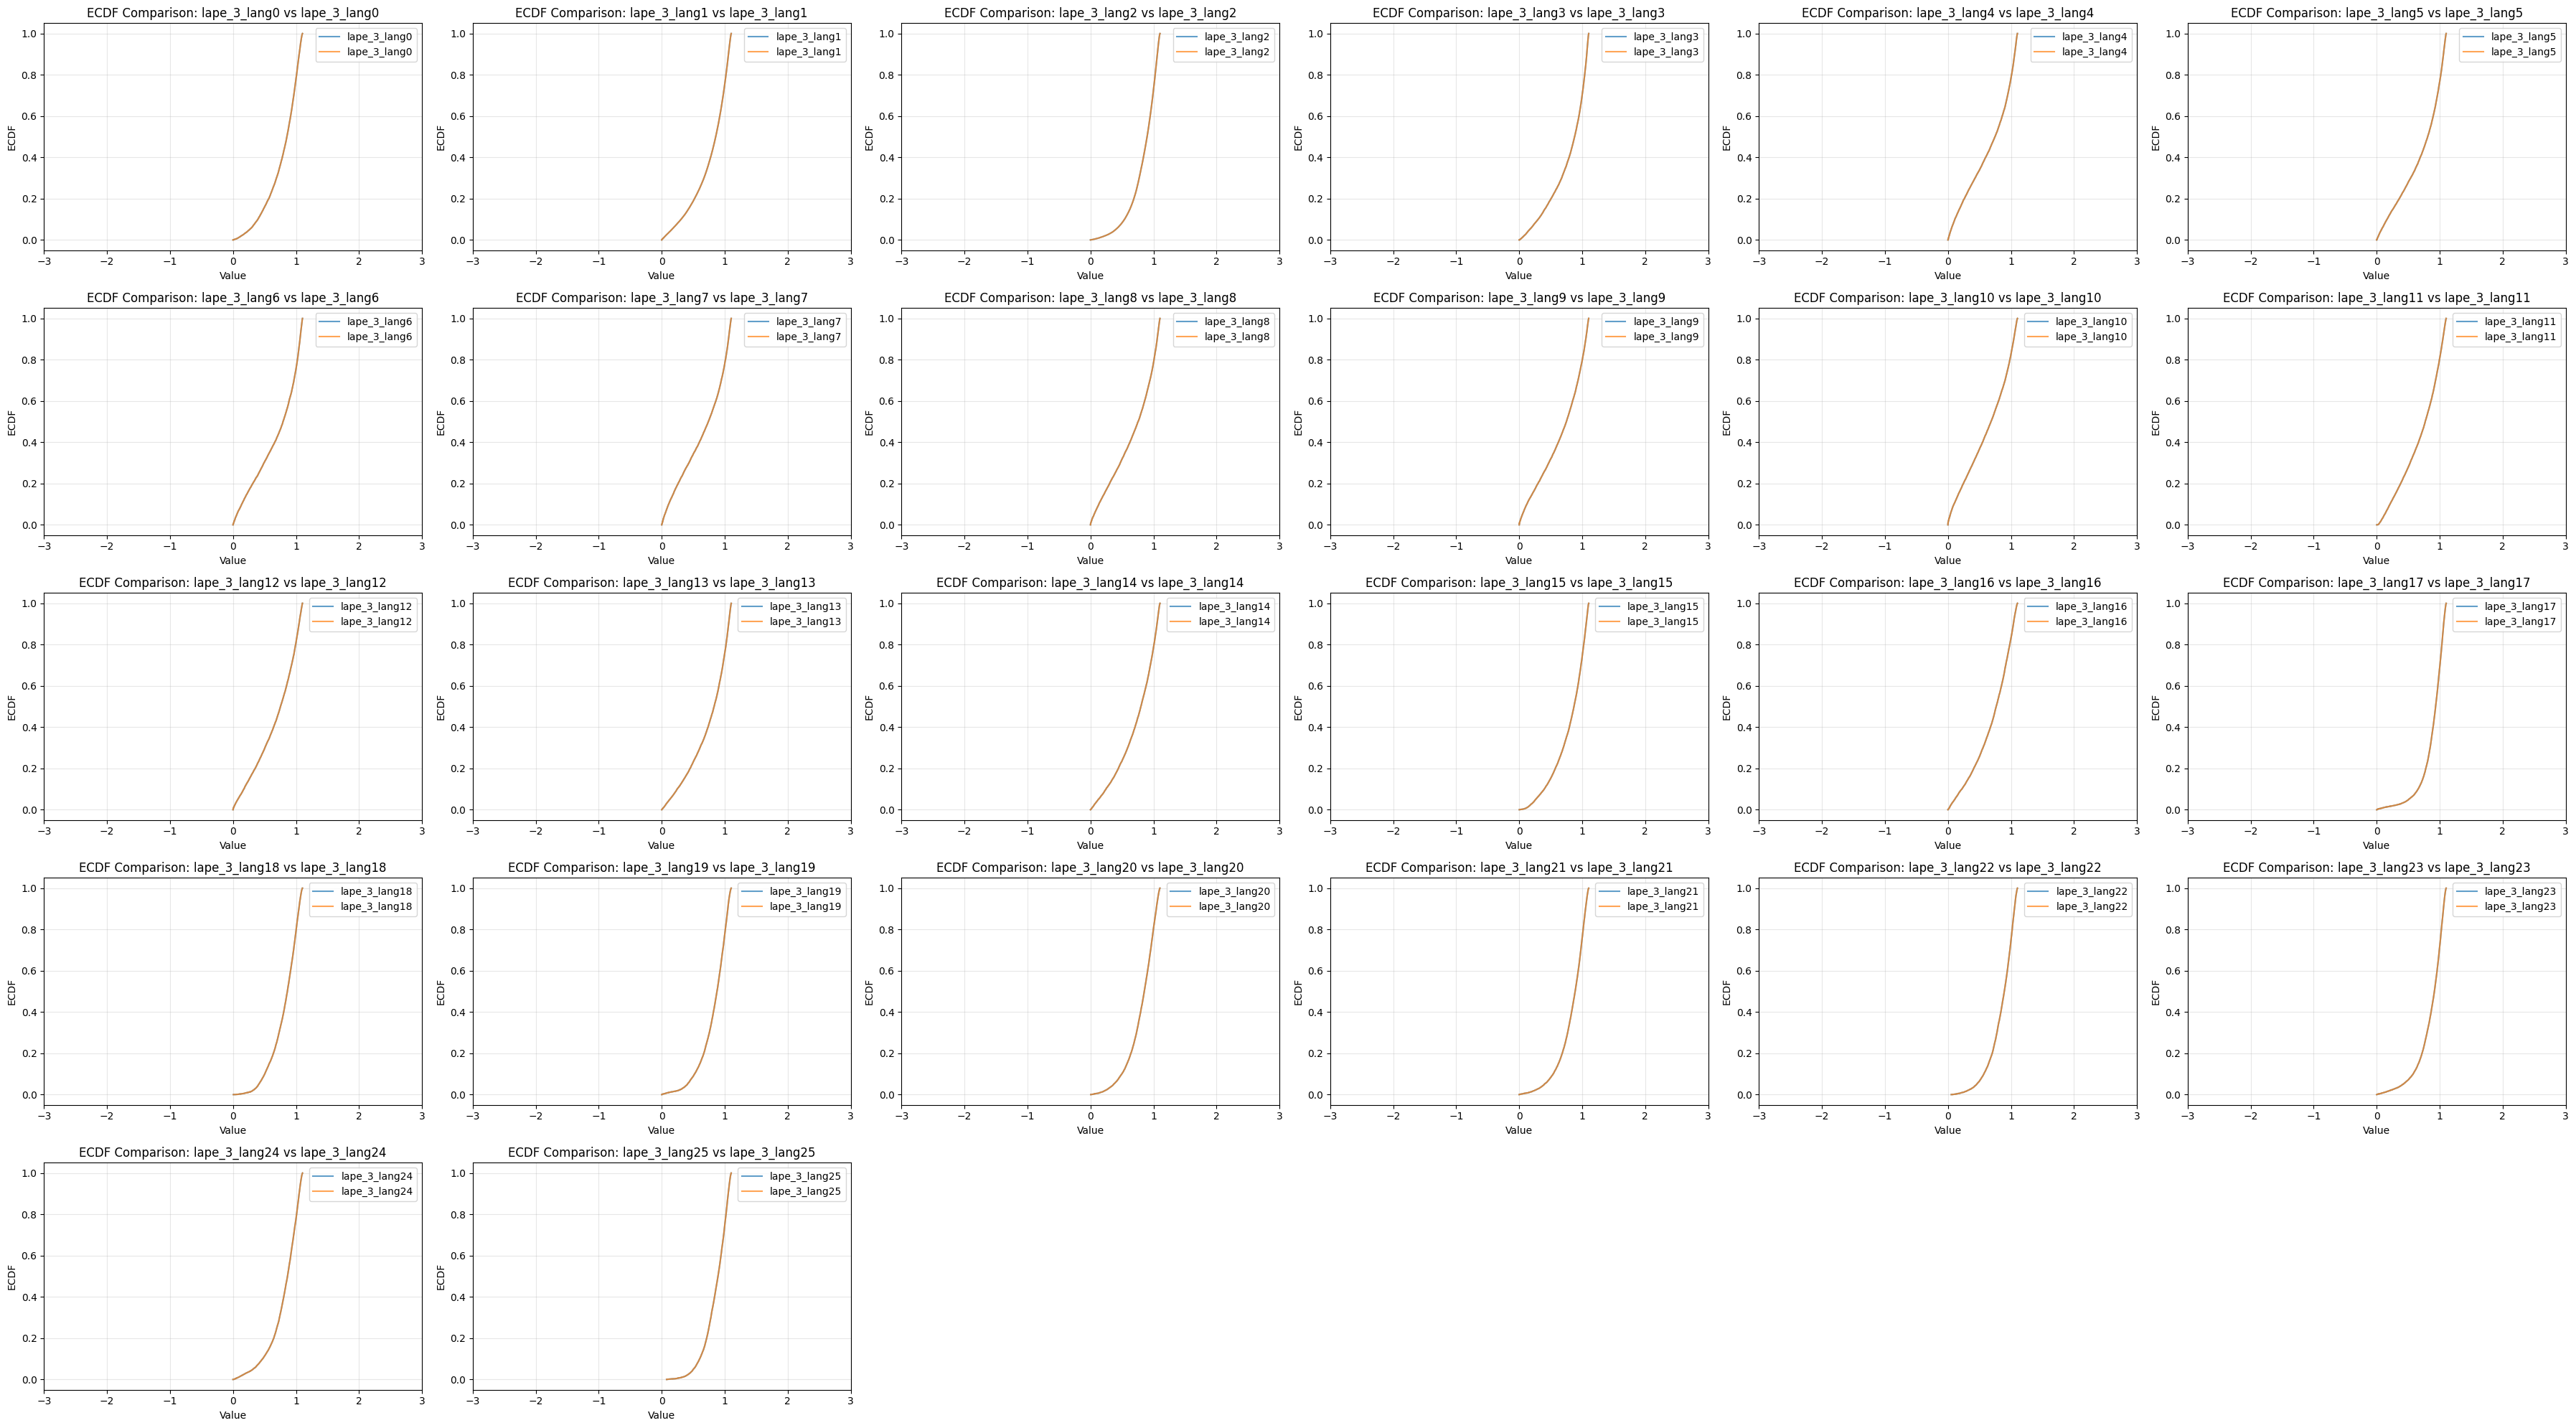

In [44]:
draw_score_per_layer_ecdf_score(lape_score)

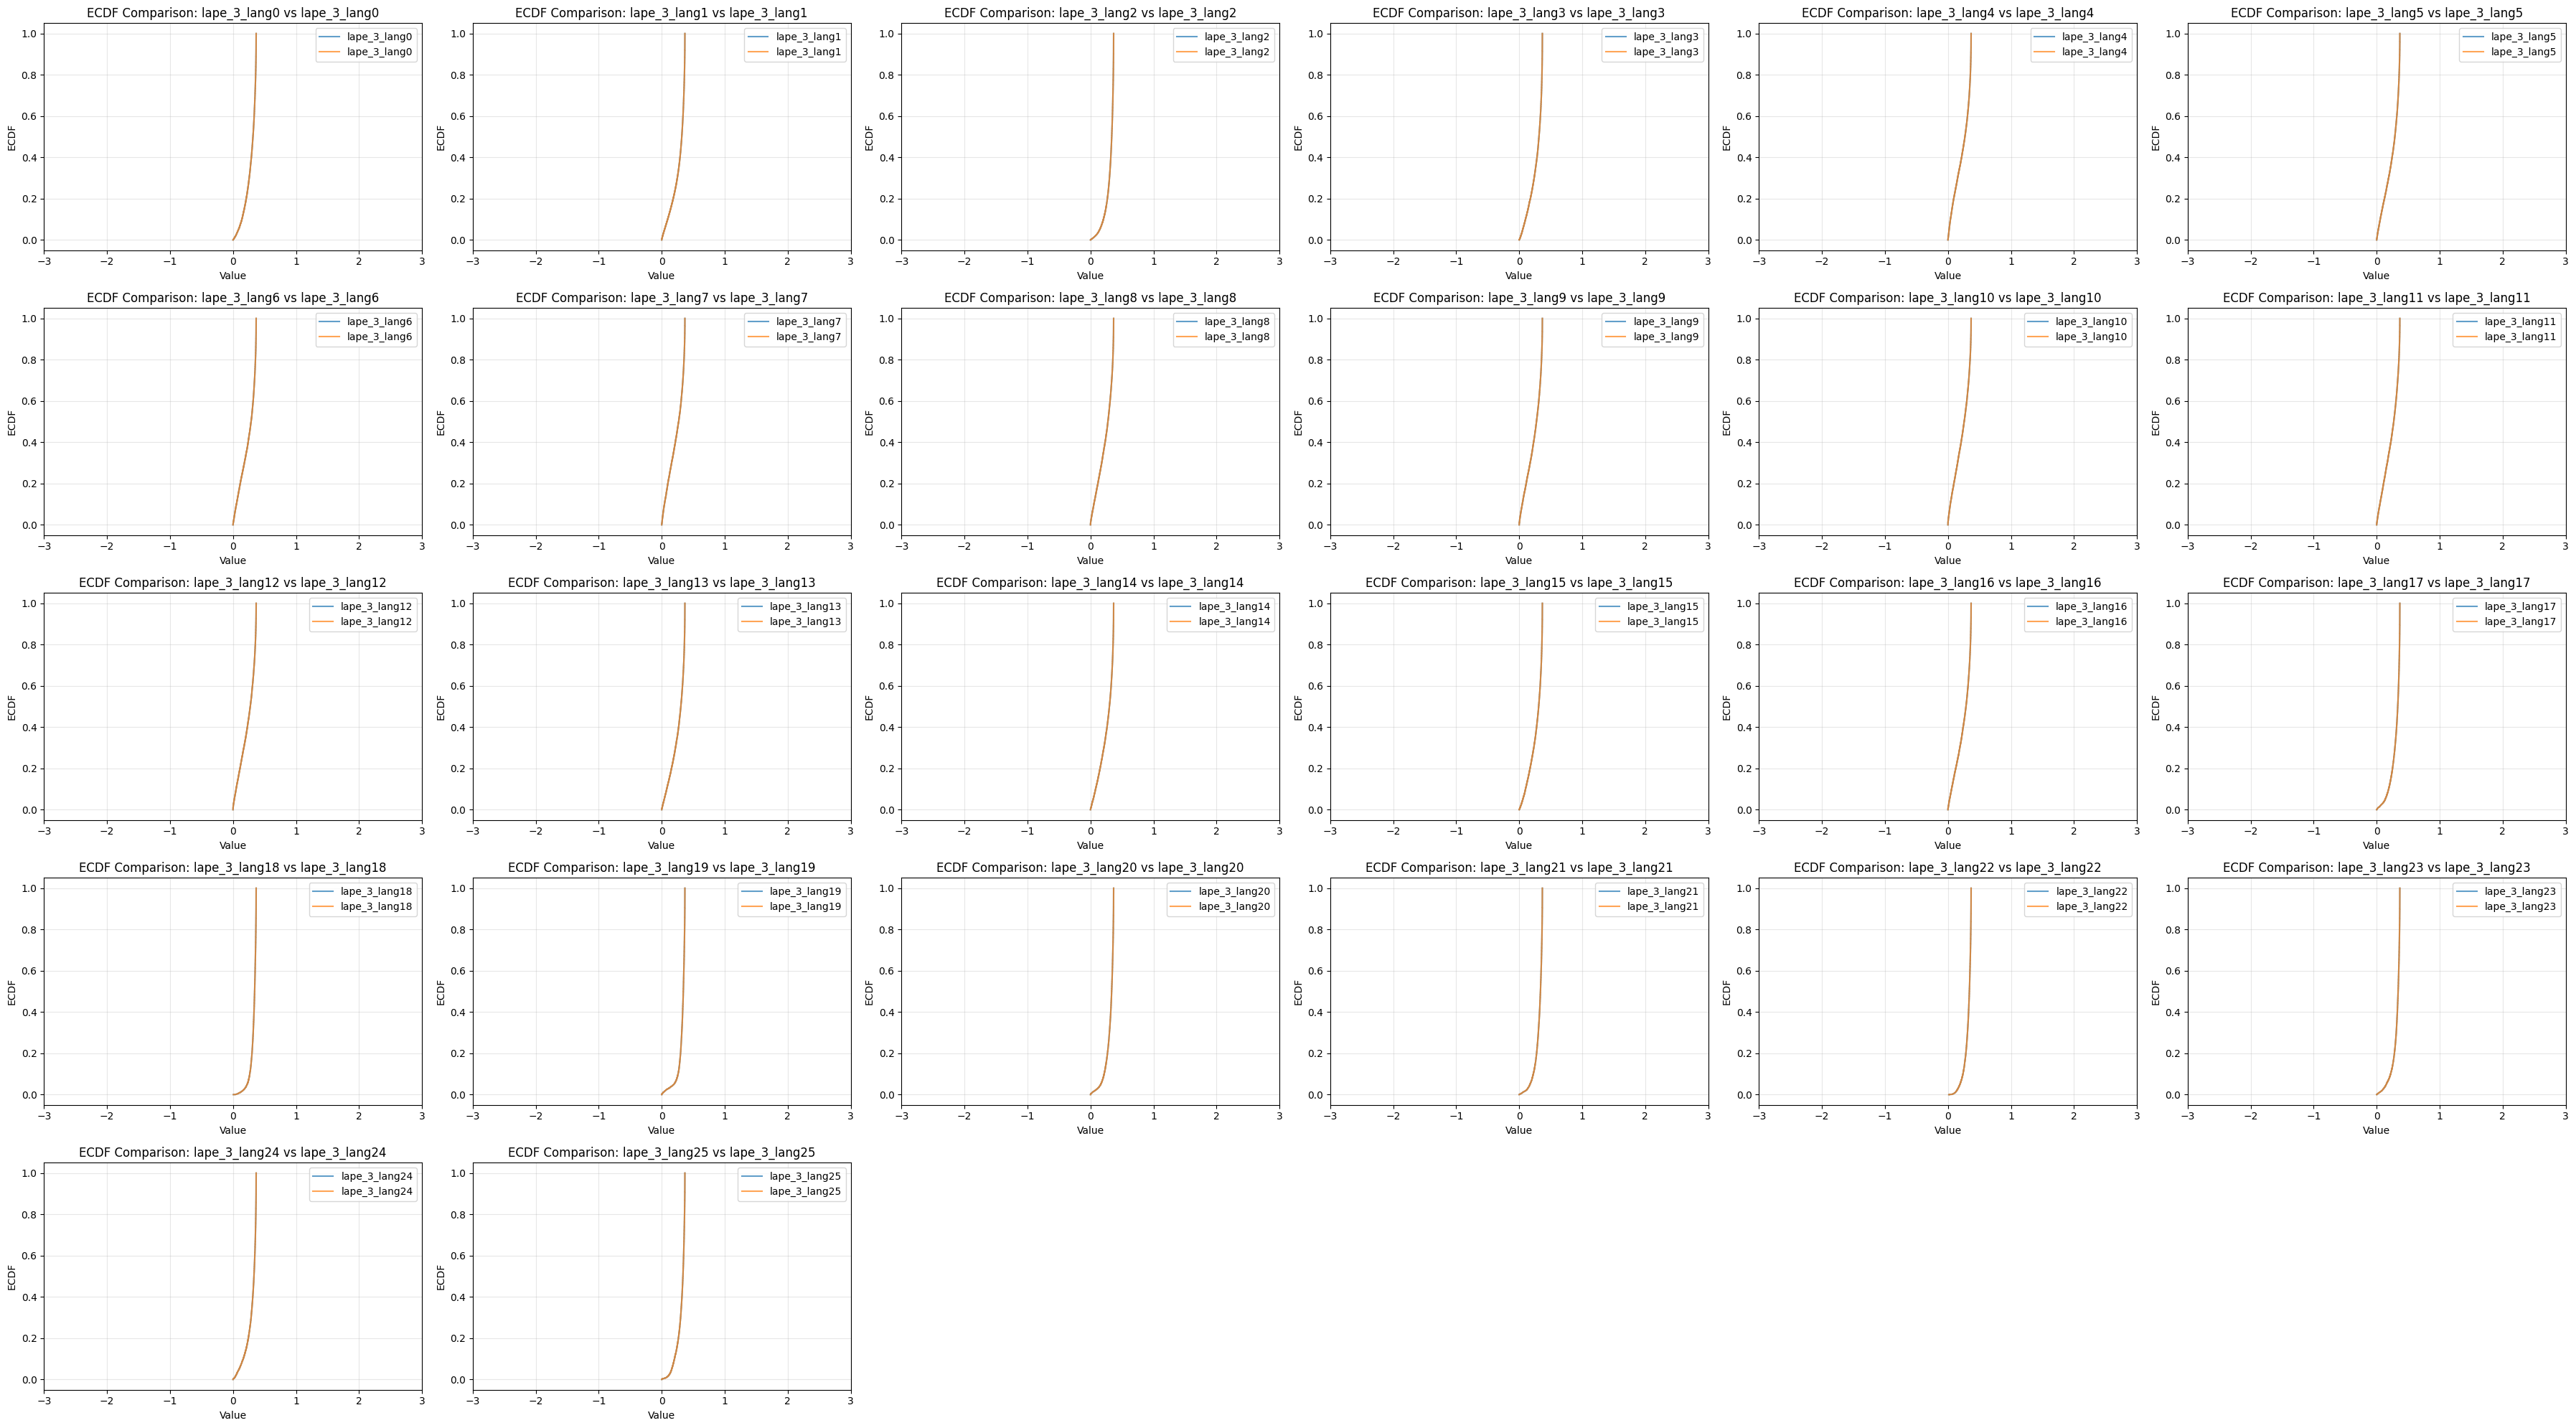

In [49]:
'''
en

'''
draw_score_per_layer_ecdf_score(per_lang_lape_score[0])


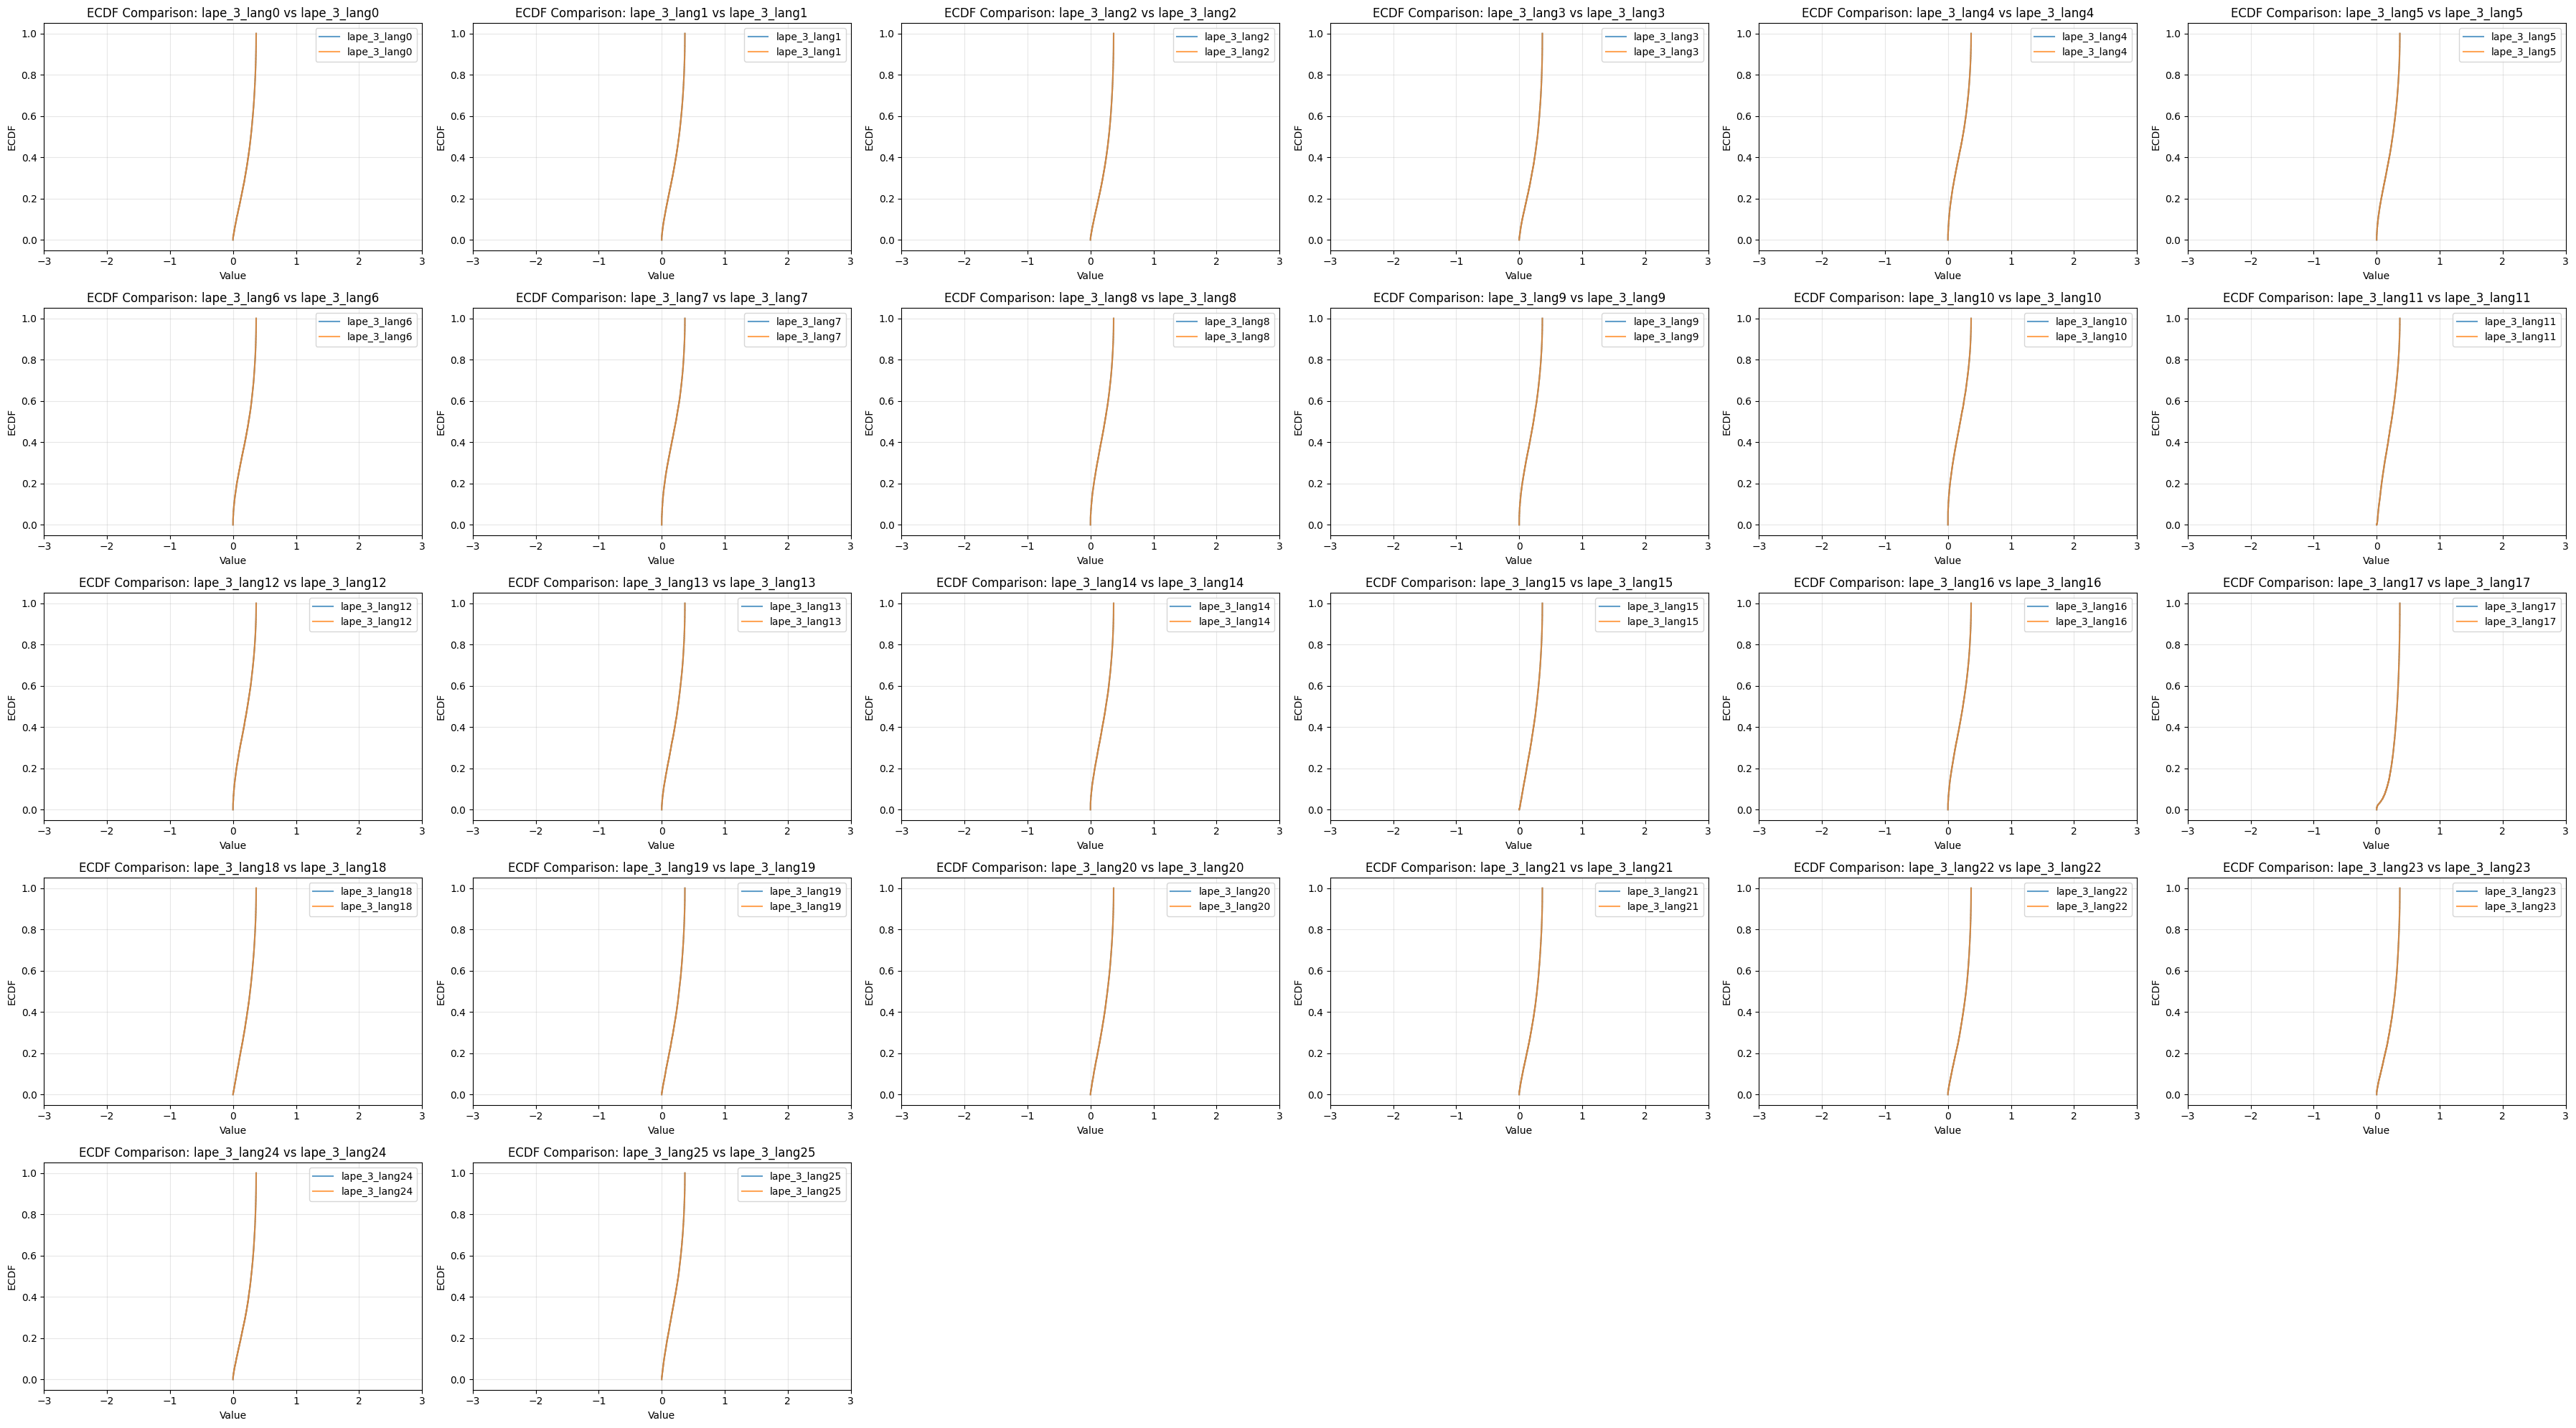

In [50]:
'''
vi

'''
draw_score_per_layer_ecdf_score(per_lang_lape_score[1])


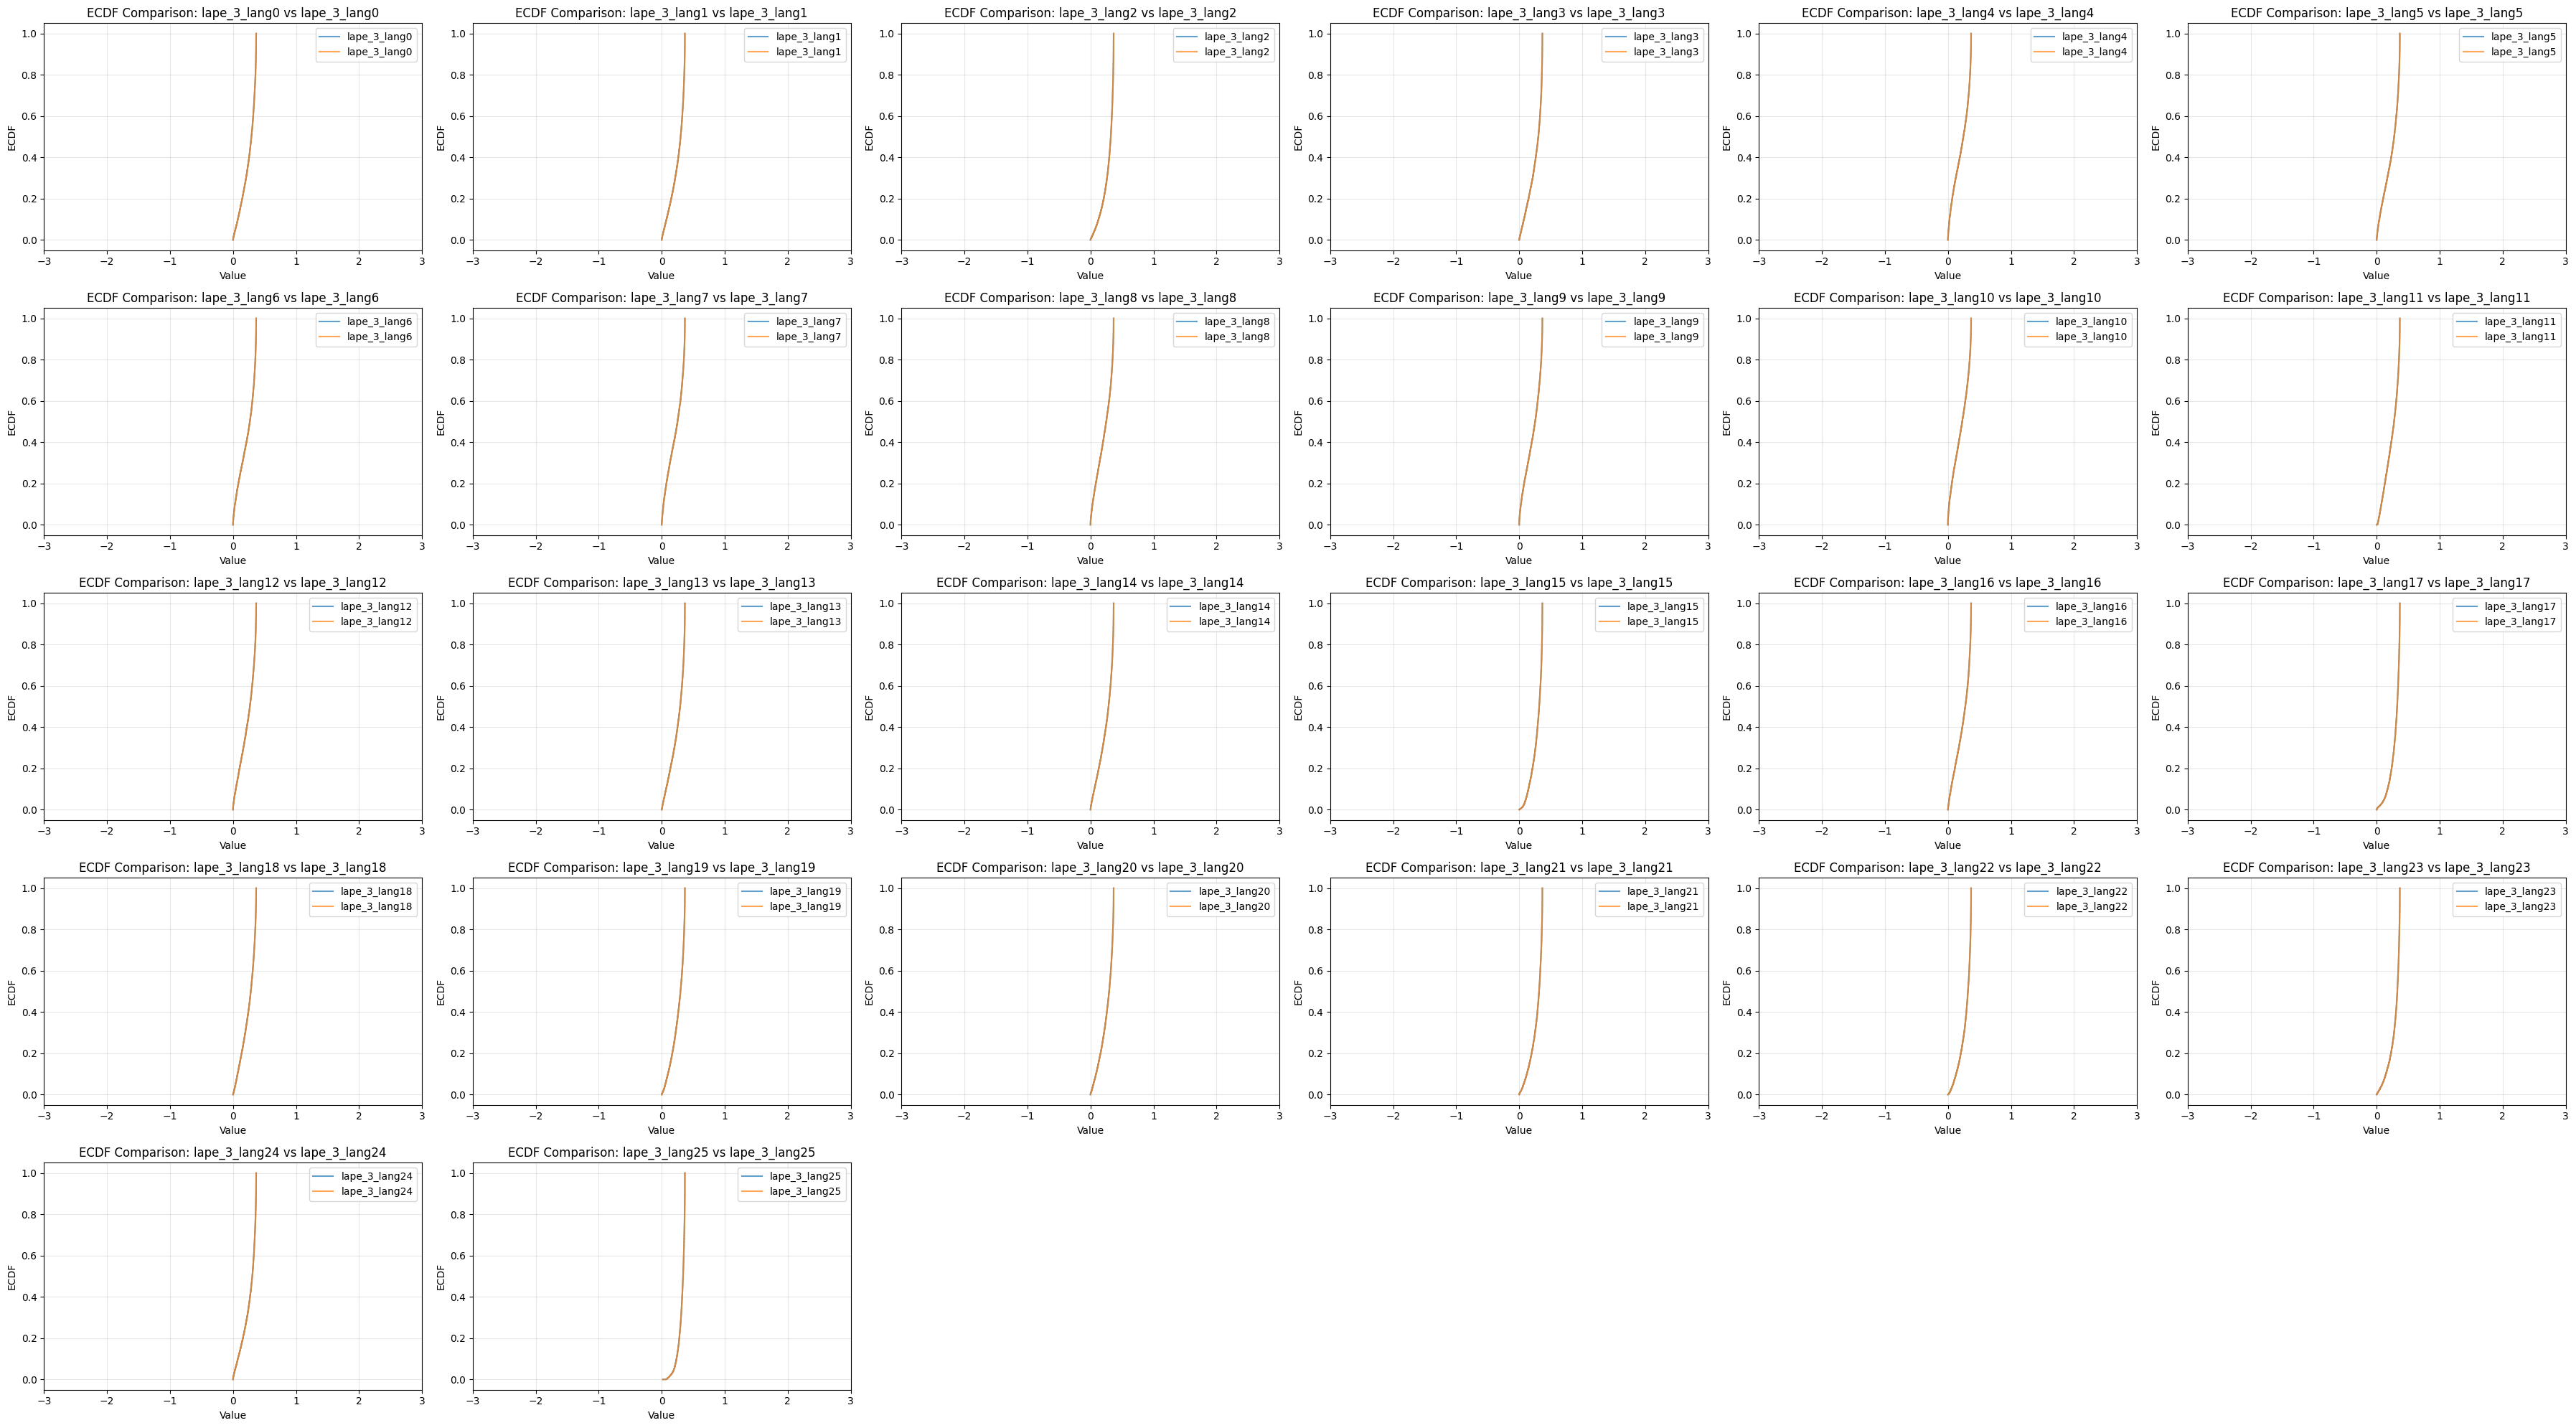

In [51]:
'''
zh

'''
draw_score_per_layer_ecdf_score(per_lang_lape_score[2])


In [45]:
'''
挑选bottom 1%的 neuron

'''

def select_botton_1perc_neuron(lape_score):

    lape_score
    
    
    per_neuron_map = {}
    
    for ikey in tqdm(lape_score.keys()):
    
        for index in range(len(lape_score[ikey])):
            per_neuron_map[f'{ikey}_index_{index}'] = lape_score[ikey][index]
    
    # sorted
    
    bottm_index= int(len(per_neuron_map)*0.01)
    sorted_per_neuron_map = sorted(per_neuron_map.items(), key = lambda x: x[1])
    
    selected_lang_neuron = sorted_per_neuron_map[:bottm_index]
    return selected_lang_neuron


In [46]:
selected_lang_neuron = select_botton_1perc_neuron(lape_score)

100%|██████████| 78/78 [00:00<00:00, 502.91it/s]


In [52]:
selected_lang_neuron_en =  select_botton_1perc_neuron(per_lang_lape_score[0])
selected_lang_neuron_vi =  select_botton_1perc_neuron(per_lang_lape_score[1])
selected_lang_neuron_zh =  select_botton_1perc_neuron(per_lang_lape_score[2])

100%|██████████| 78/78 [00:00<00:00, 336.43it/s]


In [53]:
selected_lang_neuron_en

[('model.layers.0.mlp.up_proj.weight_index_381',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_470',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_2267',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_4680',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.2.mlp.up_proj.weight_index_342',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.3.mlp.gate_proj.weight_index_2771',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.3.mlp.up_proj.weight_index_1485',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.3.mlp.up_proj.weight_index_2480',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.3.mlp.up_proj.weight_index_3620',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.3.mlp.up_proj.weight_index_6512',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.4.mlp.gate_proj.weight_index_893',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.4.mlp

In [54]:
selected_lang_neuron_vi

[('model.layers.0.mlp.gate_proj.weight_index_1517',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_1668',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_3366',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_3495',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_4031',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_5222',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_5560',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.gate_proj.weight_index_6572',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_119',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_1027',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_1054',
  np.float64(-9.999994999180668e-07)),
 ('mod

In [55]:
selected_lang_neuron_zh

[('model.layers.0.mlp.gate_proj.weight_index_6665',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_532',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_598',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_3015',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_3364',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_3655',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_5779',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_6665',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_6668',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.0.mlp.up_proj.weight_index_6709',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.2.mlp.gate_proj.weight_index_5858',
  np.float64(-9.999994999180668e-07)),
 ('model.layers.2.m

In [58]:
def save_lape_neuron_res(neu_res, save_path):

    torch.save(neu_res, save_path)
save_lape_neuron_res(selected_lang_neuron_en, '/root/autodl-fs/LAPE_res/202251124_en.pt')
save_lape_neuron_res(selected_lang_neuron_vi, '/root/autodl-fs/LAPE_res/202251124_vi.pt')
save_lape_neuron_res(selected_lang_neuron_zh, '/root/autodl-fs/LAPE_res/202251124_zh.pt')

In [47]:
len(selected_lang_neuron)

3893

In [48]:
selected_lang_neuron

[('model.layers.3.mlp.gate_proj.weight_index_2771',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.3.mlp.up_proj.weight_index_1485',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.3.mlp.up_proj.weight_index_3620',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.gate_proj.weight_index_1421',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.gate_proj.weight_index_2774',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_687',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_3243',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_3711',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_3826',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_3939',
  np.float64(-2.9999984997542005e-06)),
 ('model.layers.4.mlp.up_proj.weight_index_4312',
  np.float64(-2.9999984997542005e-06)),
 ('mo

In [42]:
sorted_per_neuron_map[-1]

('model.layers.14.mlp.gate_proj.weight_index_1280',
 np.float64(1.1035602883890026))

In [49]:
lape_score

{'model.embed_tokens.weight': array([0.        , 0.        , 0.12976147, ..., 0.        , 0.        ,
        0.        ], shape=(262144,)),
 'model.layers.0.self_attn.q_proj.weight': array([1.05293307, 0.90889525, 0.80276838, ..., 1.04763366, 0.84592585,
        1.09660682], shape=(1024,)),
 'model.layers.0.self_attn.k_proj.weight': array([0.42967848, 0.60757   , 0.57660071, 0.4465658 , 0.43306243,
        0.95737132, 0.5495595 , 0.80776937, 0.79339476, 0.72732898,
        0.79716168, 0.67724883, 0.70813275, 0.97293125, 1.02477653,
        0.76605452, 1.04889065, 0.96642824, 1.00791415, 0.96408521,
        0.95776423, 1.04059988, 0.69312907, 0.95388828, 0.82380166,
        0.24202008, 1.03532464, 1.05504104, 1.02610644, 1.01144481,
        1.00227623, 1.09797635, 0.91302917, 0.97241021, 0.67660673,
        0.68068653, 1.05306836, 0.71744753, 1.06323823, 0.98370427,
        1.06083962, 0.        , 0.51661454, 1.00392769, 1.06667591,
        1.02203673, 0.06396093, 1.07419992, 1.0952463